# Data Compiling

## Configuration


In [ ]:
# simulation_root = "C:/kerta/AppData/LocalLow/DefaultCompany/Sumobot/Simulation"
# output_folder = "D:/Simulation_CSV"
simulation_root = "/Users/defdef/Library/Application Support/DefaultCompany/Sumobot/Simulation"
csv_folder = "/Users/defdef/Documents/Simulation"

batch_checkpoint_dir = "batched"
arena_heatmaps_output = "arena_heatmaps"

## Convert Simulation Log to CSV

In [ ]:
from compile.log_to_csv import ( 
    convert_all_configs
)

convert_all_configs(simulation_root, csv_folder)

## Generate Summarization CSV

### Import Functions

In [ ]:
from compile.generator_polars_gpu import (
        batch_process_csvs,
        generate_timebins_from_batches,
        generate
    )

### Generate Batched CSV

Process CSVs in batches and save checkpoints

Structure: base_dir/BotA_vs_BotB/ConfigFolder/*.csv

In [ ]:
timebin_size = 5
batch_size = 2 # if there's 156 matchup simulation folder, it will generate 156 / 2 = 78 summarization batch csv

batch_process_csvs(
    csv_folder, 
    batch_size=batch_size,
    time_bin_size=timebin_size,
    checkpoint_dir=batch_checkpoint_dir,
    compute_timebins=True)

### Generate Final Summarization CSV from Batches

Generate timebin summaries from batched timebin checkpoints
Loads batch files and creates final summaries

In [ ]:
generate(batch_checkpoint_dir) # generate summarization csv
generate_timebins_from_batches(batch_checkpoint_dir) # generate csv containing batched timebins

## Generate Arena Heatmaps Figure

### Import Functions

In [ ]:
import time
from compile.generate_arena_heatmap import ( 
    create_phased_heatmaps_all_bots
)

### Run to Generate Arena Heatmap figures

In [ ]:


start = time.time()

create_phased_heatmaps_all_bots(
            csv_folder,
            output_dir = arena_heatmaps_output,
            actor_position="both",
            chunksize=50000,
            max_configs=None,  # None for all configs, only fill to test, e.g. 2 or 5 configs
            mode="all",  # Generate both heatmaps and position distributions
            use_timer=False, # Group by existing Timer configuration
            use_time_windows=True, # Use time windows [skip_initial-15, 15-30, 30-45, 45-60]
            include_distance_over_time=True,  
            skip_initial=2.5
        )

elapsed_seconds = time.time() - start
hours, remainder = divmod(elapsed_seconds, 3600)
minutes, seconds = divmod(remainder, 60)
processing_time = f"{int(hours):02d}:{int(minutes):02d}:{seconds:.2f}"
print(f"\nProcessing Time: {processing_time}")

# Plotting

## Import Functions

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

from plotting.overall_analyzer import (
        plot_action_radar,
        plot_collision_radar,
        plot_winrate_matrix,
        plot_overall_bot_metrics,
        plot_grouped_config_winrates,
        plot_time_related,
        plot_action_distribution_stacked,
        plot_action_timebins_intensity,
        plot_collision_timebins_intensity,
        plot_collision_distribution_stacked,
        plot_action_win_related,
        plot_all_correlations,
        plot_full_cross_heatmap_half,
    )
    
from plotting.individual_analyzer import (
    plot_individual_bot_correlations,
)

## Load Data

In [121]:
# Load summary data
df_sum = pd.read_csv("summary_bot.csv").rename(columns={"Duration": "Duration (ms)"})
df = pd.read_csv("summary_matchup.csv")
df_timebins = pd.read_csv("summary_action_timebins.csv")
df_collision_timebins = pd.read_csv("summary_collision_timebins.csv")

# Configuration
cfg = {
    "Timer": sorted(df["Timer"].unique().tolist()),
    "ActInterval": sorted(df["ActInterval"].unique().tolist()),
    "Round": sorted(df["Round"].unique().tolist()),
    "SkillLeft": sorted(df["SkillLeft"].unique().tolist()),
    "SkillRight": sorted(df["SkillRight"].unique().tolist()),
    "Bots": sorted(df["Bot_L"].unique().tolist()),
}
bots = str.join(", ", cfg["Bots"])

# Display settings
width = 10
height = 6

print("Data loaded successfully!")
print(f"\nBots in experiment: {bots}")
print(f"\nConfiguration:")
for key, value in cfg.items():
    print(f"  {key}: {value}")

Data loaded successfully!

Bots in experiment: Bot_BT, Bot_NN, Bot_Primitive

Configuration:
  Timer: [45.0, 60.0]
  ActInterval: [0.1, 0.2]
  Round: ['BestOf1', 'BestOf3']
  SkillLeft: ['Boost', 'Stone']
  SkillRight: ['Boost', 'Stone']
  Bots: ['Bot_BT', 'Bot_NN', 'Bot_Primitive']


## Summary Matchup Data

In [122]:
display(df_sum)

Rank            Bot     Win-rate Action Duration          Actions  \
0     1         Bot_NN  0.71 (0.22)   22.32 (19.66)    87.02 (58.74)   
1     2  Bot_Primitive  0.41 (0.26)   19.87 (17.07)  246.11 (336.54)   
2     3         Bot_BT  0.33 (0.22)   13.59 (14.58)  233.74 (304.43)   

    Collisions  
0  7.03 (4.62)  
1   8.4 (4.88)  
2   7.0 (4.25)

## Complete Matchup Data

In [123]:
display(df)

Bot_L   Bot_R  Timer  ActInterval    Round SkillLeft SkillRight  \
0           Bot_BT  Bot_NN   45.0          0.1  BestOf1     Boost      Stone   
1           Bot_BT  Bot_NN   45.0          0.1  BestOf1     Boost      Boost   
2           Bot_BT  Bot_NN   45.0          0.1  BestOf1     Stone      Boost   
3           Bot_BT  Bot_NN   45.0          0.1  BestOf3     Stone      Stone   
4           Bot_BT  Bot_NN   45.0          0.1  BestOf1     Stone      Stone   
..             ...     ...    ...          ...      ...       ...        ...   
187  Bot_Primitive  Bot_NN   60.0          0.2  BestOf3     Stone      Boost   
188  Bot_Primitive  Bot_NN   60.0          0.2  BestOf3     Stone      Stone   
189  Bot_Primitive  Bot_NN   60.0          0.2  BestOf3     Boost      Stone   
190  Bot_Primitive  Bot_NN   60.0          0.2  BestOf1     Stone      Boost   
191  Bot_Primitive  Bot_NN   60.0          0.2  BestOf1     Boost      Boost   

     Games  Winner_L  Winner_R  ...  Accelerate_Act_R  TurnLeft_Act_R  \
0       10         1         9  ...               244             258   
1       10         1         9  ...               128             134   
2       10         3         7  ...               135             180   
3       10         4         5  ...               484             337   
4       10         2         8  ...               530             434   
..     ...       ...       ...  ...               ...             ...   
187     10         2         8  ...               194             233   
188     10         0        10  ...               423             203   
189     10         1         9  ...               187             189   
190     10         6         4  ...                96             112   
191     10         1         9  ...                71              94   

     TurnRight_Act_R  Dash_Act_R  SkillBoost_Act_R  SkillStone_Act_R  \
0                308          57                 0                 8   
1                210          43                 4                 0   
2                148          48                 5                 0   
3                410          95                 0                32   
4                694          77                 0                14   
..               ...         ...               ...               ...   
187              276          80                 9                 0   
188              276         103                 0                14   
189              277          72                 0                 9   
190              104          57                15                 0   
191              128          24                 2                 0   

     WinRate_L  WinRate_R  Rank_L  Rank_R  
0          0.1        0.9       3       1  
1          0.1        0.9       3       1  
2          0.3        0.7       3       1  
3          0.4        0.5       3       1  
4          0.2        0.8       3       1  
..         ...        ...     ...     ...  
187        0.2        0.8       2       1  
188        0.0        1.0       2       1  
189        0.1        0.9       2       1  
190        0.6        0.4       2       1  
191        0.1        0.9       2       1  

[192 rows x 47 columns]

## Overall Analysis

Analyze bot agents facing other agents with similar configurations

### Bot Behaviour Overview

#### Actions Behaviour
Mean action counts per bot across all configurations

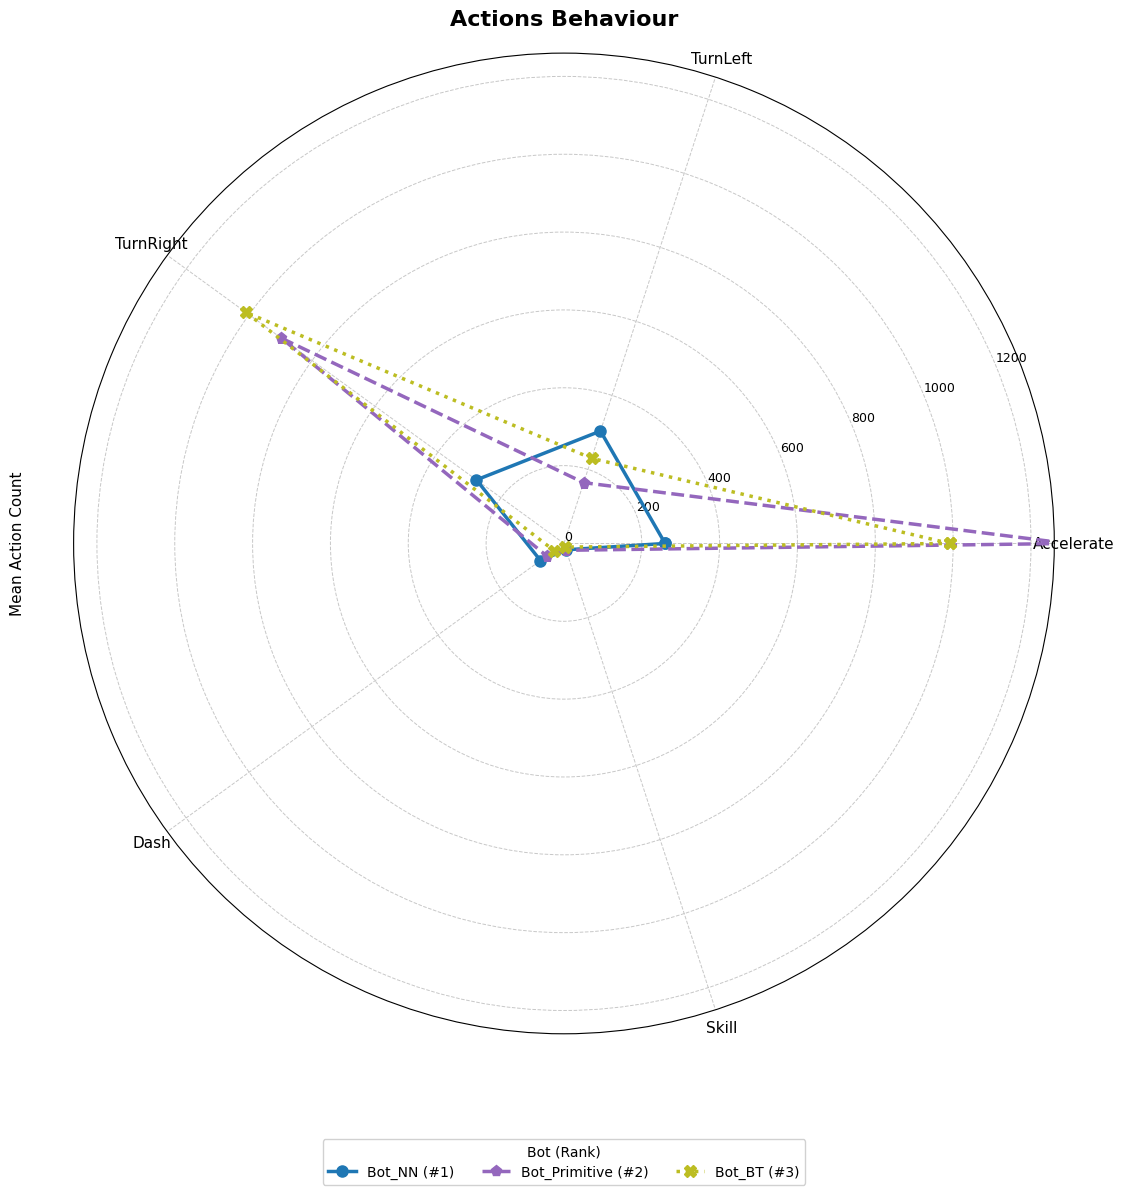

In [124]:
fig = plot_action_radar(df)
plt.show()

#### Collision Behaviour
Hit/Struck/Tie distribution per bot

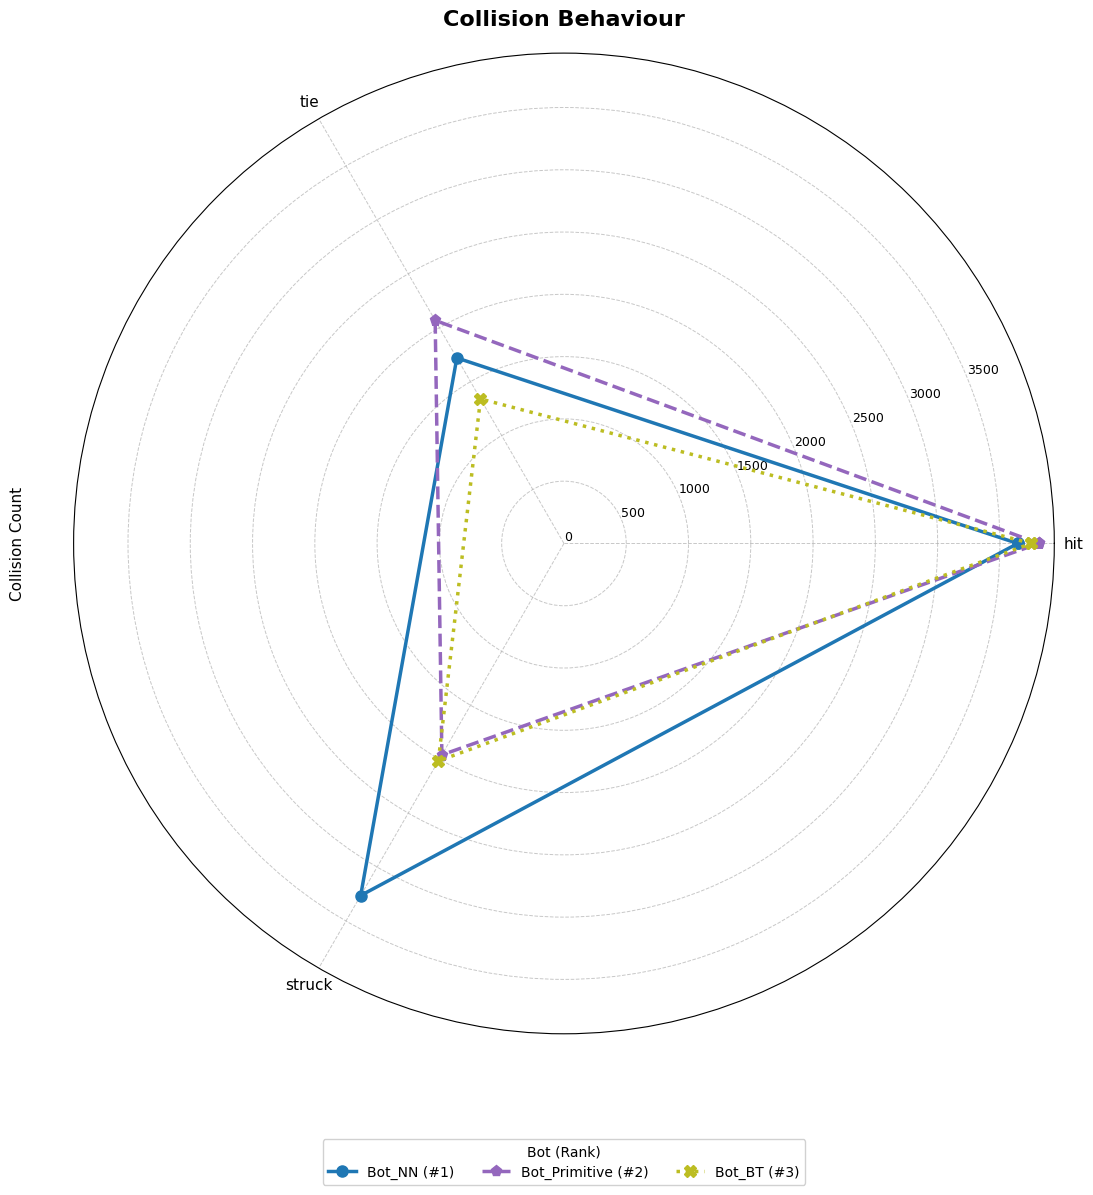

In [125]:
fig = plot_collision_radar(df)
plt.show()

### Win Rate Matrix

Shows how often each bot wins against others across different matchups.
This is calculated with taking mean of each configuration (10-games iteration matchup) resulting 240 games in total

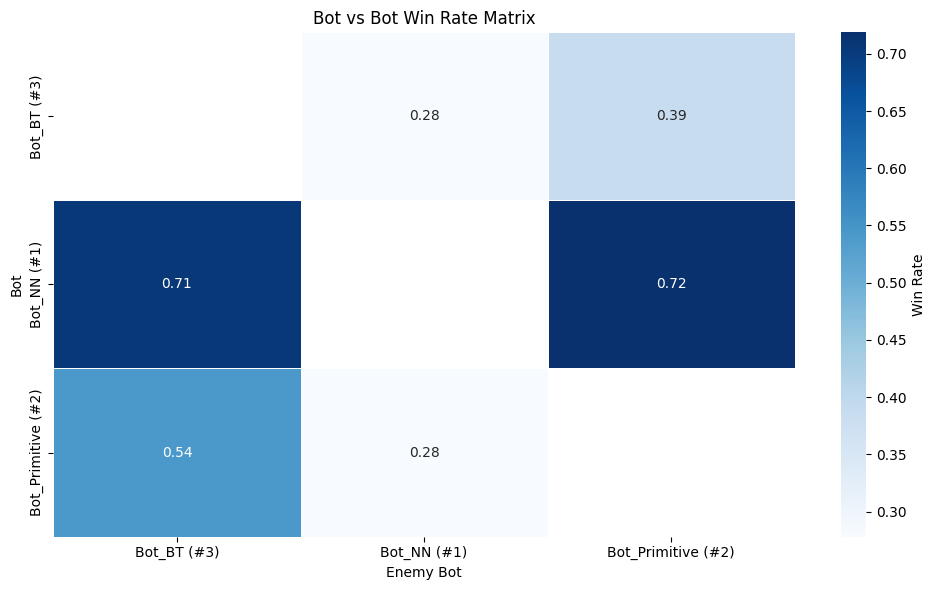

In [126]:
fig = plot_winrate_matrix(df, width, height)
plt.show()

### Action Taken (All Configurations)

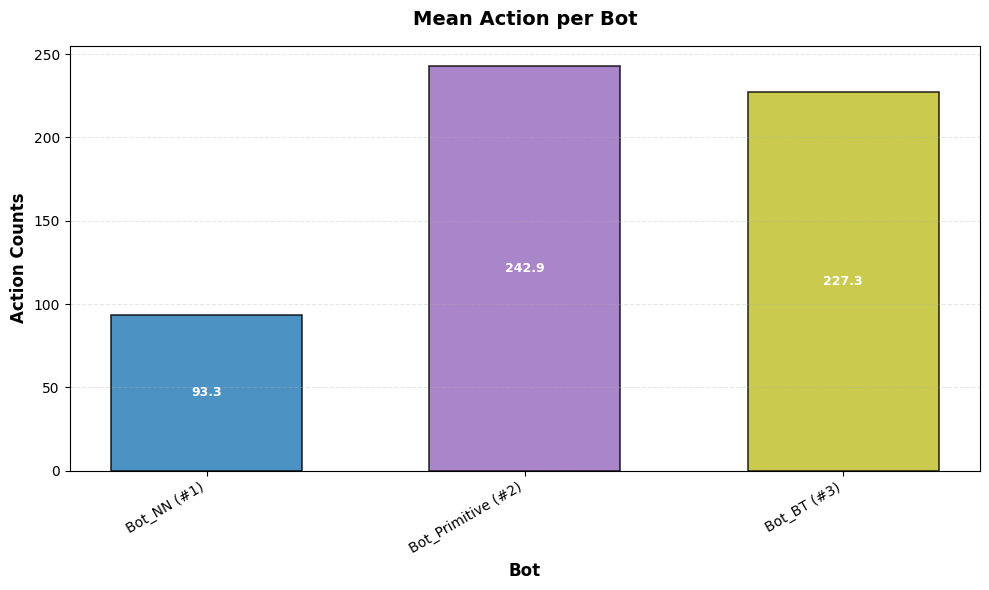

In [127]:
fig = plot_overall_bot_metrics(df, metric="ActionCounts_L", title="Mean Action per Bot")
plt.show()

### Action Duration (All Configurations)

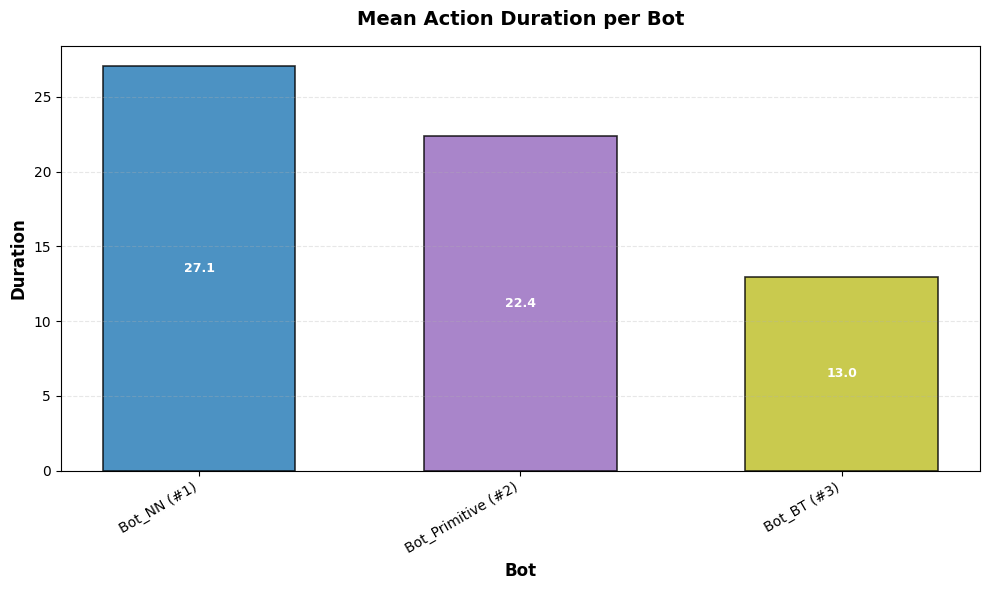

In [128]:
fig = plot_overall_bot_metrics(df, metric="Duration_L", title="Mean Action Duration per Bot")
plt.show()

### Collision (All Configurations)

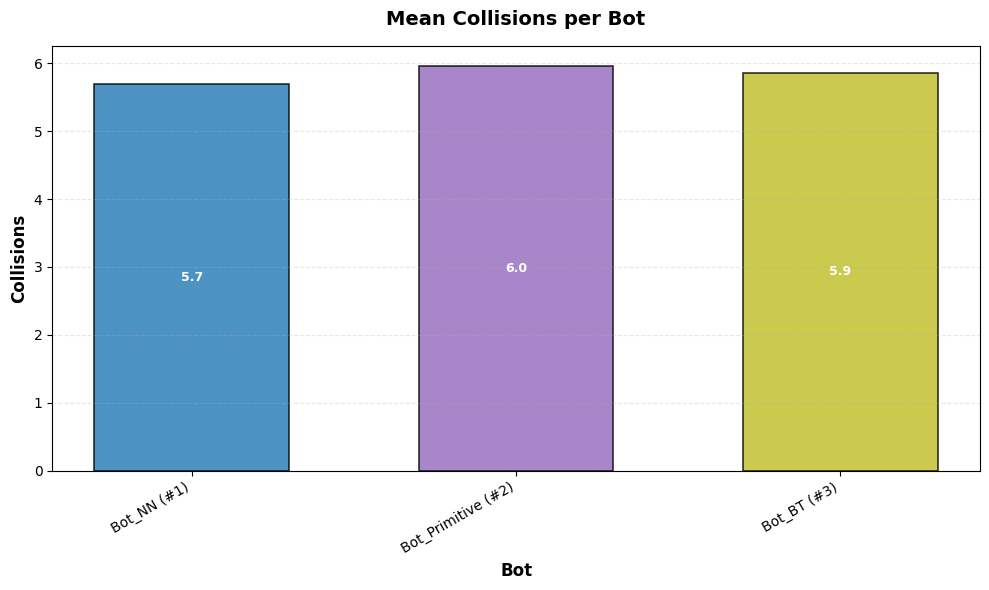

In [129]:
fig = plot_overall_bot_metrics(df, metric="Collisions_L", title="Mean Collisions per Bot")
plt.show()

### Match Duration (All Configurations)

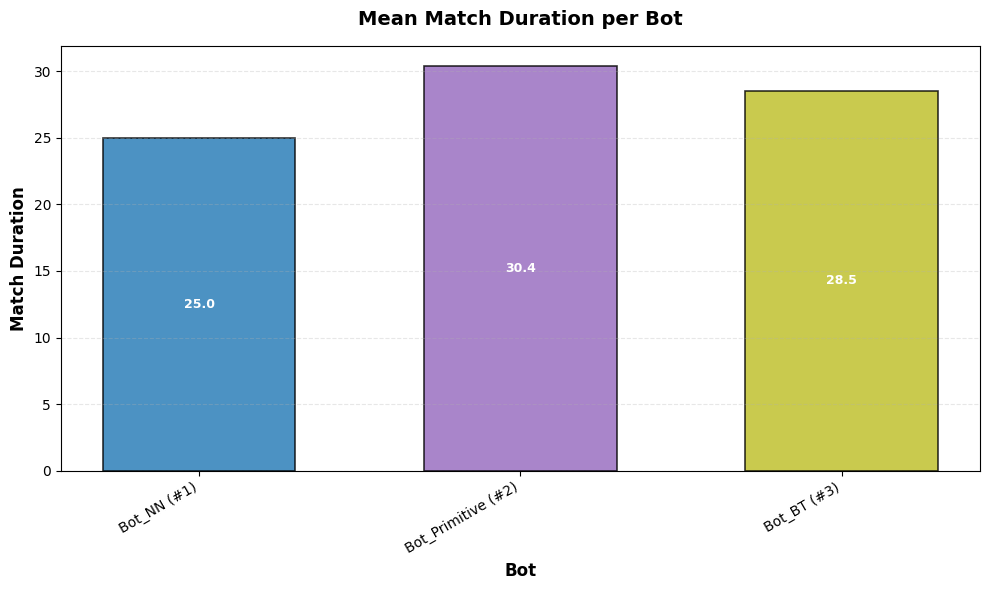

In [130]:
fig = plot_overall_bot_metrics(df, metric="MatchDur", title="Mean Match Duration per Bot")
plt.show()

### Win Rate Grouped by Timer

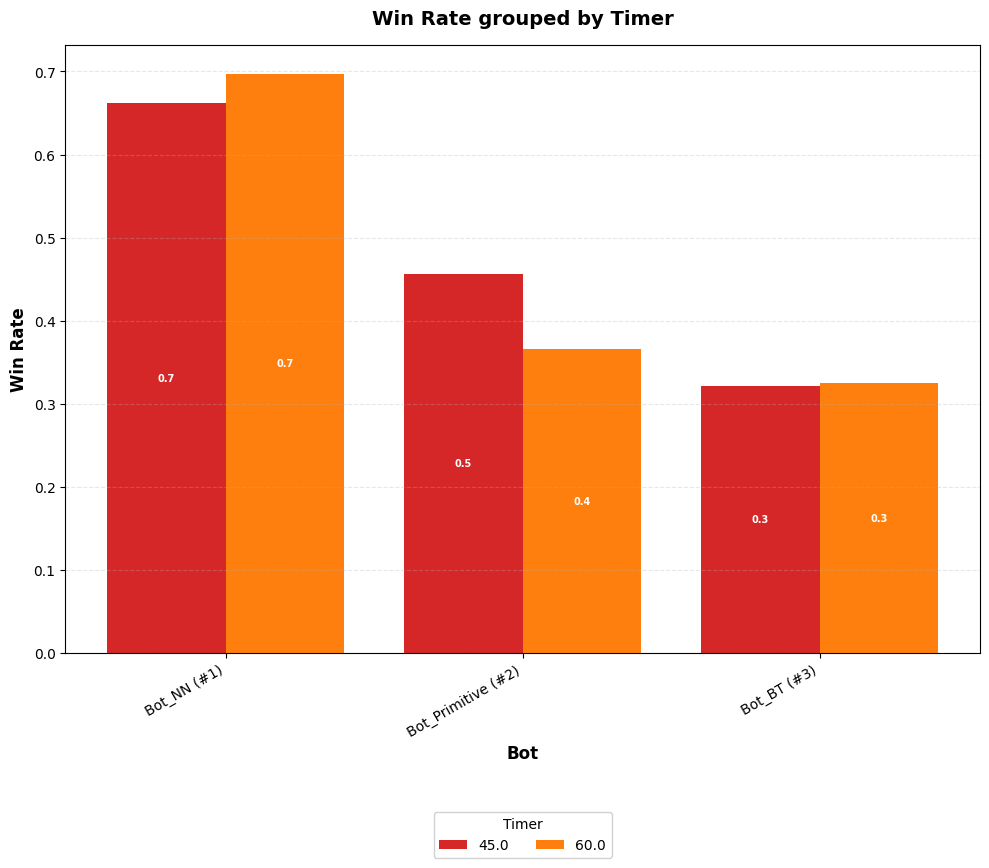

In [131]:
fig = plot_grouped_config_winrates(df, config_col="Timer")
plt.show()

### Win Rate Grouped by Action Interval

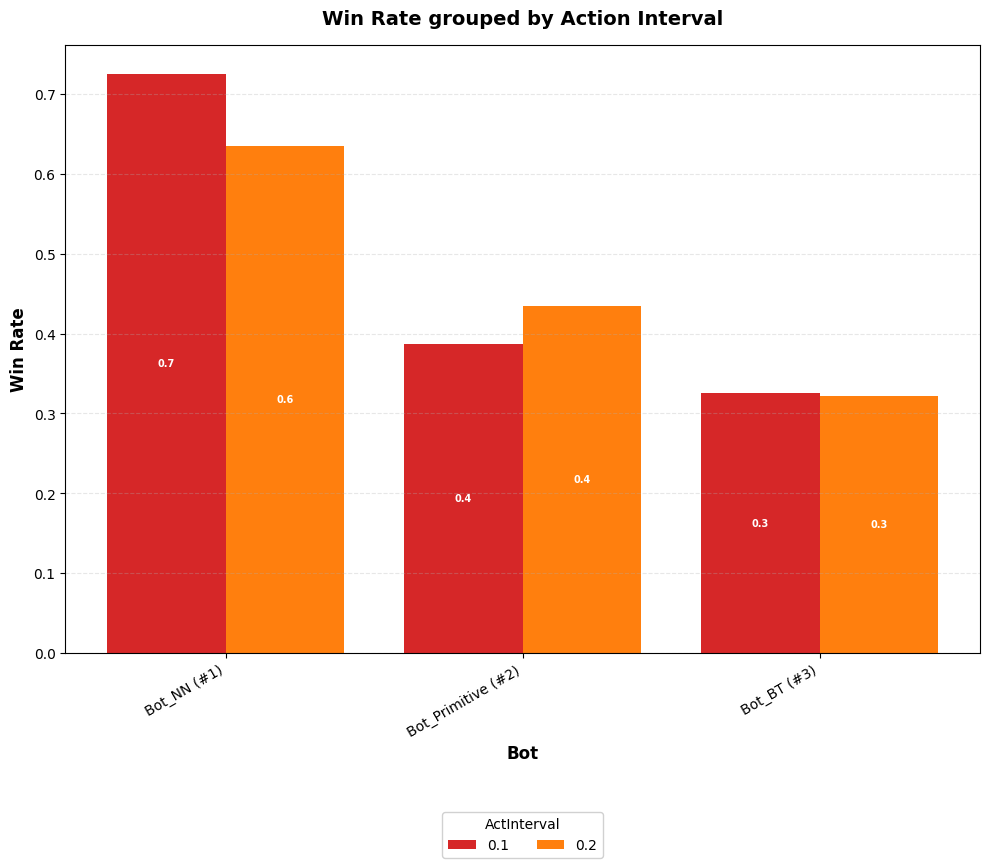

In [132]:
fig = plot_grouped_config_winrates(df, config_col="ActInterval")
plt.show()

### Win Rate Grouped by Round

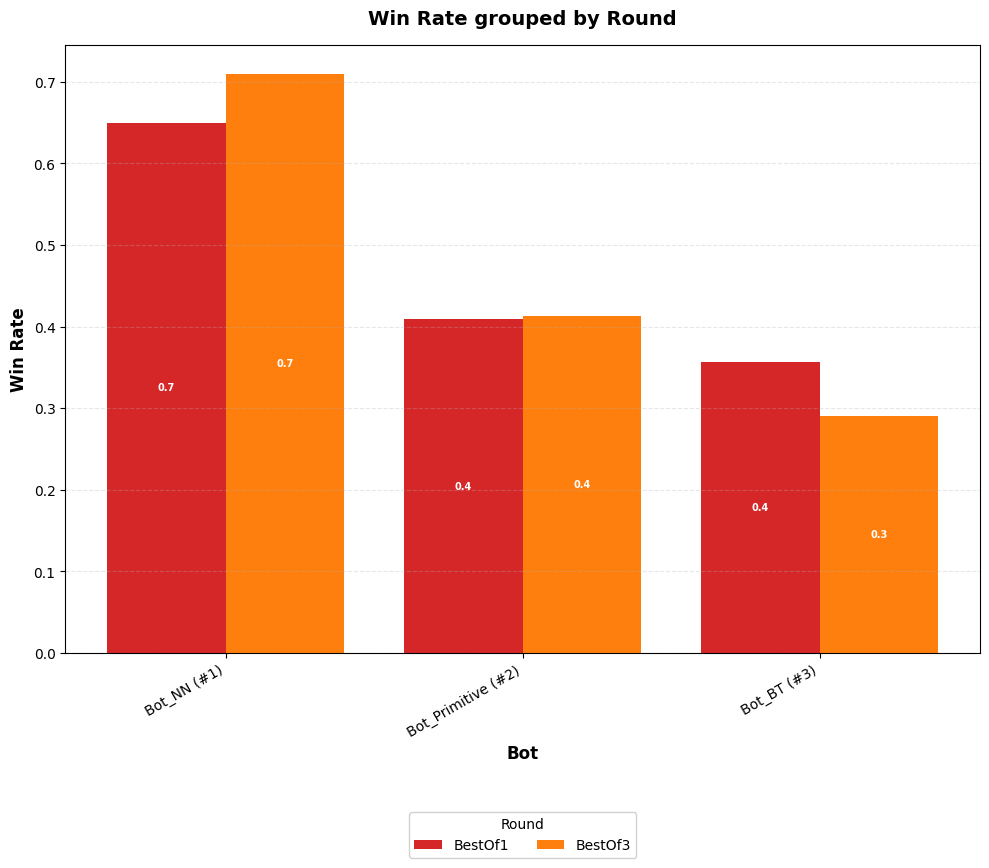

In [133]:
fig = plot_grouped_config_winrates(df, config_col="Round")
plt.show()

### Win Rate Grouped by Skill

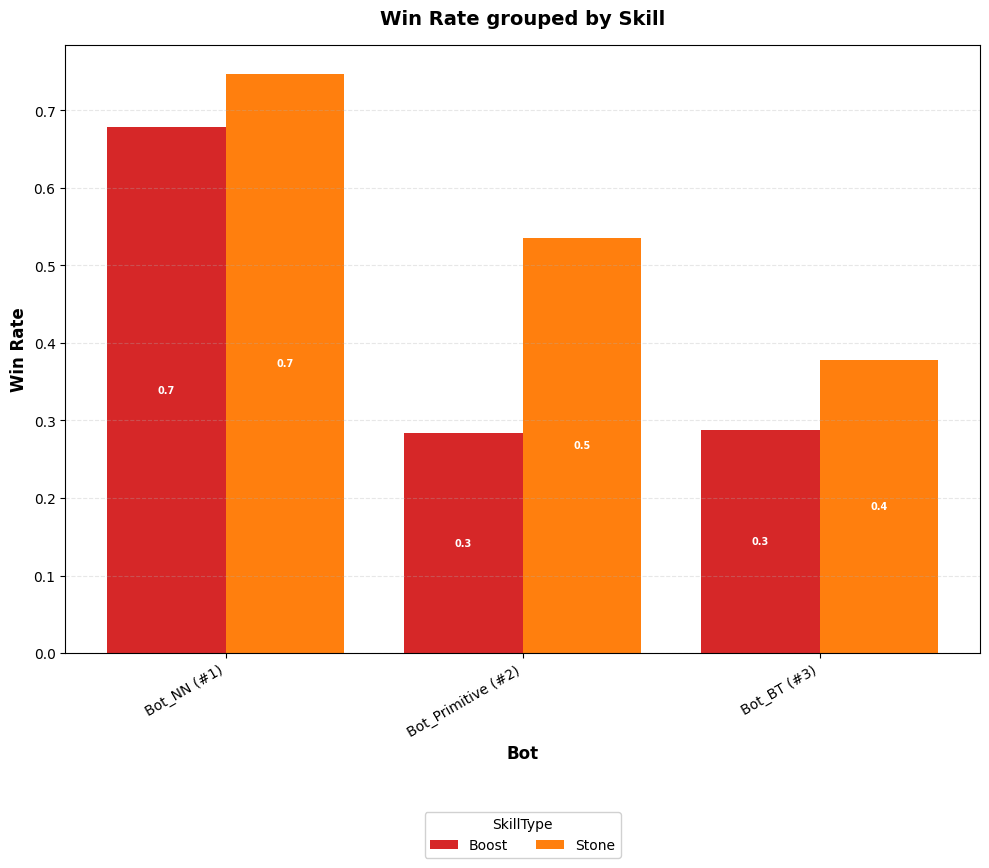

In [134]:
fig = plot_grouped_config_winrates(df, config_col="Skill")
plt.show()

### Collision Grouped by Timer

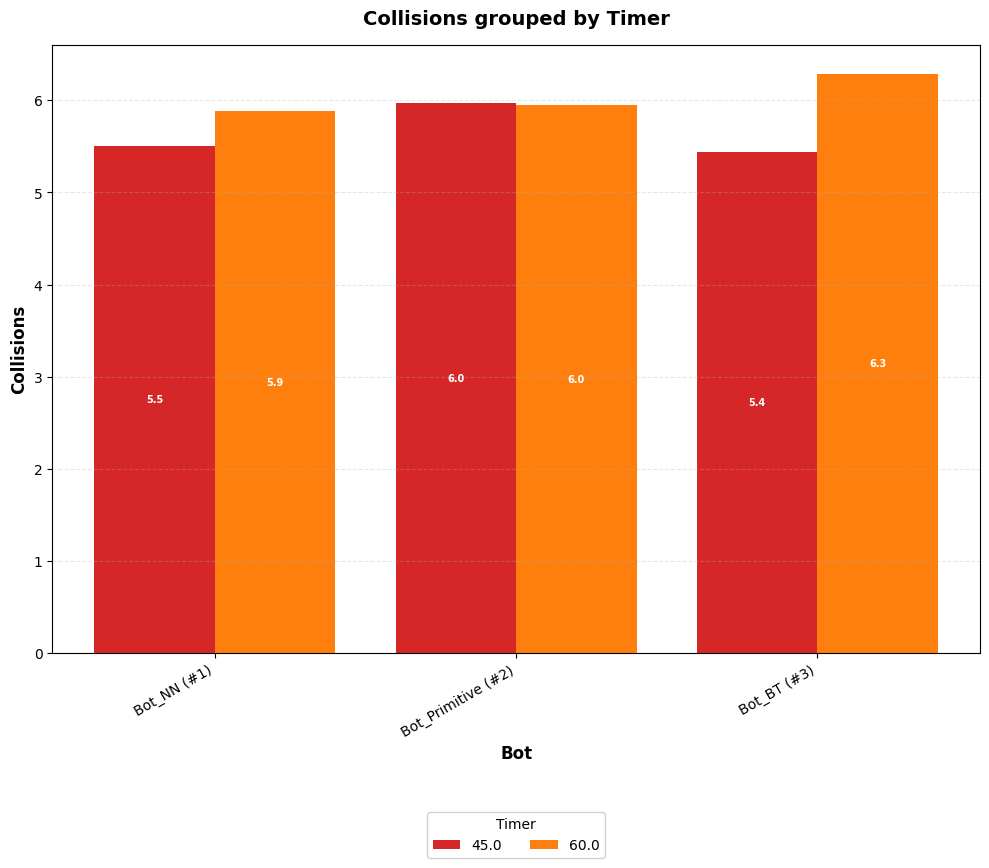

In [135]:
fig = plot_grouped_config_winrates(df, metric="Collisions_L", config_col="Timer")
plt.show()

### Collision Grouped by Action Interval

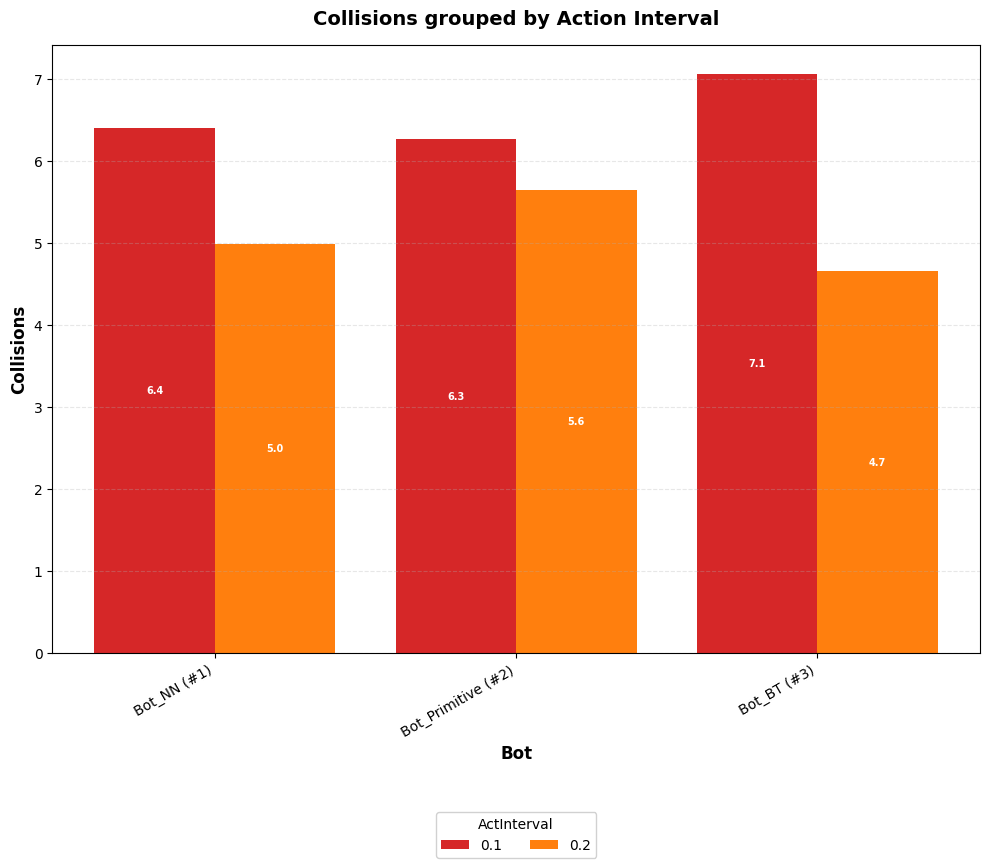

In [136]:
fig = plot_grouped_config_winrates(df, metric="Collisions_L", config_col="ActInterval")
plt.show()

### Collision Grouped by Round

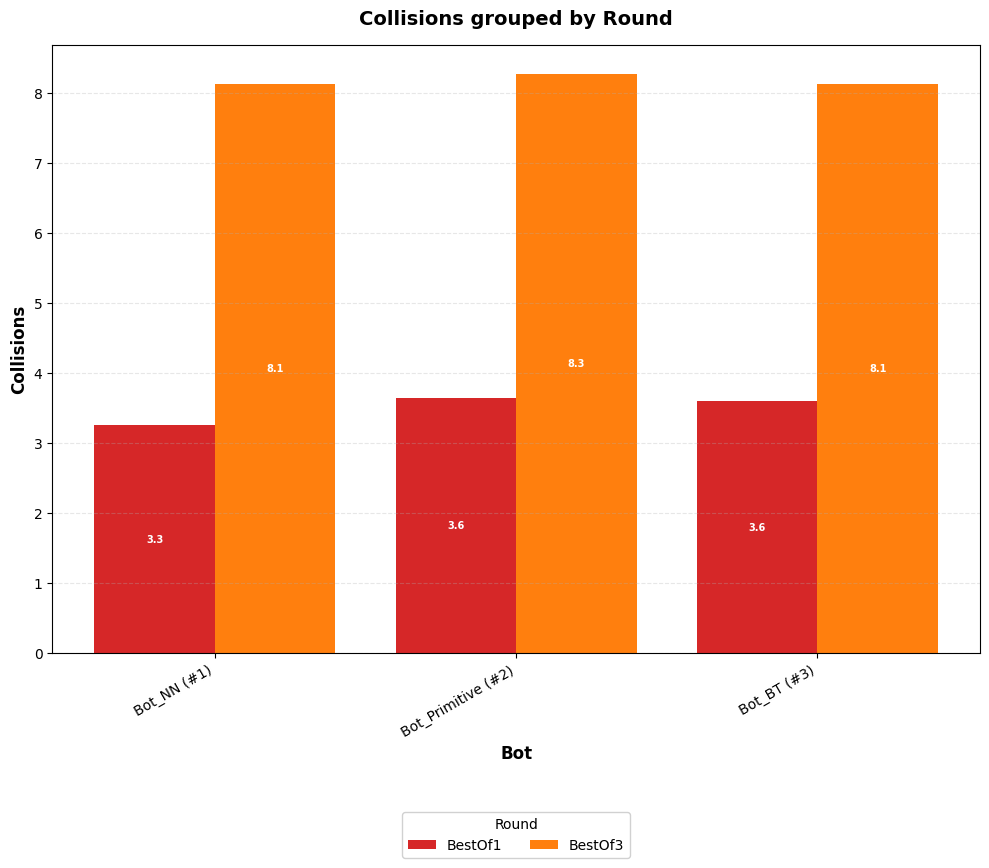

In [137]:
fig = plot_grouped_config_winrates(df, metric="Collisions_L", config_col="Round")
plt.show()

### Collision Grouped by Skill

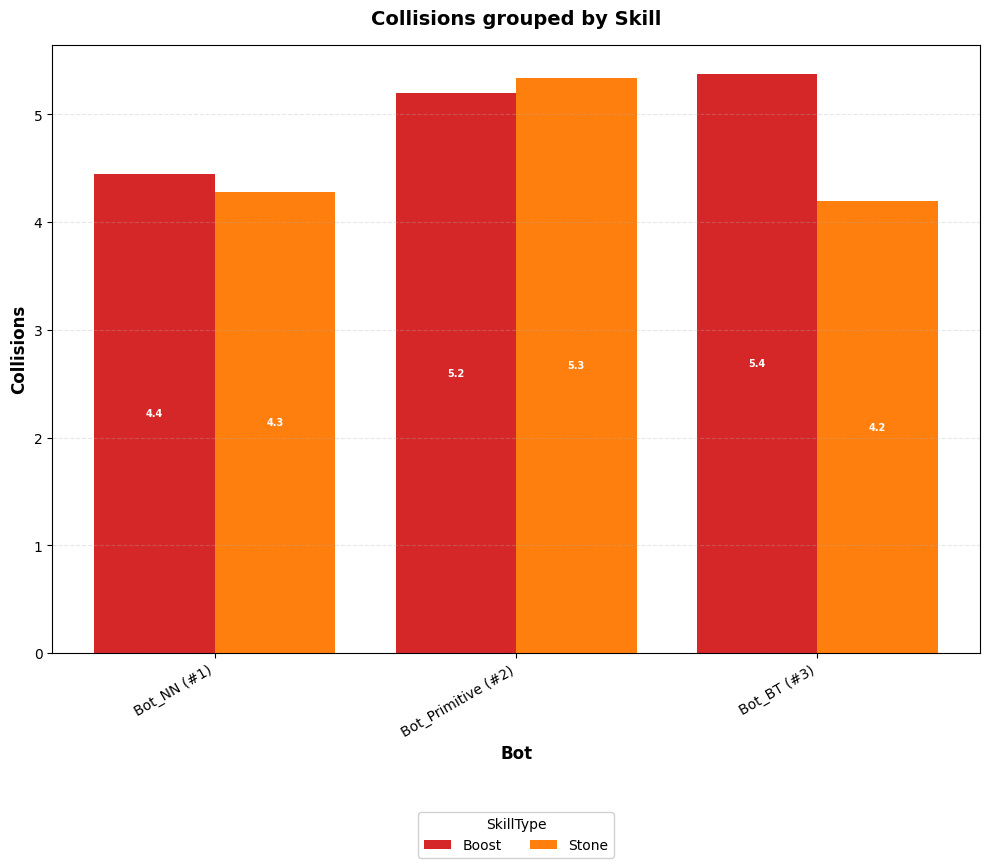

In [138]:
fig = plot_grouped_config_winrates(df, metric="Collisions_L", config_col="Skill")
plt.show()

### Action Taken Grouped by Timer

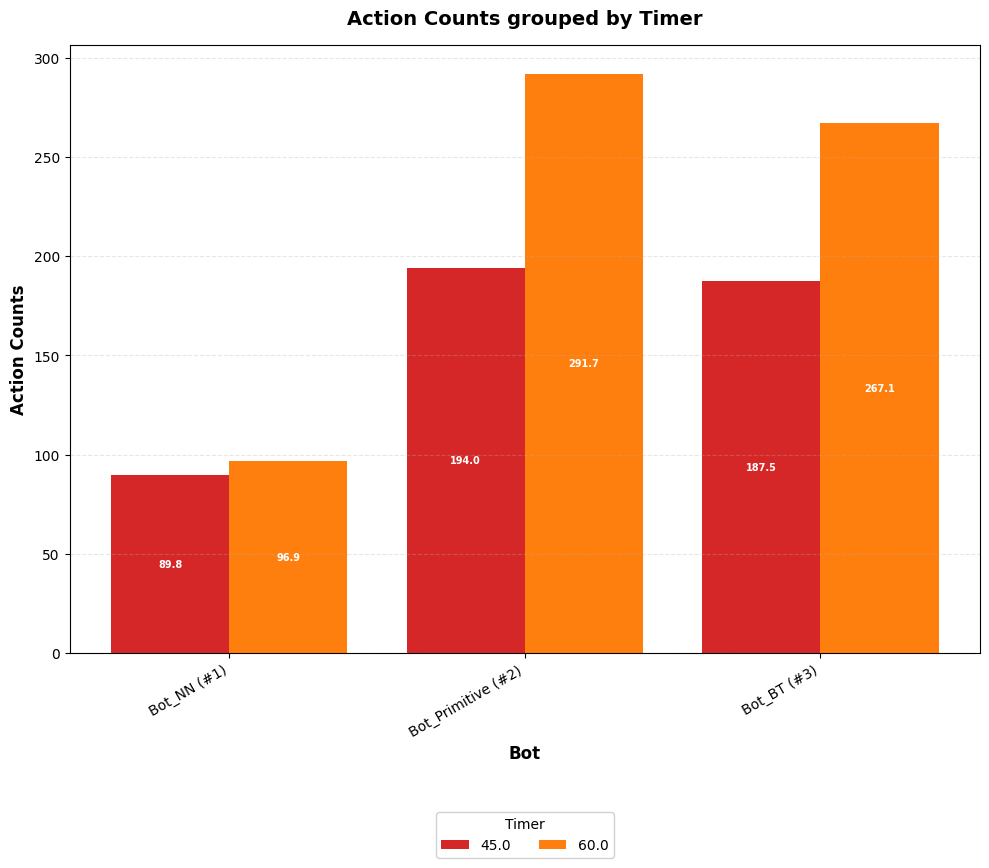

In [139]:
fig = plot_grouped_config_winrates(df, metric="ActionCounts_L", config_col="Timer")
plt.show()

### Action Taken Grouped by Action Interval

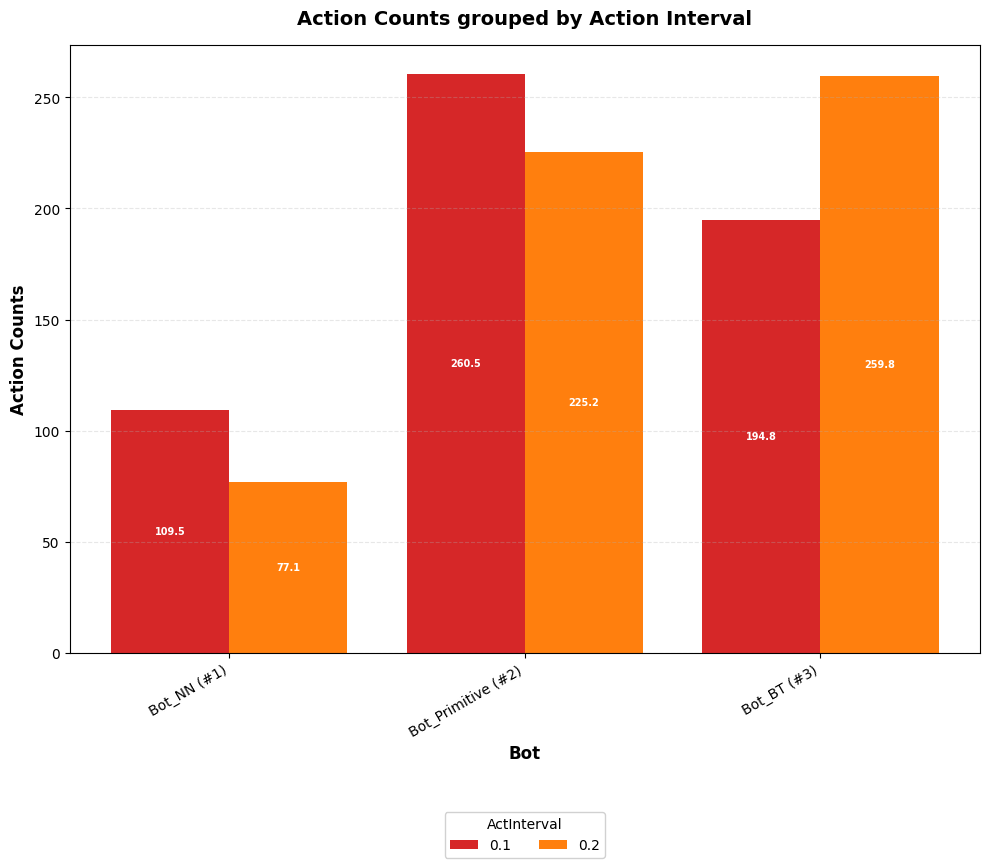

In [140]:
fig = plot_grouped_config_winrates(df, metric="ActionCounts_L", config_col="ActInterval")
plt.show()

### Action Taken Grouped by Round

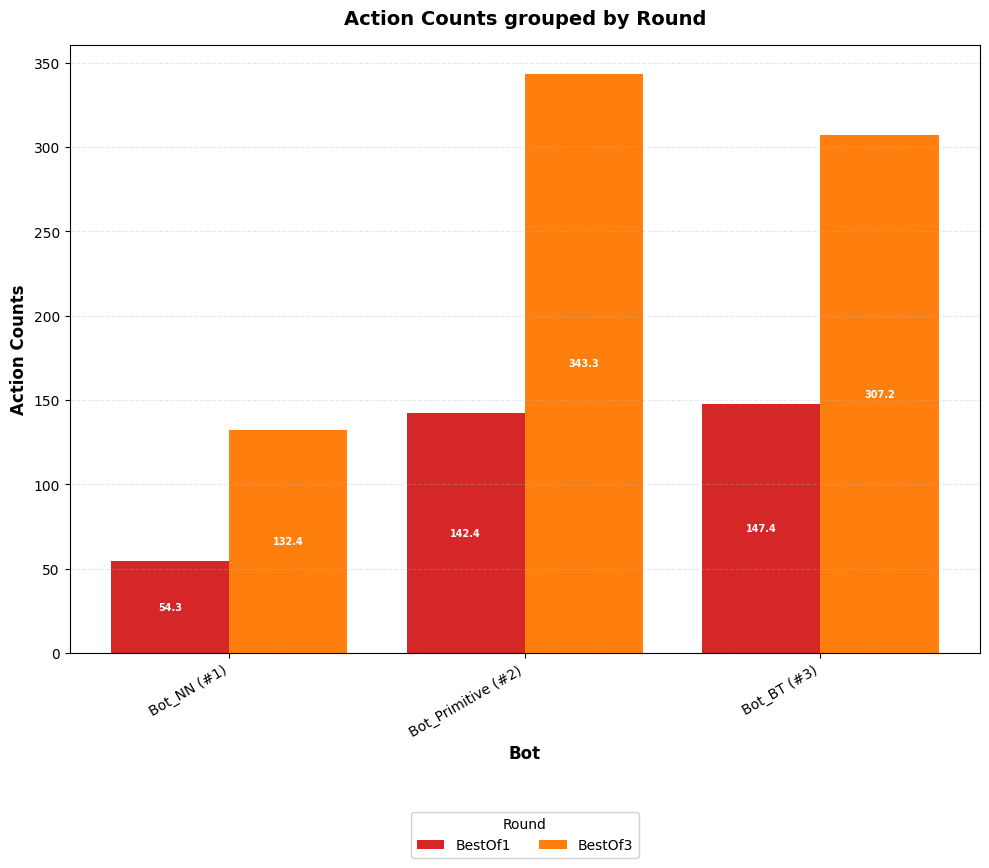

In [141]:
fig = plot_grouped_config_winrates(df, metric="ActionCounts_L", config_col="Round")
plt.show()

### Action Taken Grouped by Skill

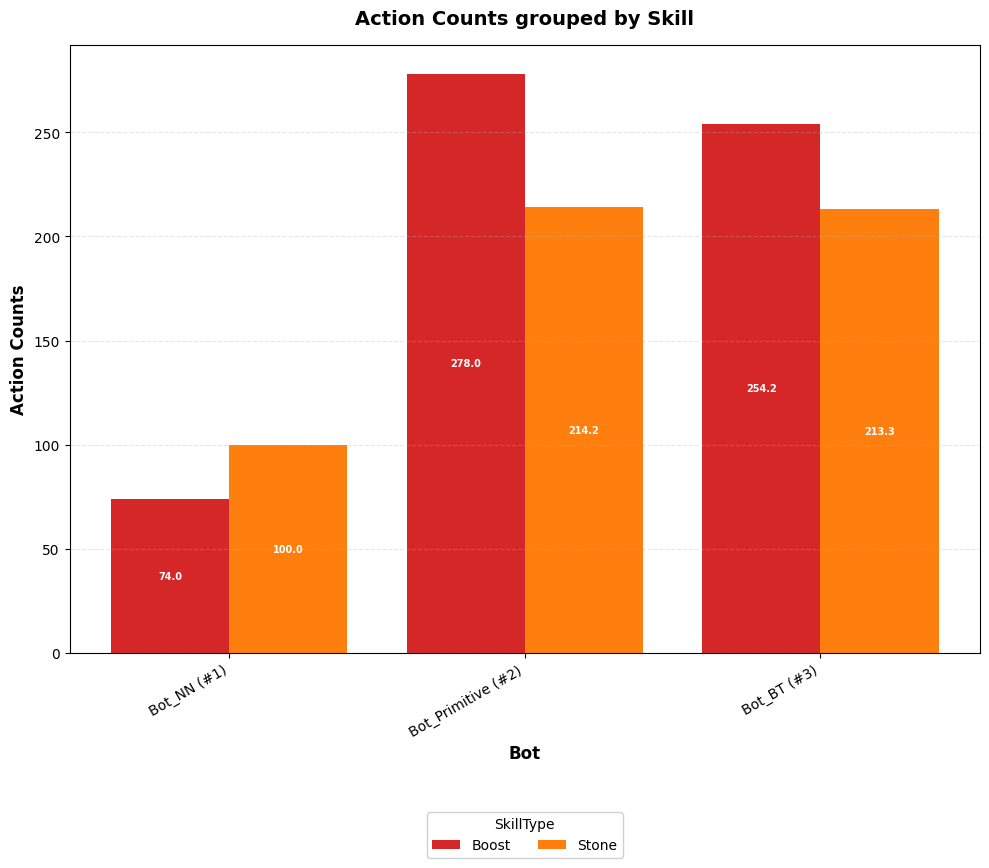

In [142]:
fig = plot_grouped_config_winrates(df, metric="ActionCounts_L", config_col="Skill")
plt.show()

### Action Duration Grouped by Timer

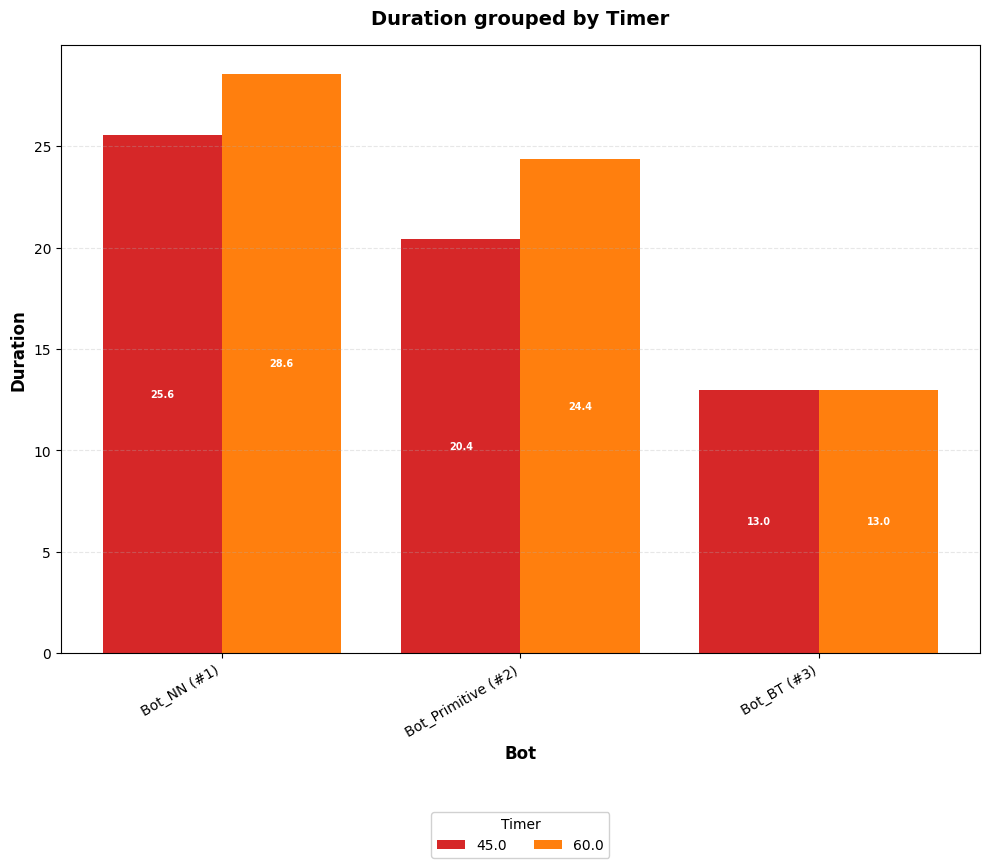

In [143]:
fig = plot_grouped_config_winrates(df, metric="Duration_L", config_col="Timer")
plt.show()

### Action Duration Grouped by Action Interval

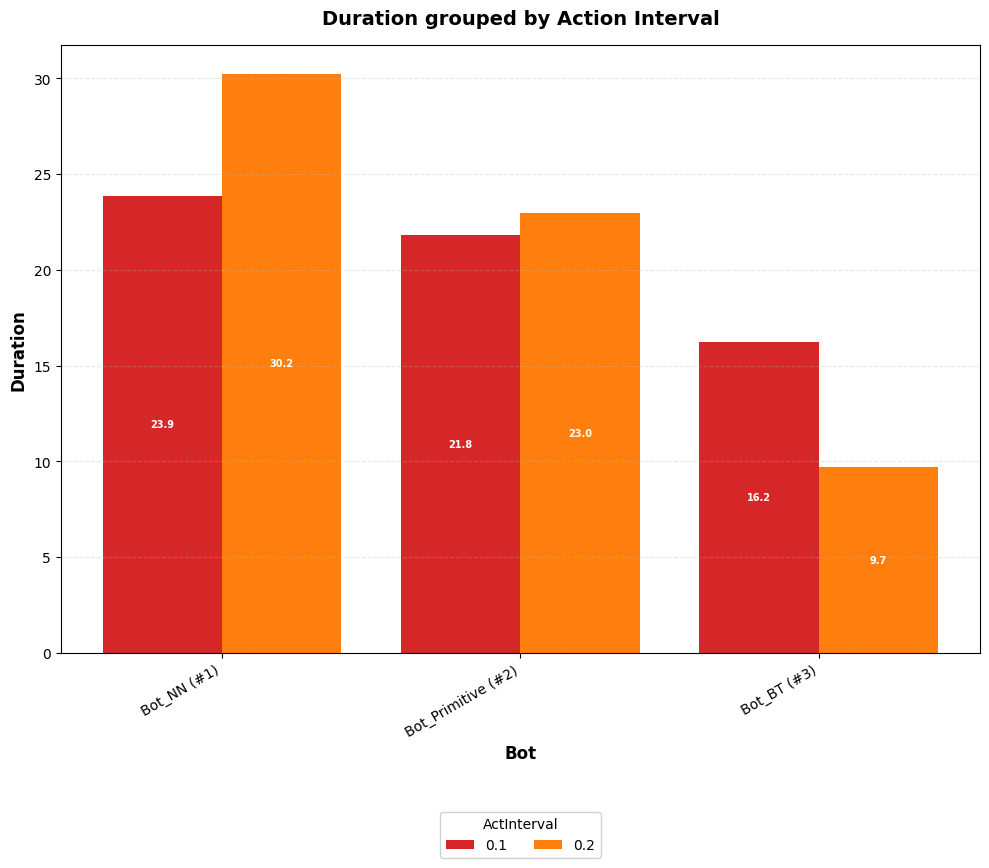

In [144]:
fig = plot_grouped_config_winrates(df, metric="Duration_L", config_col="ActInterval")
plt.show()

### Action Duration Grouped by Round

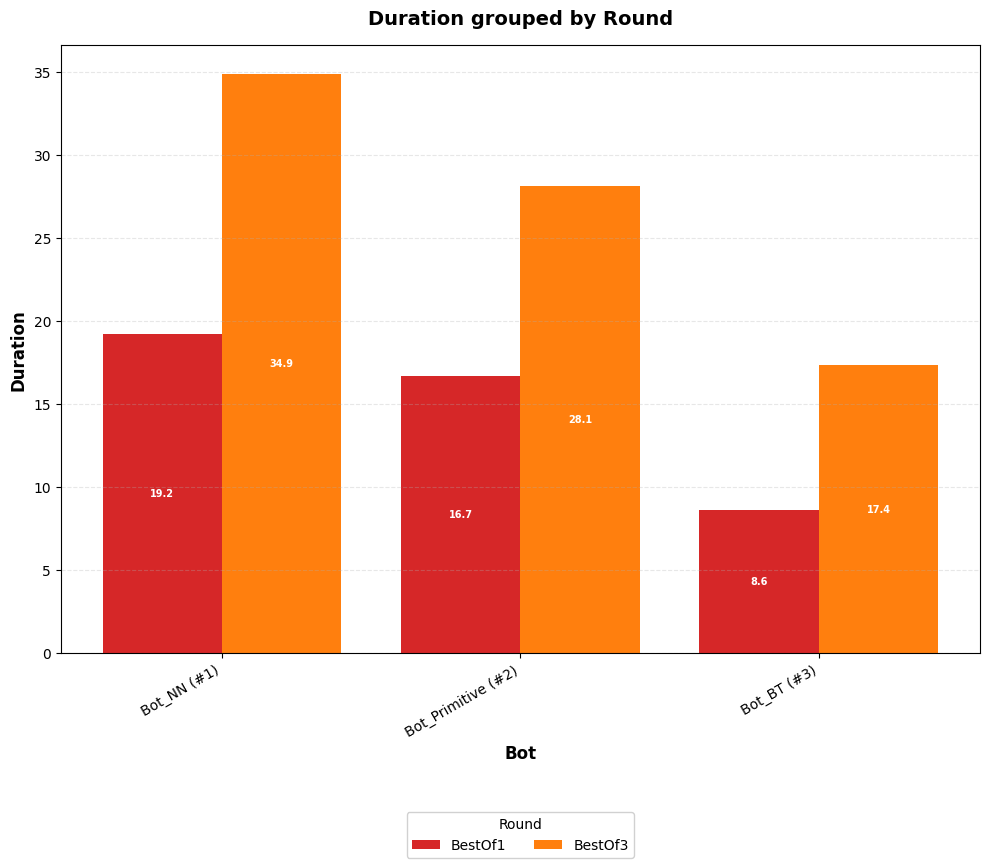

In [145]:
fig = plot_grouped_config_winrates(df, metric="Duration_L", config_col="Round")
plt.show()

### Action Duration Grouped by Skill

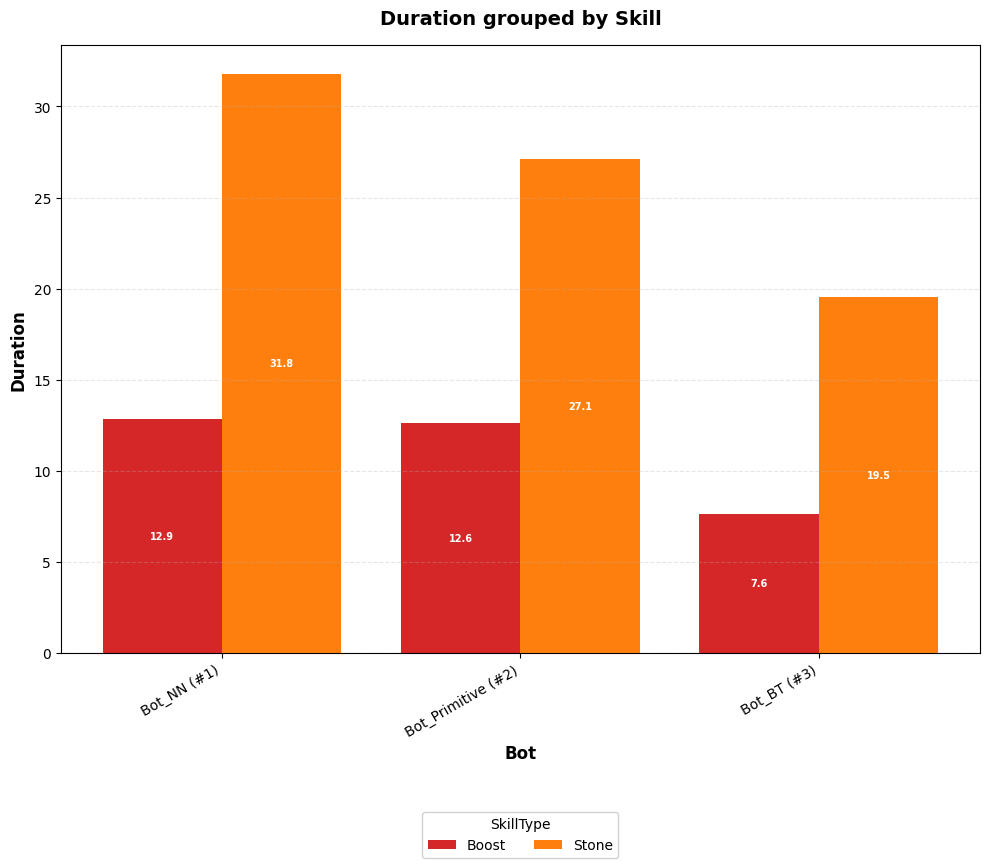

In [146]:
fig = plot_grouped_config_winrates(df, metric="Duration_L", config_col="Skill")
plt.show()

### Match Duration Grouped by Timer

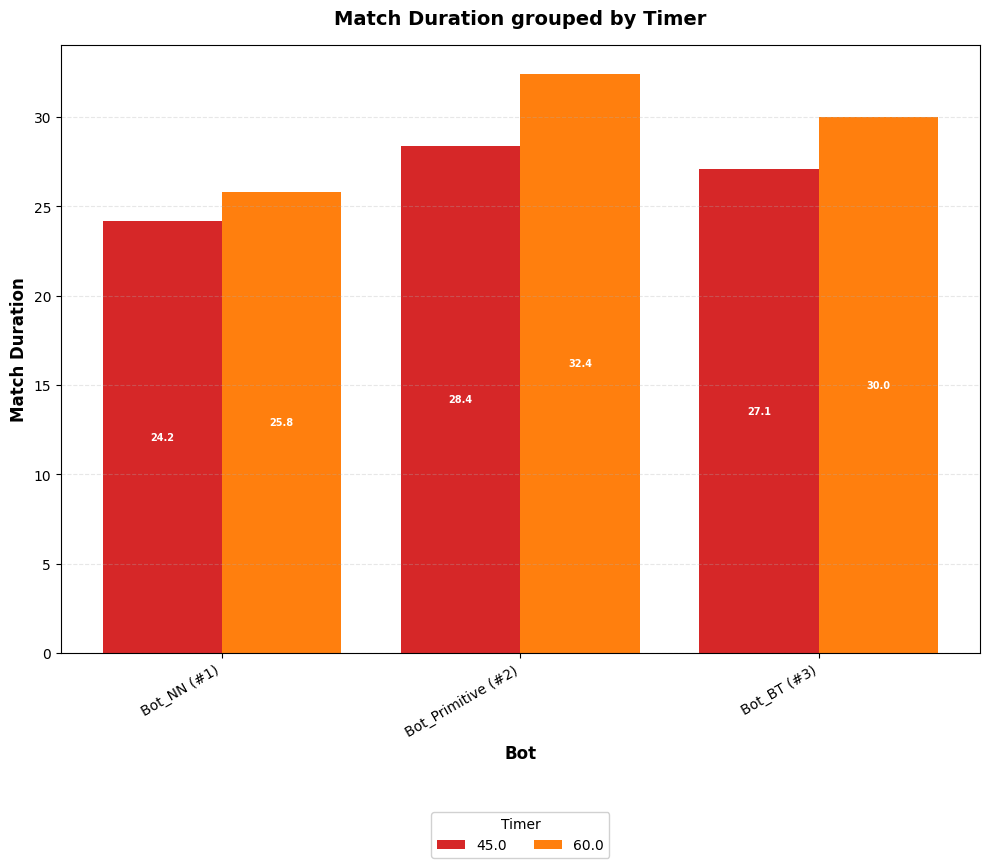

In [147]:
fig = plot_grouped_config_winrates(df, metric="MatchDur", config_col="Timer")
plt.show()

### Match Duration Grouped by Action Interval

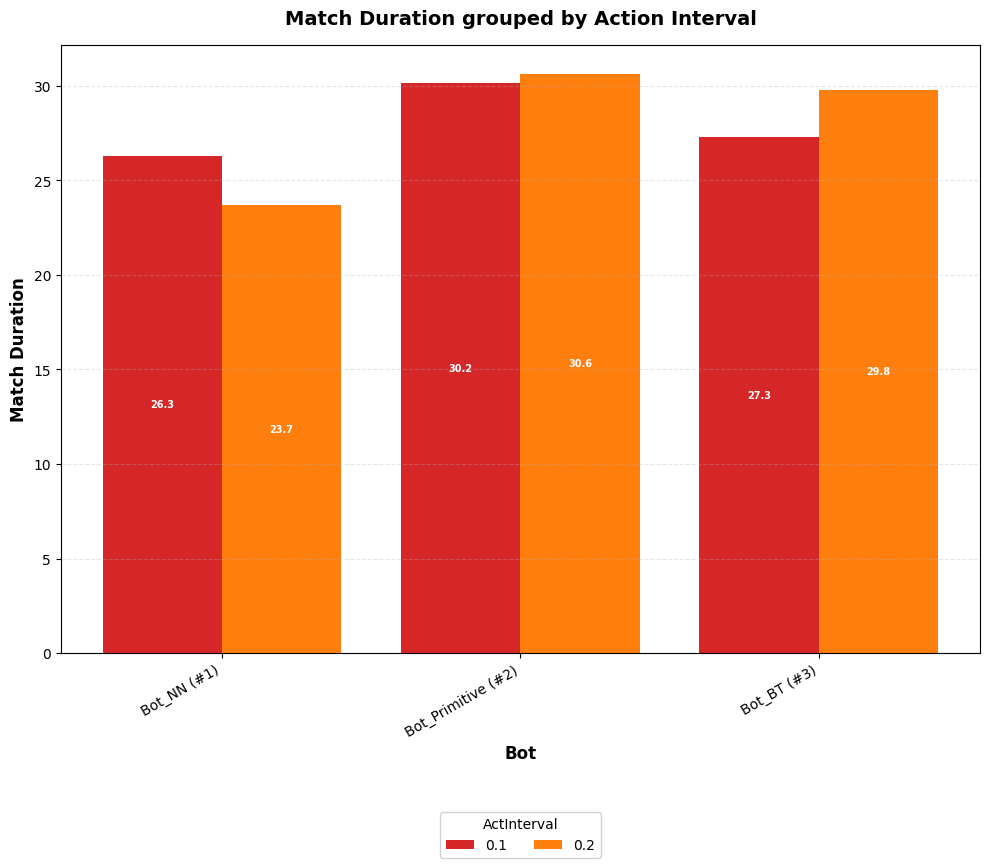

In [148]:
fig = plot_grouped_config_winrates(df, metric="MatchDur", config_col="ActInterval")
plt.show()

### Match Duration Grouped by Round

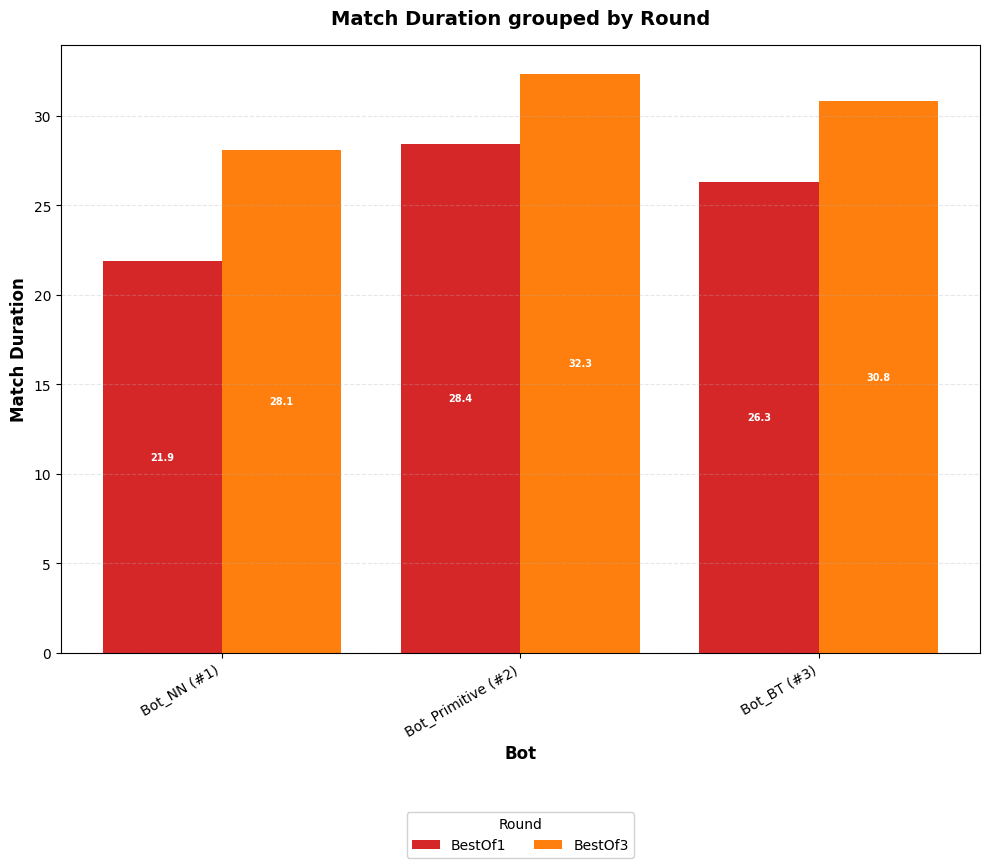

In [149]:
fig = plot_grouped_config_winrates(df, metric="MatchDur", config_col="Round")
plt.show()

### Match Duration Grouped by Skill

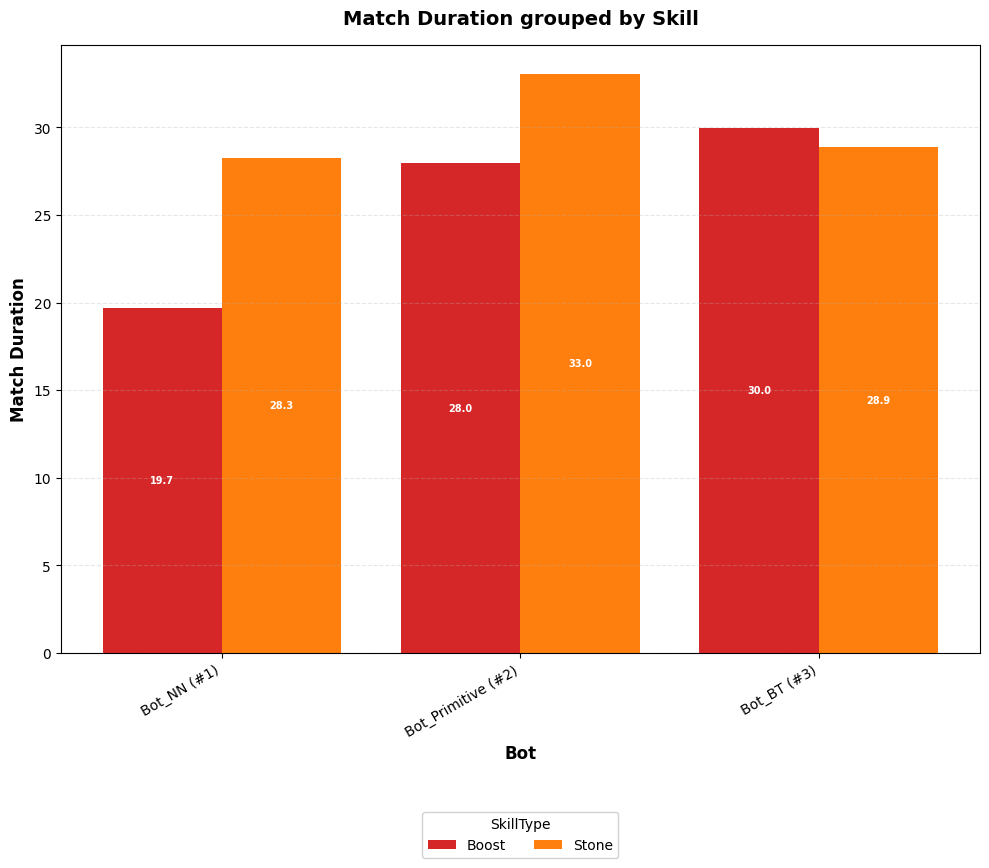

In [150]:
fig = plot_grouped_config_winrates(df, metric="MatchDur", config_col="Skill")
plt.show()

### Time-Related Trends

Analyzes Bots aggressiveness over game duration with determining how much action taken duration related to the overall game duration (Time Setting).
Higher timers don't always lead to longer matches. Some matchups finish fights early regardless of time limit.

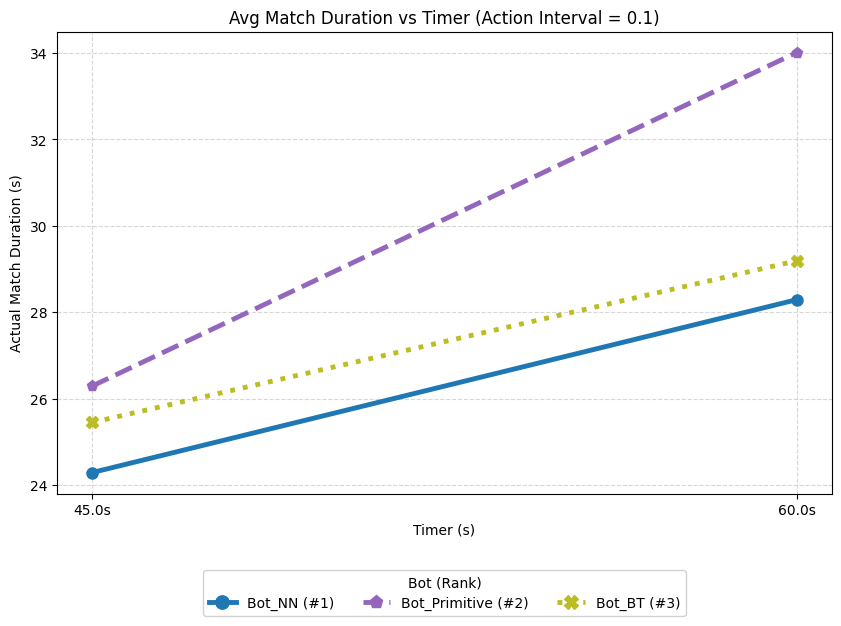

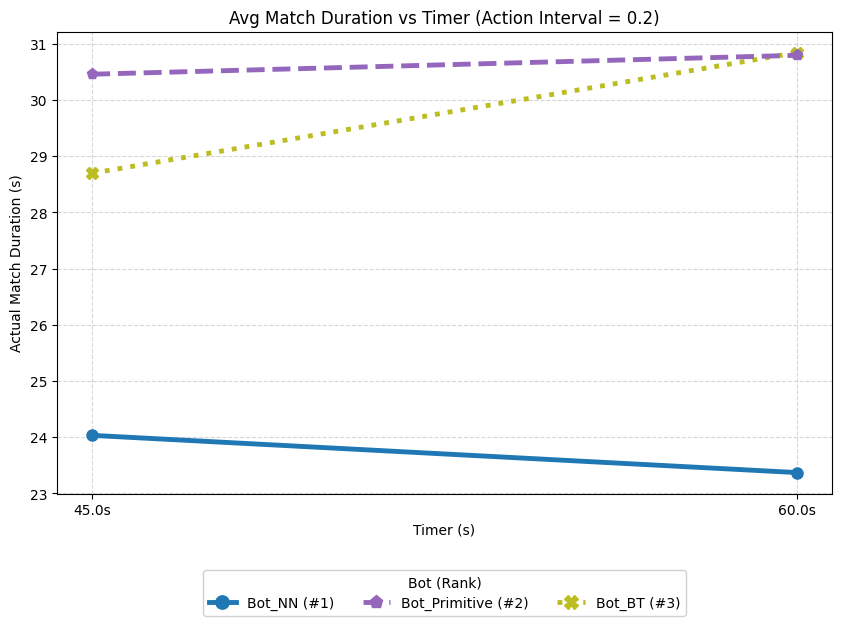

In [151]:
figs = plot_time_related(df, width, height)
for fig in figs:
    plt.show()

### Action Distribution per Bots

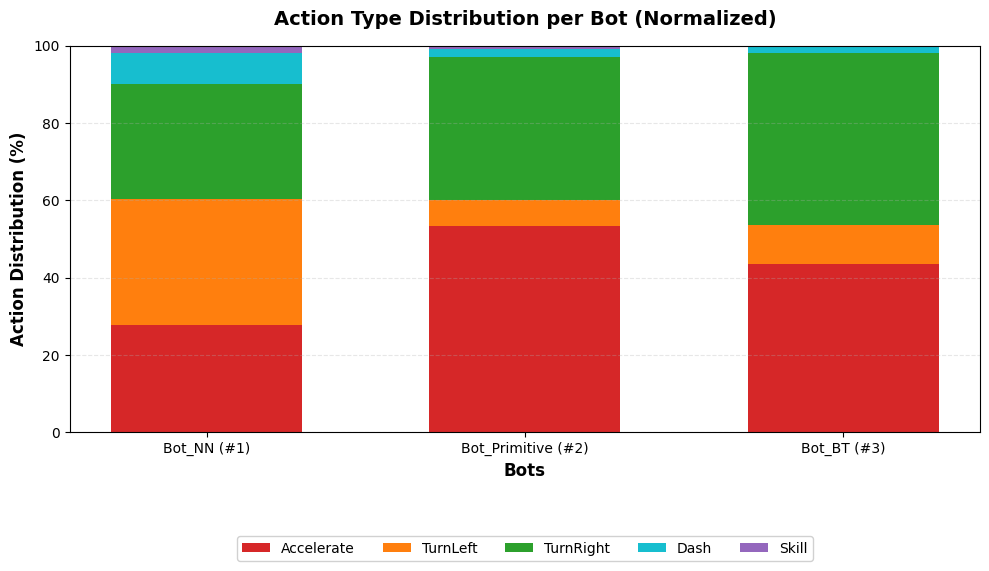

In [152]:
fig = plot_action_distribution_stacked(df, normalize=True)
plt.show()

### Action Intensity Over Time (Per Configuration)

Shows action intensity over time for different timer and action interval configurations


--- Timer=45.0, ActionInterval=0.1 ---


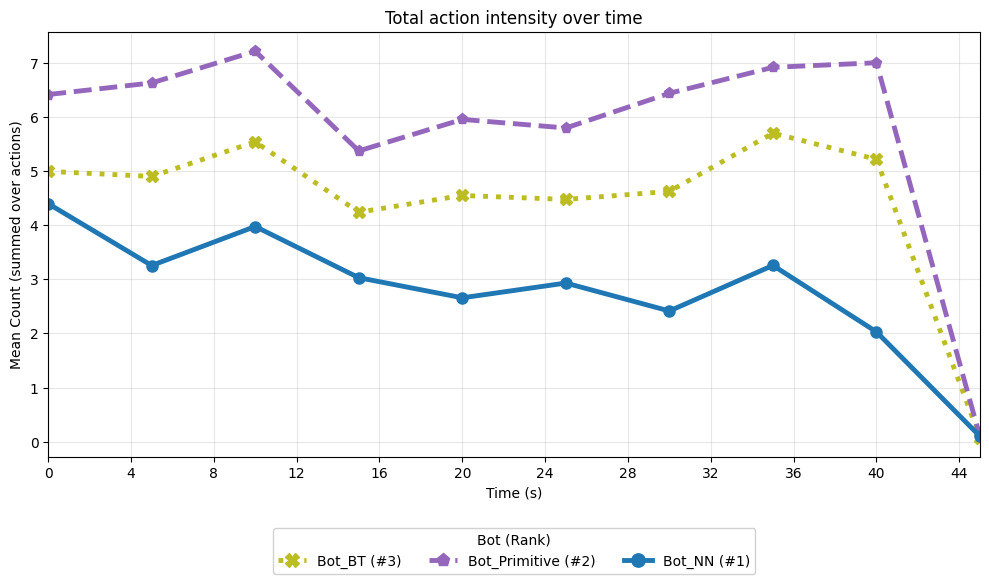

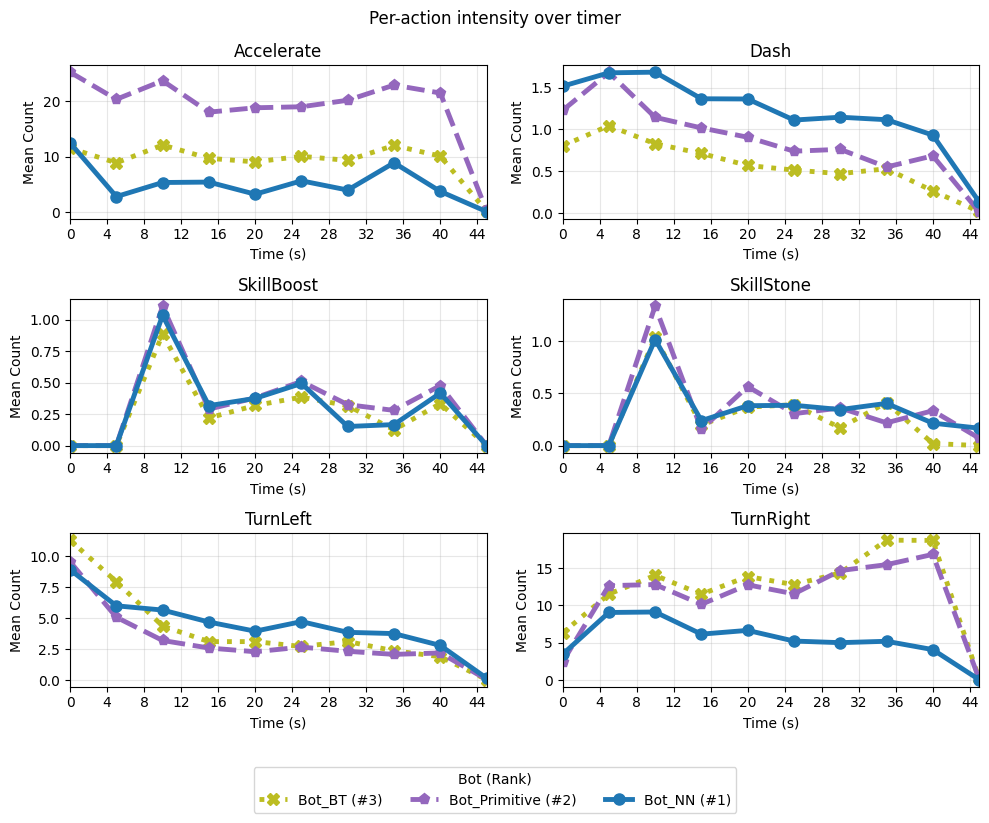


--- Timer=45.0, ActionInterval=0.2 ---


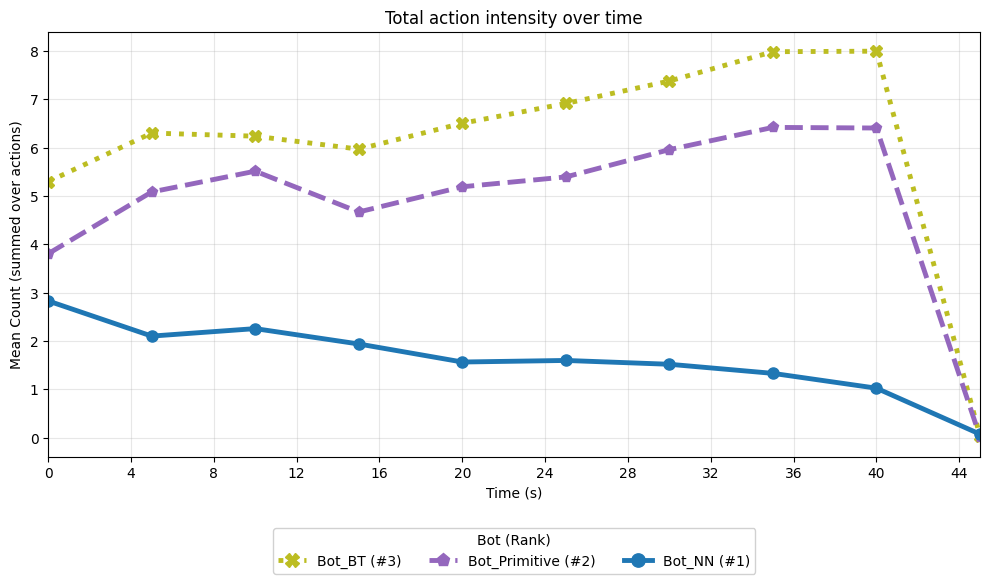

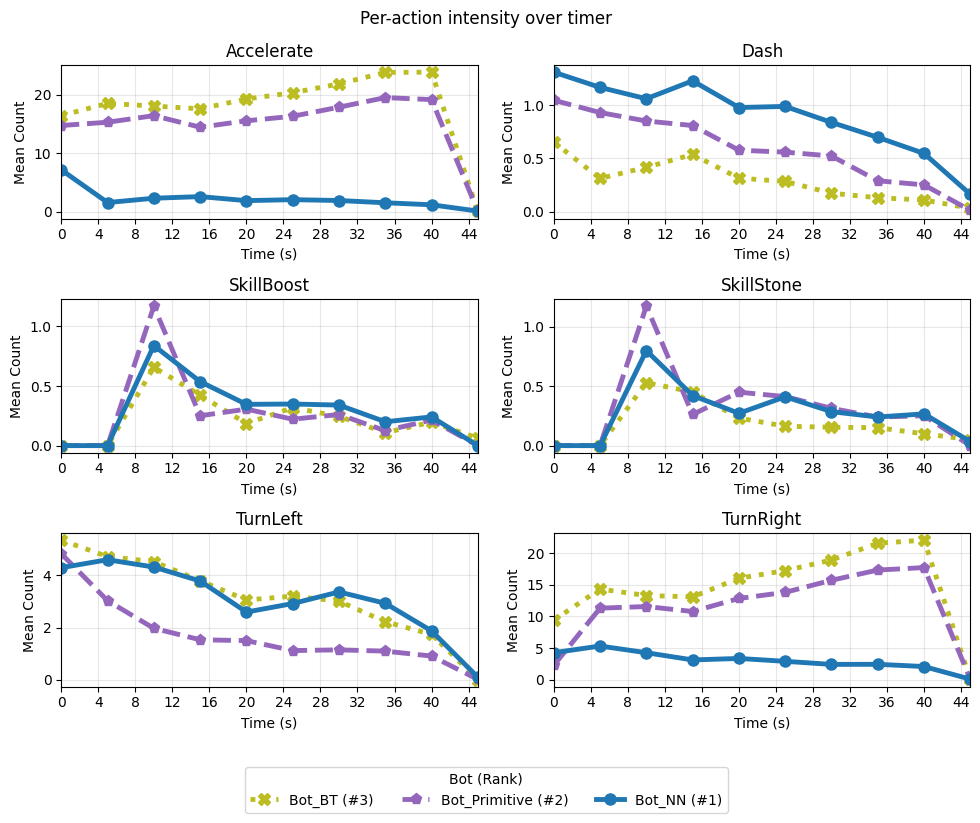


--- Timer=60.0, ActionInterval=0.1 ---


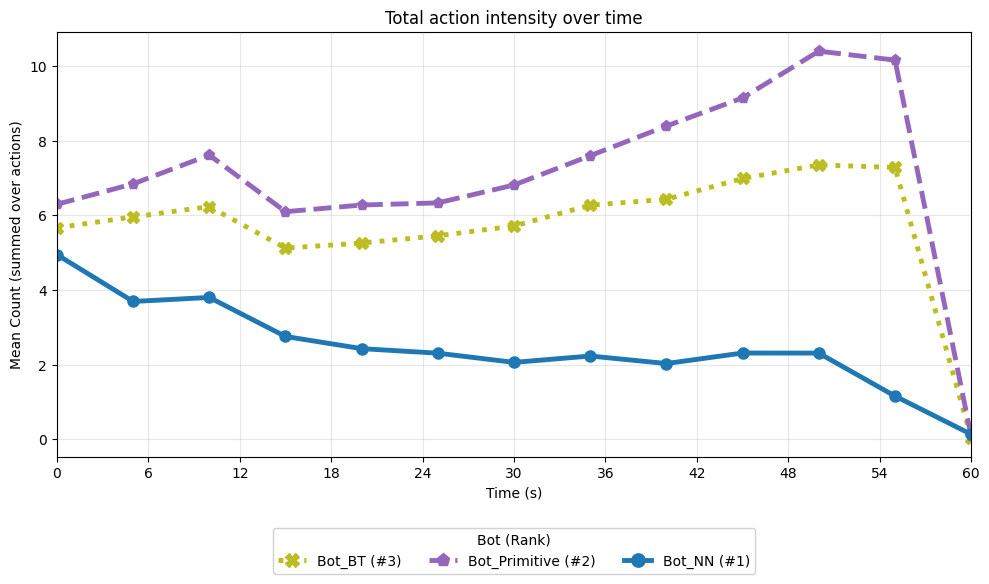

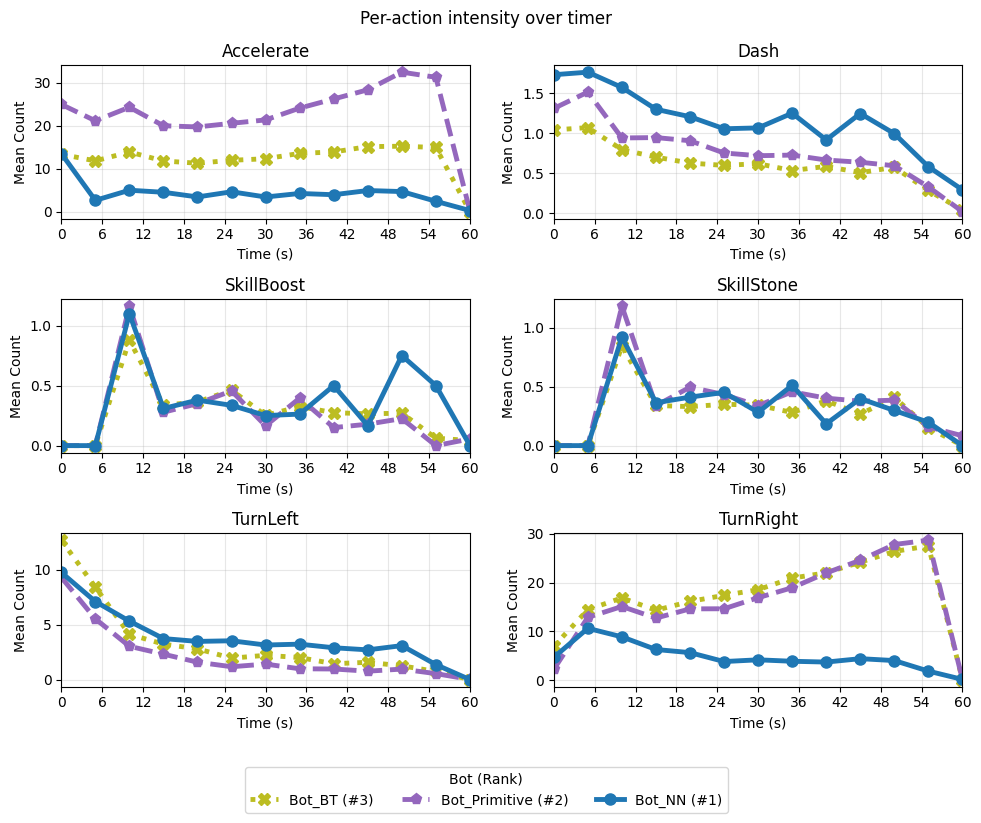


--- Timer=60.0, ActionInterval=0.2 ---


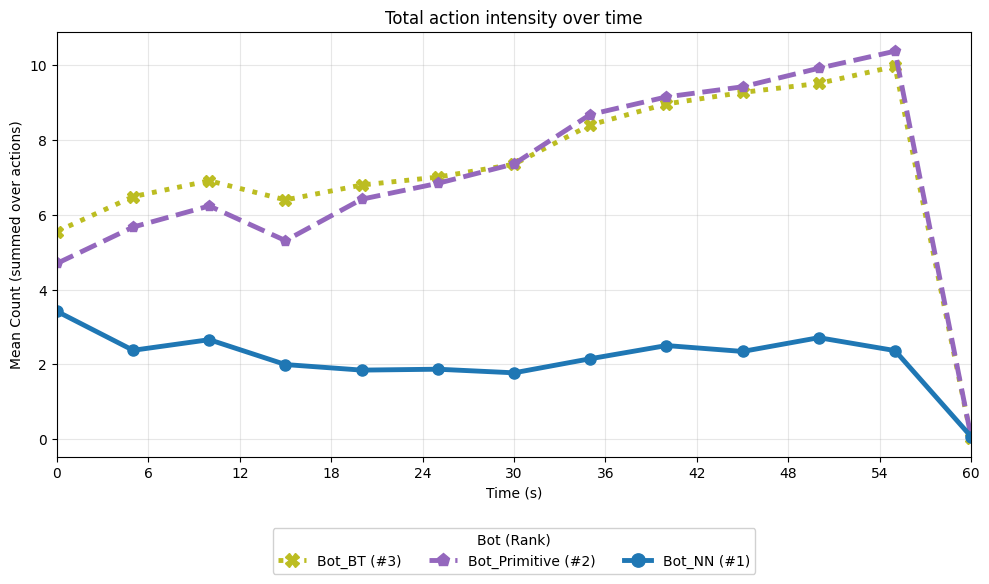

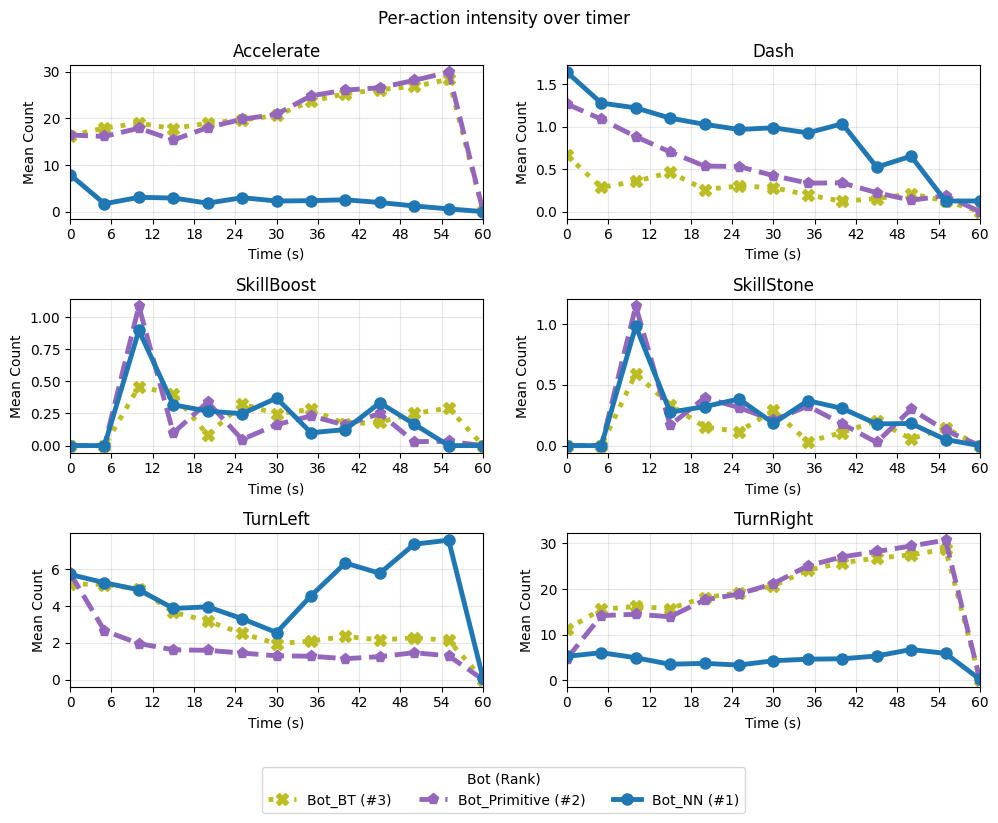

In [153]:
for timI in cfg["Timer"]:
    for actI in cfg["ActInterval"]:
        print(f"\n--- Timer={timI}, ActionInterval={actI} ---")
        
        # Total action intensity
        fig = plot_action_timebins_intensity(df_timebins, timer=timI, act_interval=actI, mode="total", summary_df=df)
        if fig:
            plt.show()
        
        # Per-action intensity
        fig = plot_action_timebins_intensity(df_timebins, timer=timI, act_interval=actI, mode="per_action", summary_df=df)
        if fig:
            plt.show()

### Action Intensity Over All Configuration

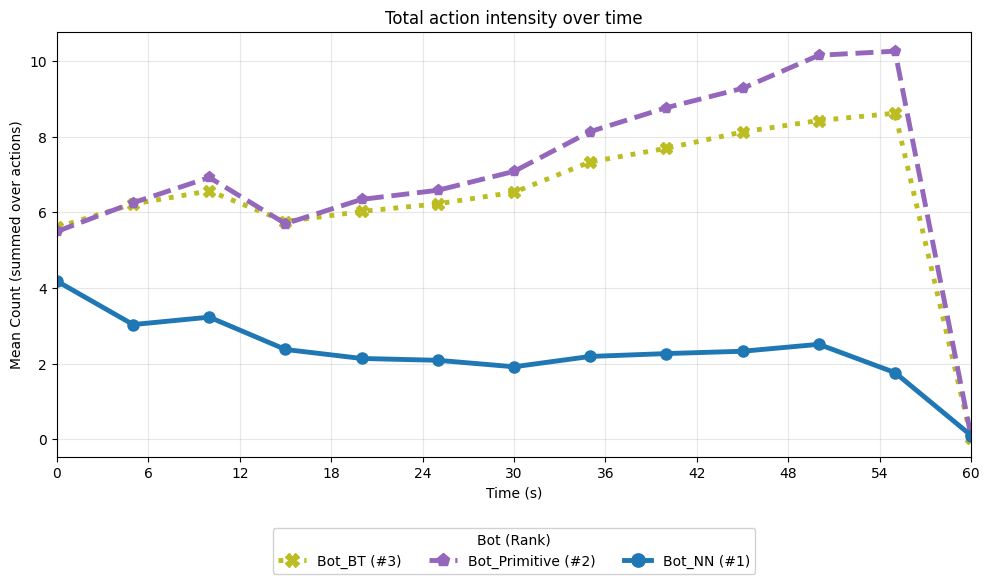

In [154]:
# Total action intensity
fig = plot_action_timebins_intensity(df_timebins, mode="total", timer=60, summary_df=df)
if fig:
    plt.show()

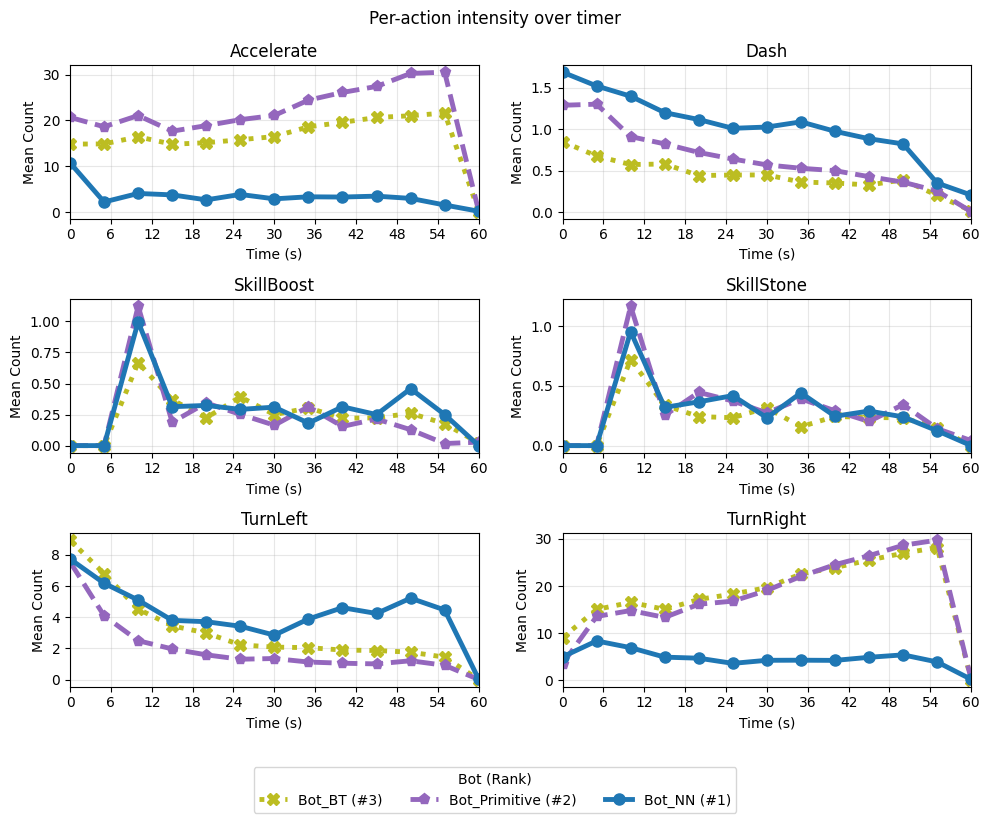

In [155]:
# Per-action intensity
fig = plot_action_timebins_intensity(df_timebins, mode="per_action", timer=60, summary_df=df)
if fig:
    plt.show()

### Collision Intensity Over Time (Per Configuration)

Shows collision intensity over time for different timer and action interval configurations


--- Timer=45.0, ActionInterval=0.1 ---


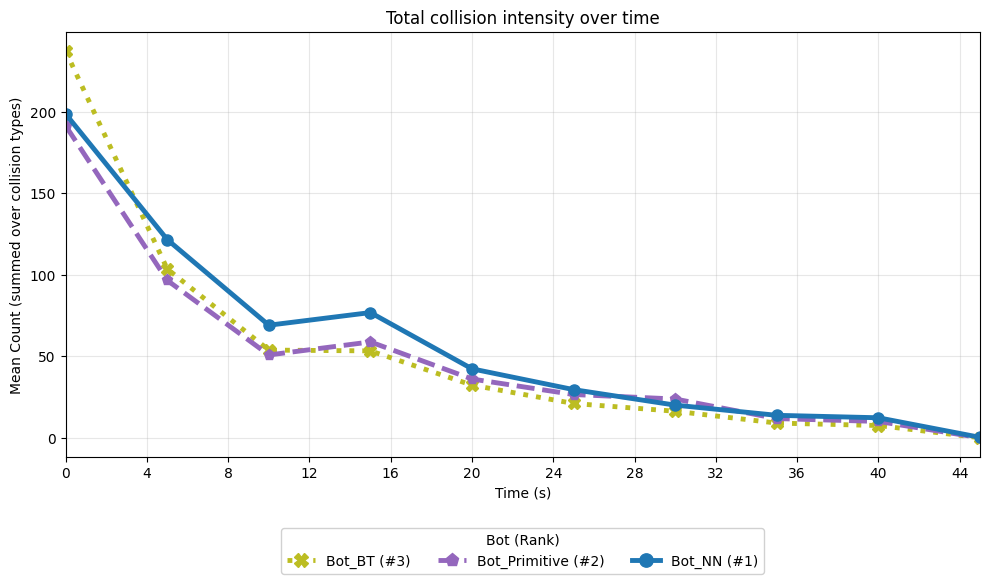

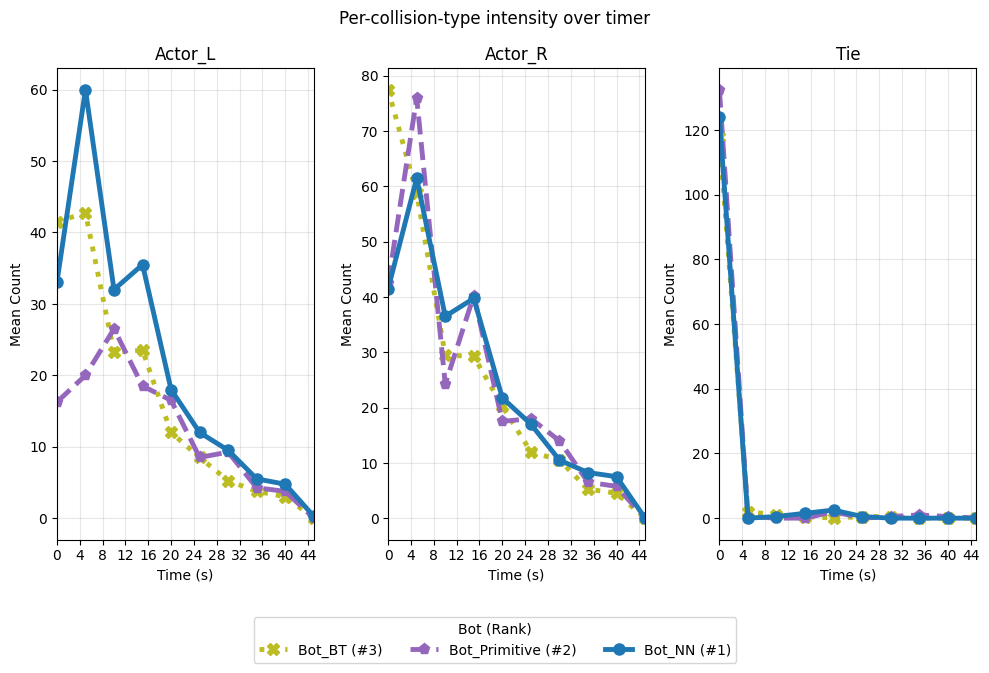


--- Timer=45.0, ActionInterval=0.2 ---


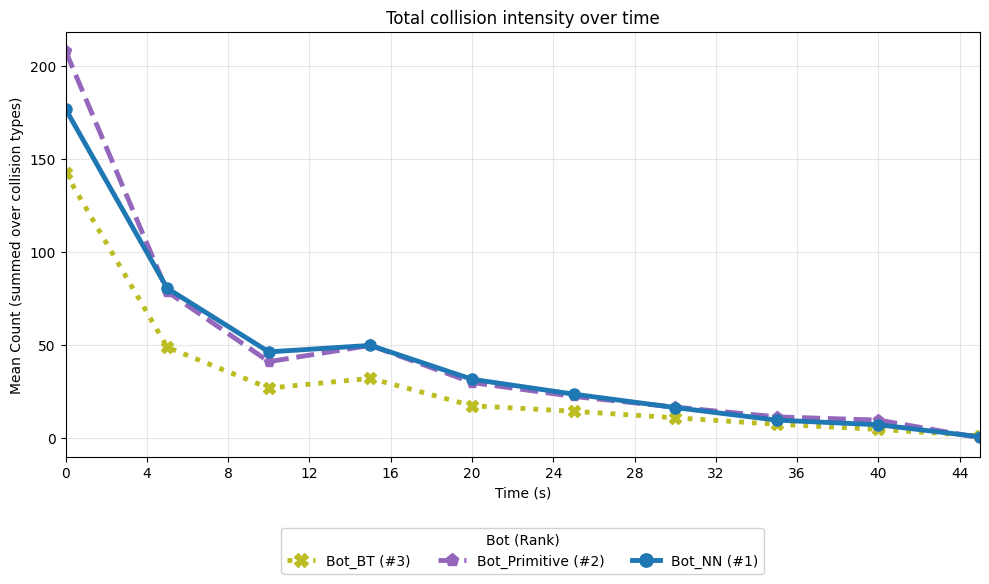

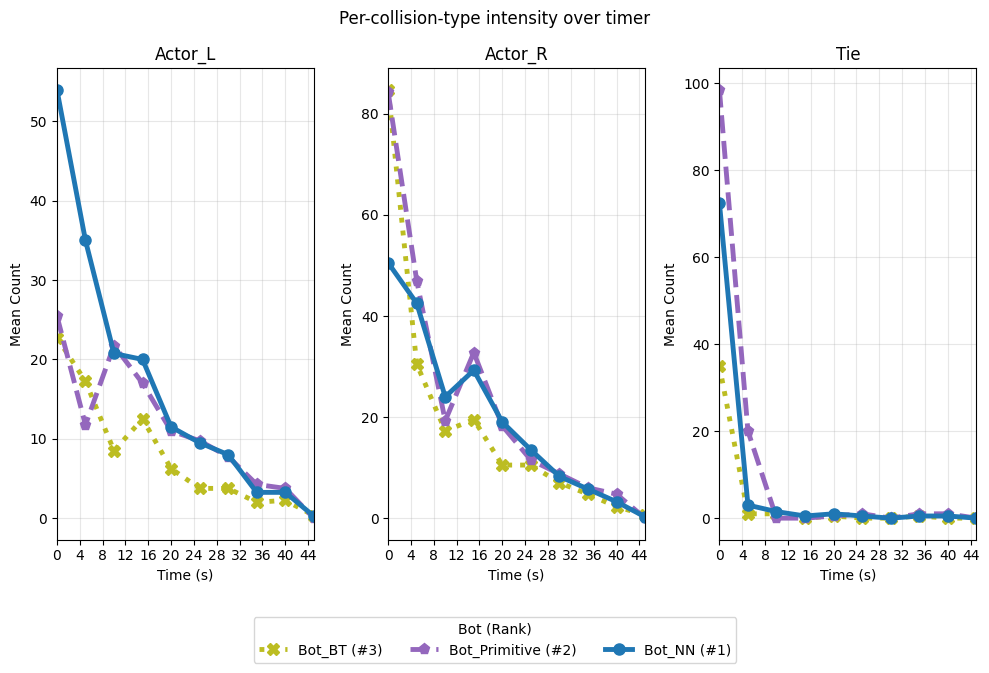


--- Timer=60.0, ActionInterval=0.1 ---


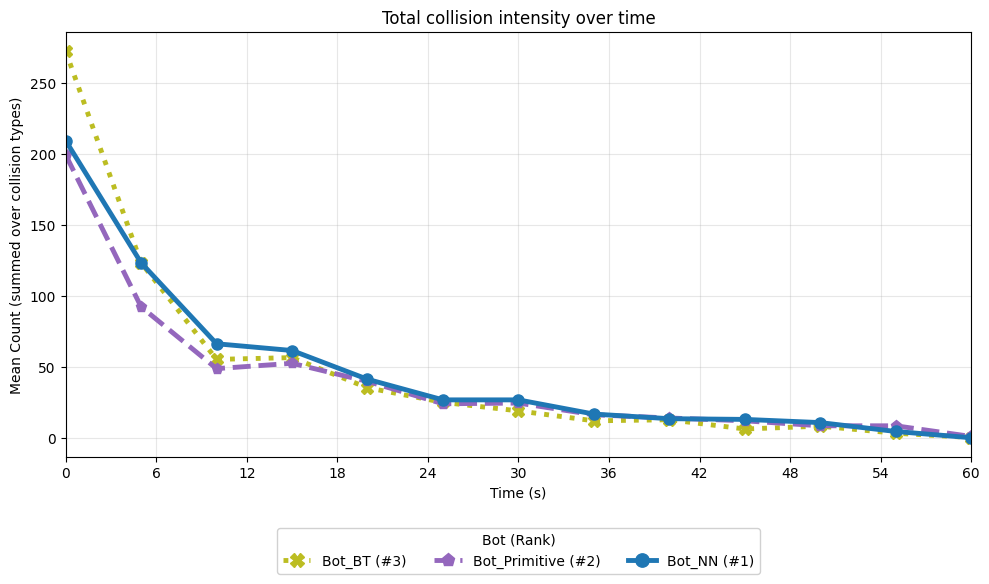

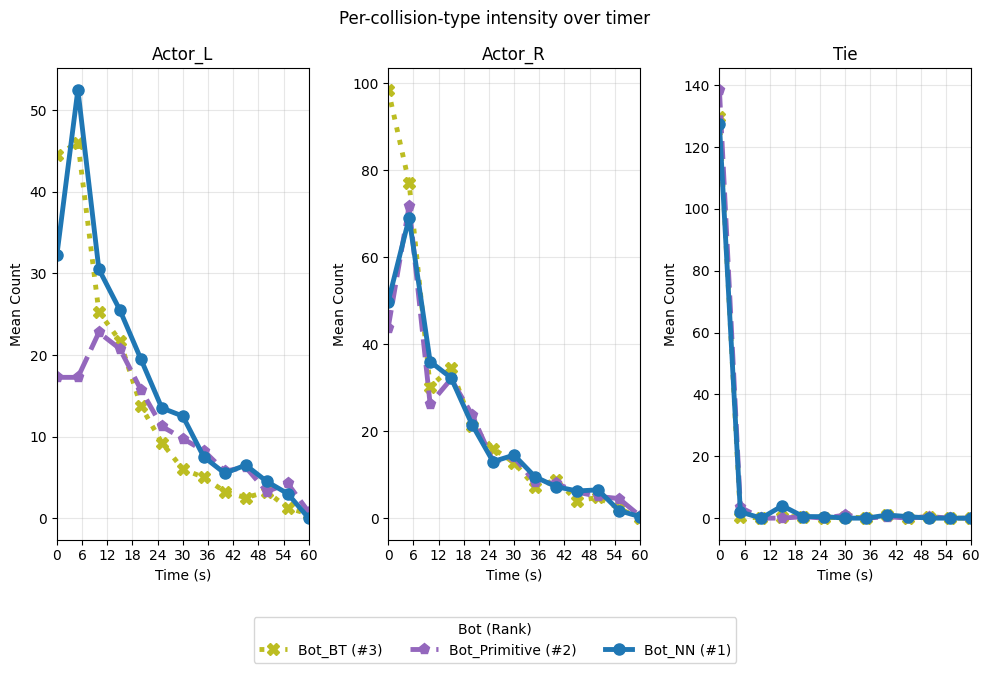


--- Timer=60.0, ActionInterval=0.2 ---


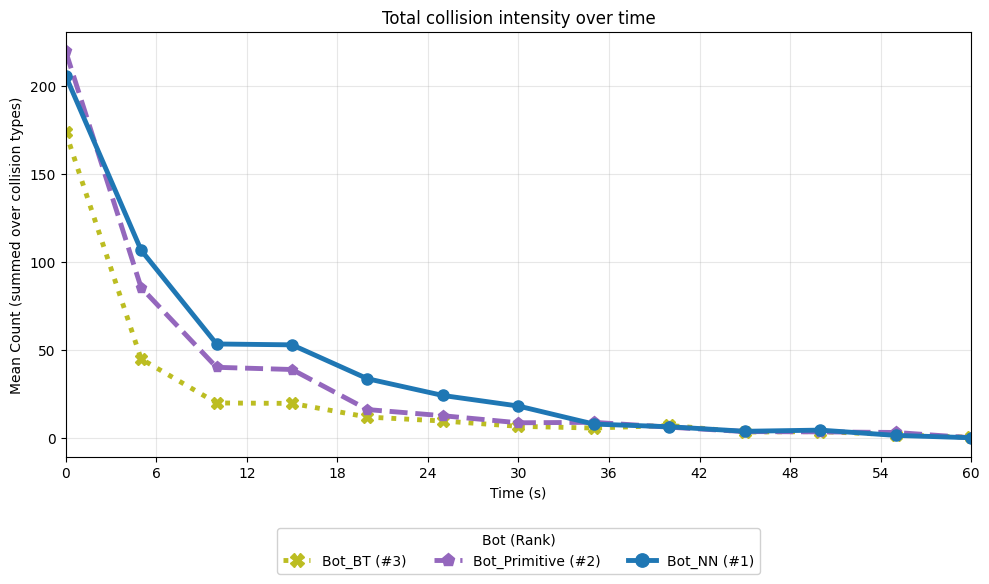

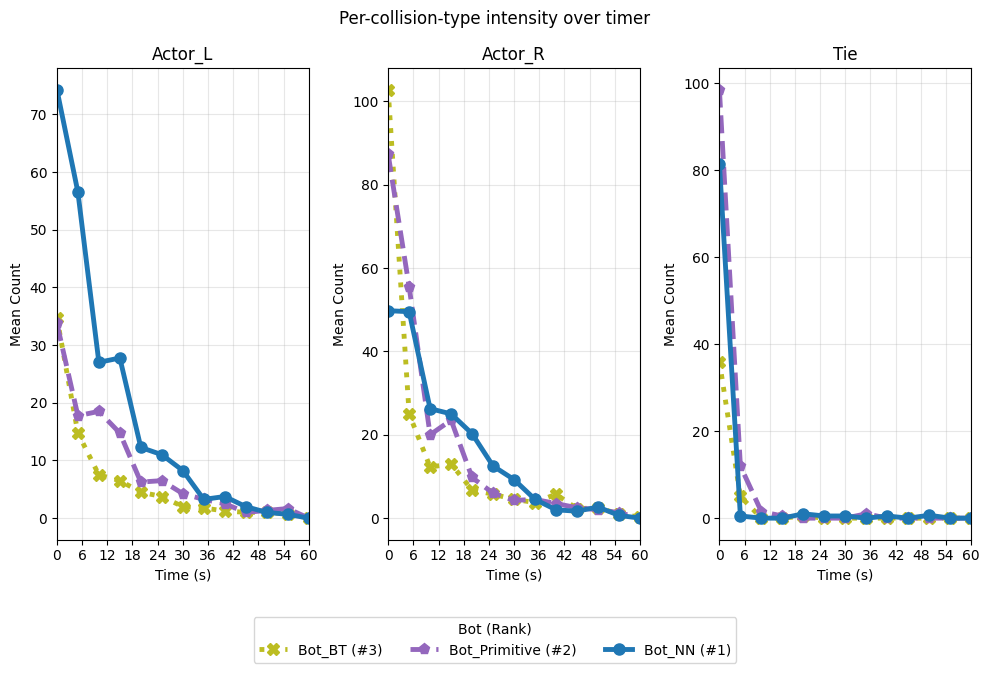

In [156]:
for timI in cfg["Timer"]:
    for actI in cfg["ActInterval"]:
        print(f"\n--- Timer={timI}, ActionInterval={actI} ---")
        
        # Total collision intensity
        fig = plot_collision_timebins_intensity(df_collision_timebins, timer=timI, act_interval=actI, mode="total", summary_df=df)
        if fig:
            plt.show()
        
        # Per-type collision intensity
        fig = plot_collision_timebins_intensity(df_collision_timebins, timer=timI, act_interval=actI, mode="per_type", summary_df=df)
        if fig:
            plt.show()

### Collision Detail Distribution per Bots

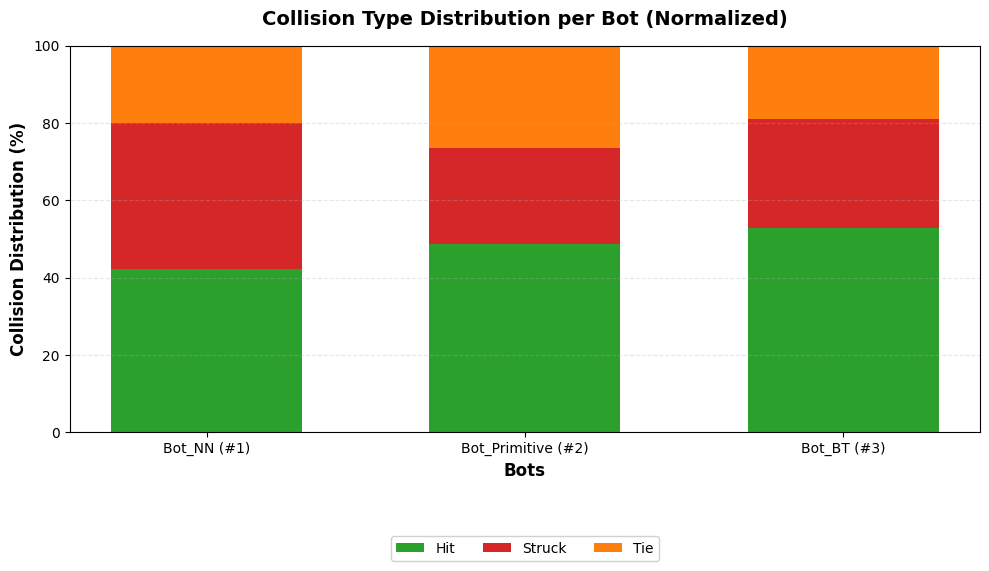

In [157]:
fig = plot_collision_distribution_stacked(df, normalize=True)
plt.show()

### Collision Intensity Over All Configuration

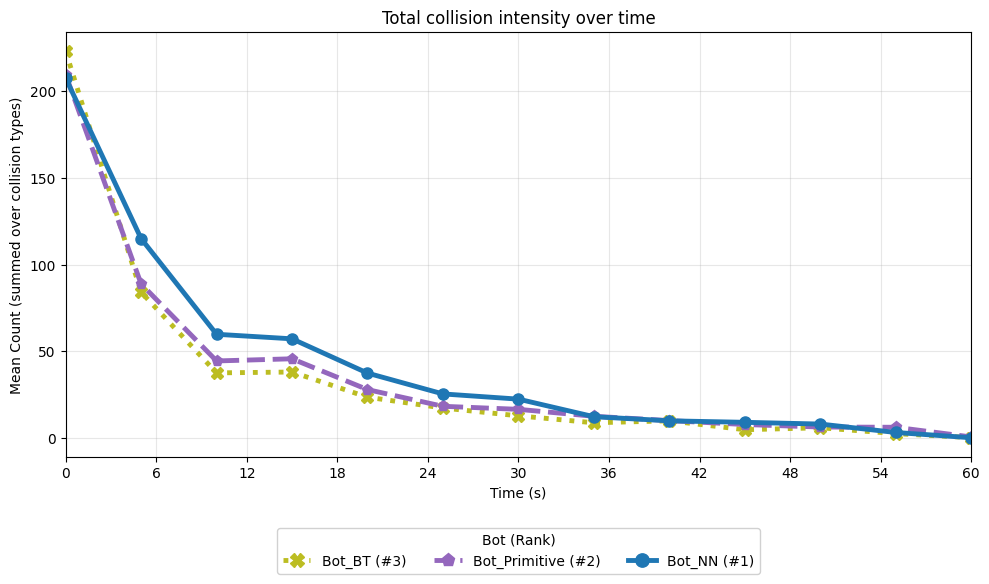

In [158]:
# Total collision intensity
fig = plot_collision_timebins_intensity(df_collision_timebins, mode="total", timer=60, summary_df=df)
if fig:
    plt.show()

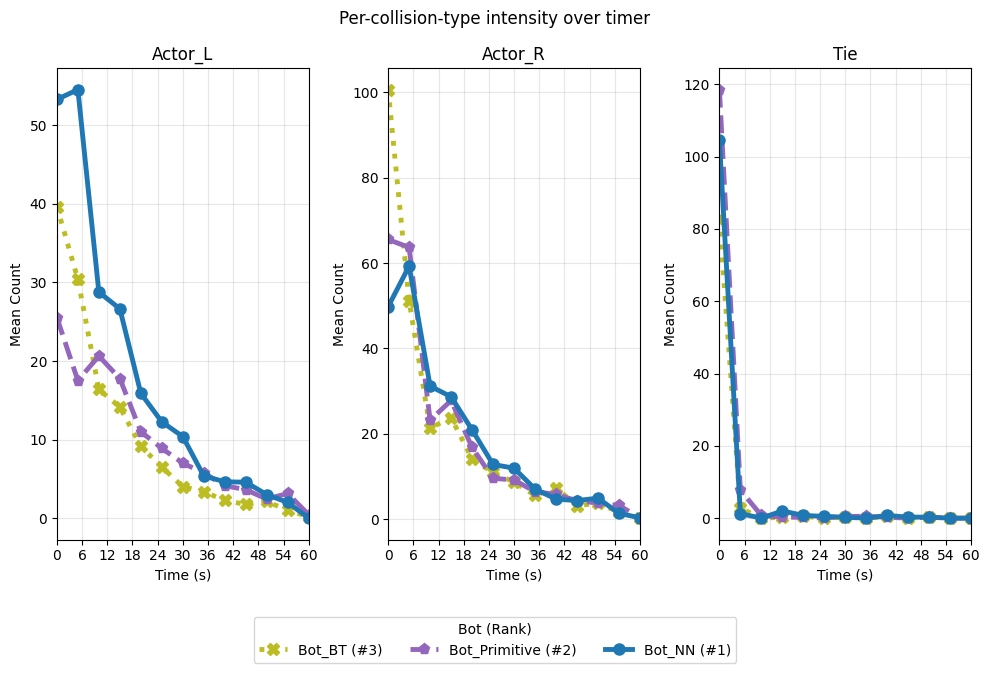

In [159]:
# Per-type collision intensity
fig = plot_collision_timebins_intensity(df_collision_timebins, mode="per_type", timer=60, summary_df=df)
if fig:
    plt.show()

### Action Taken vs. Win Relation

Does spending most action (aggressive) lead to a win?
This taking mean of action-taken per games versus win-rate

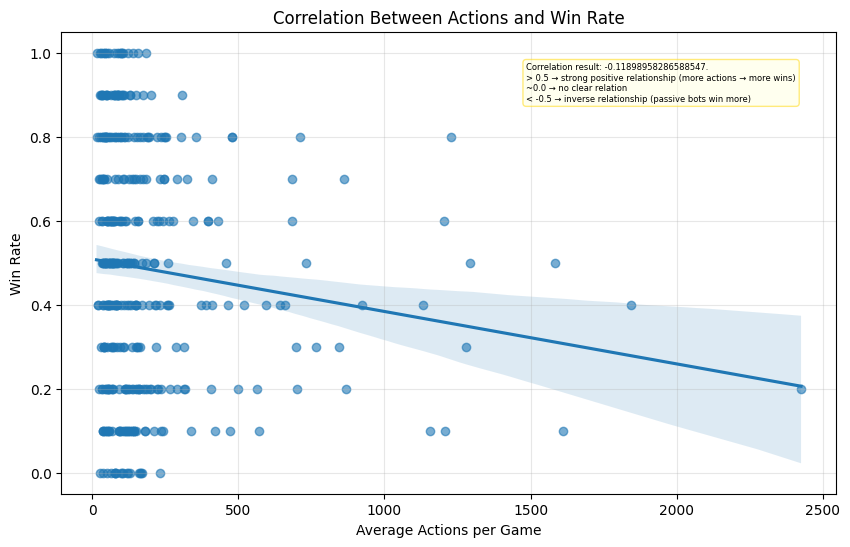

In [160]:
fig = plot_action_win_related(df, width, height)
plt.show()

### Pearson Correlation Analysis (Overall)

Correlation analysis using Pearson coefficient with scatter plots and regression lines.
All data from all bots combined, separated by configuration

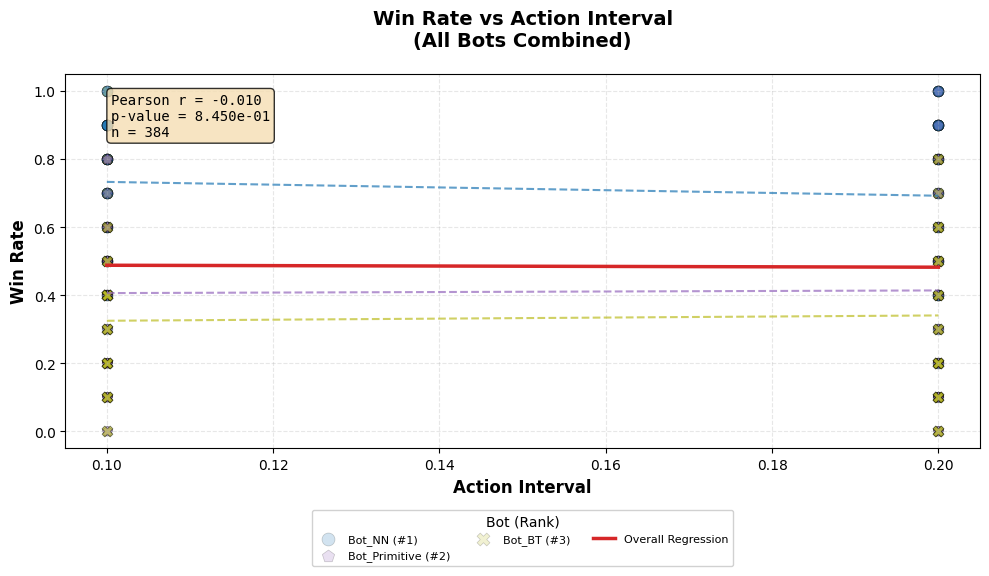

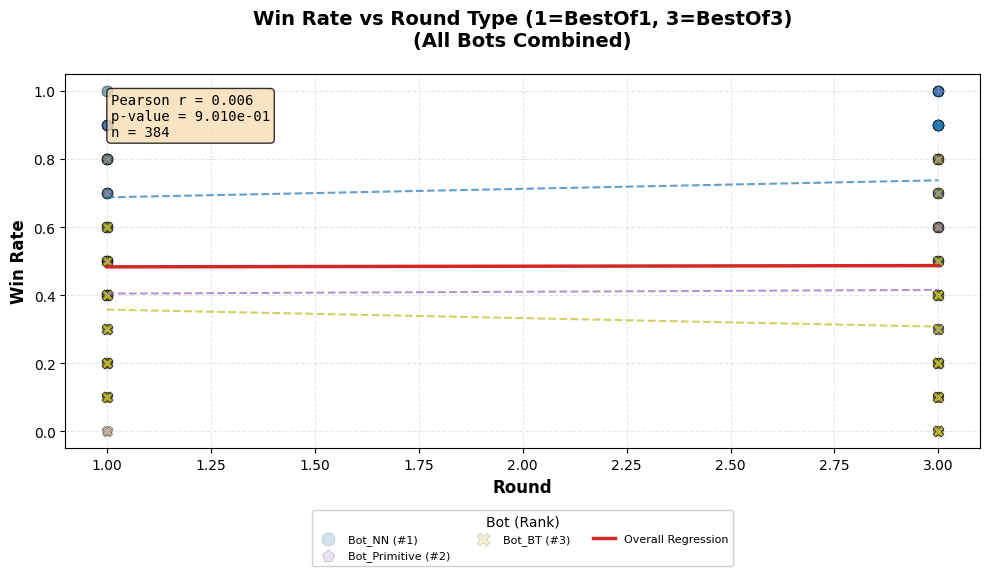

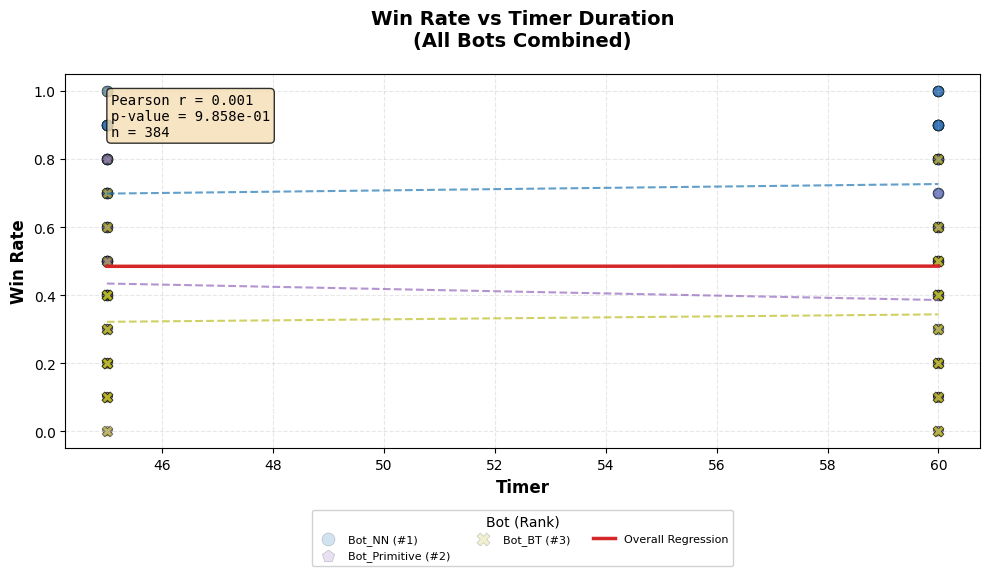

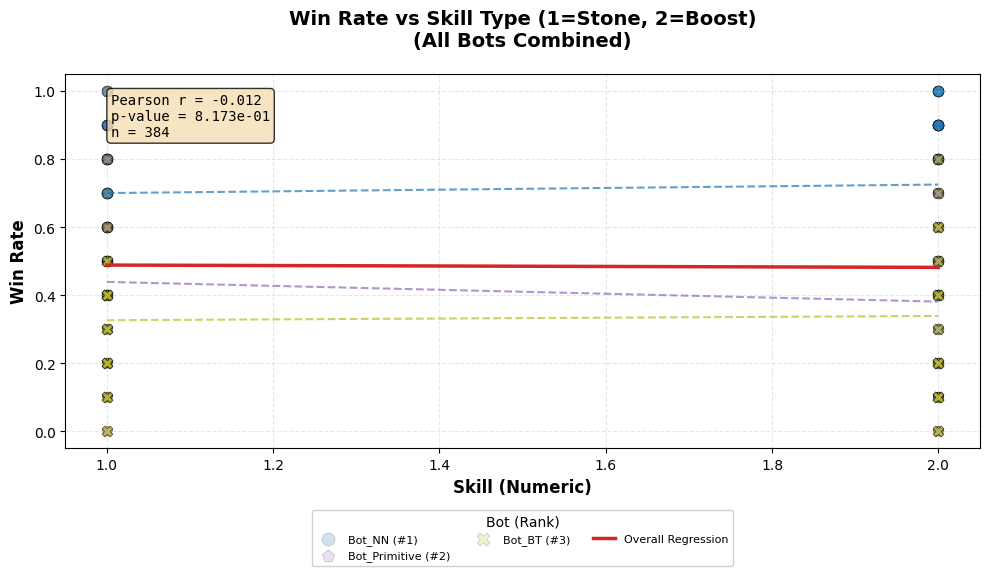

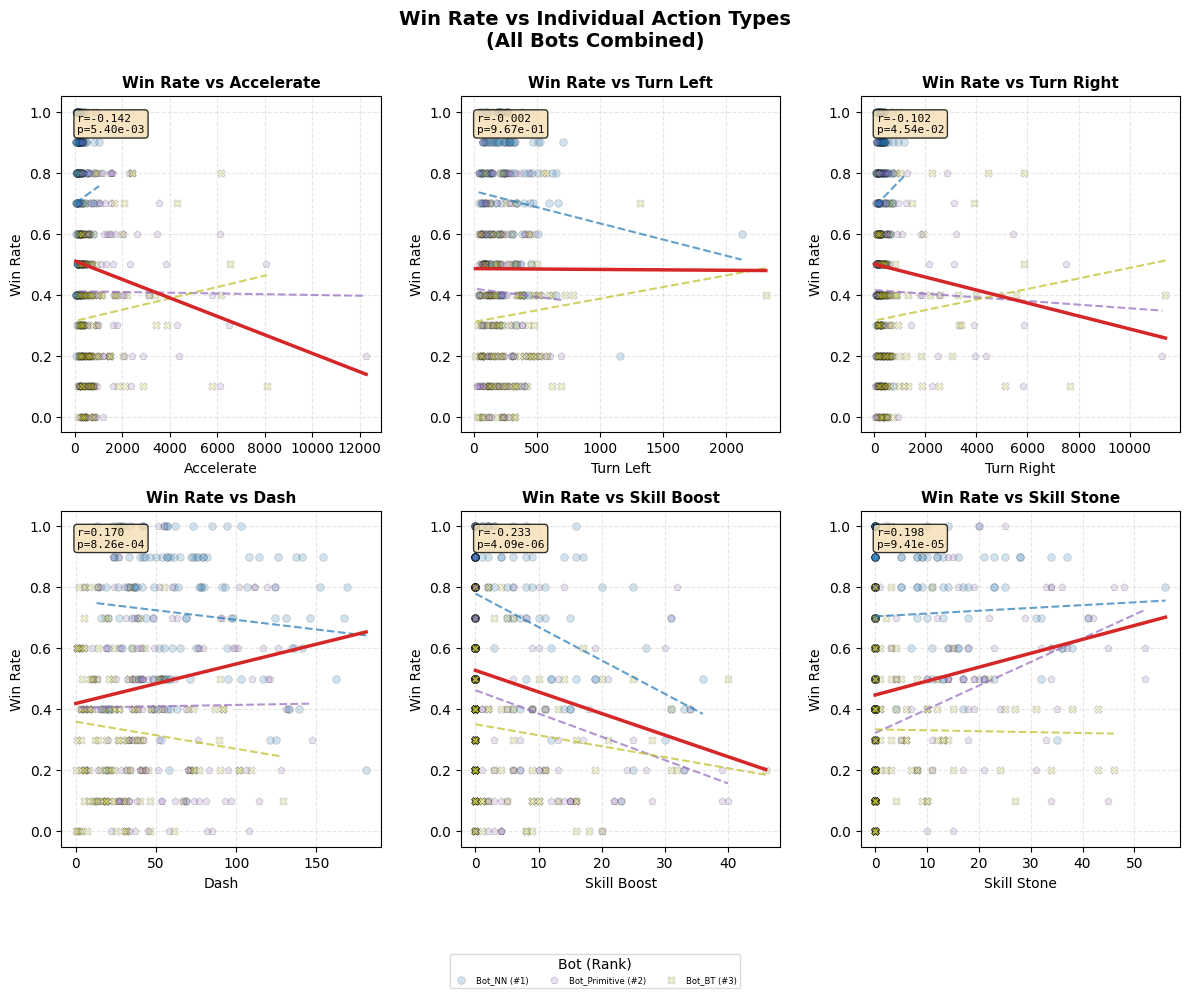

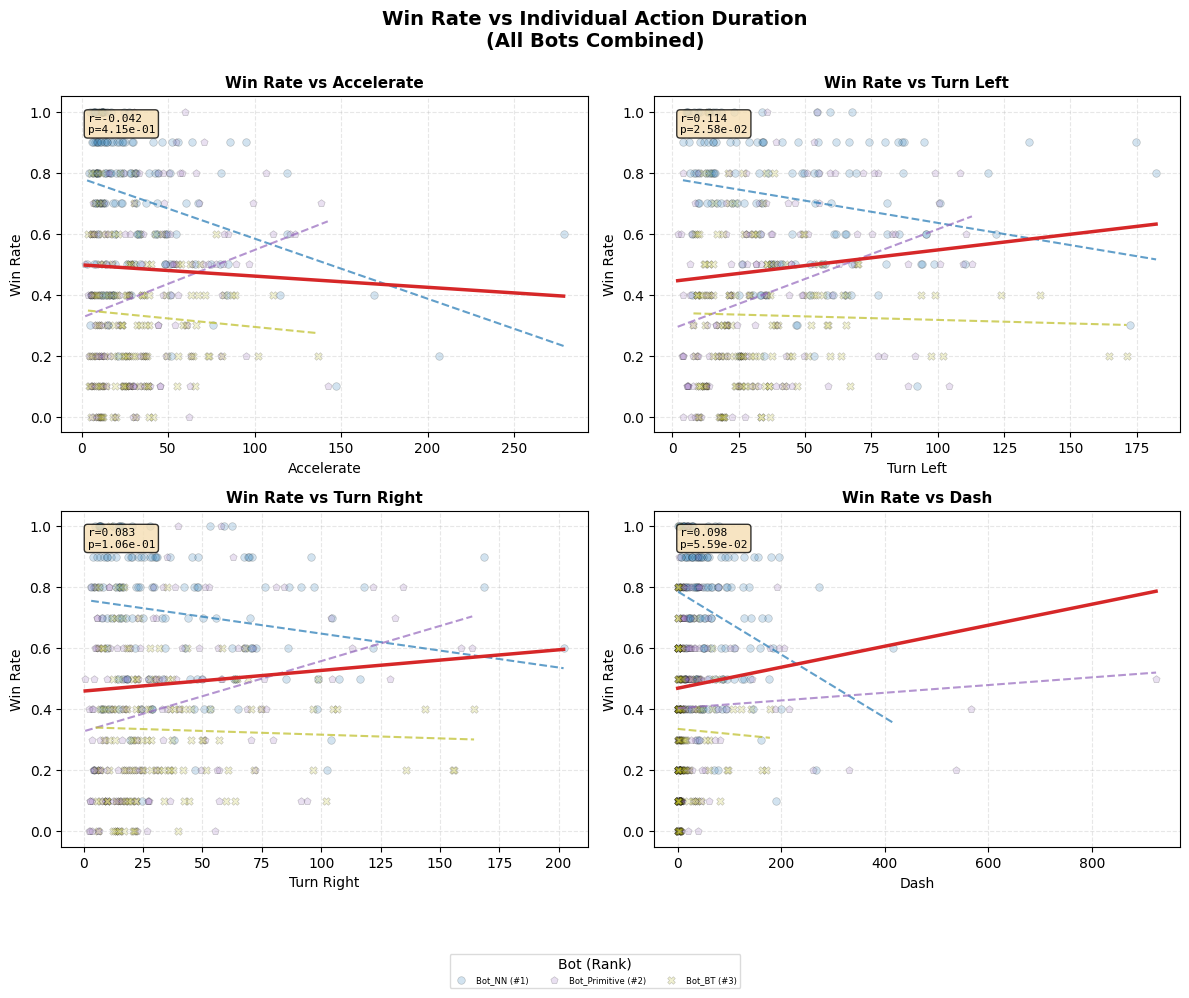

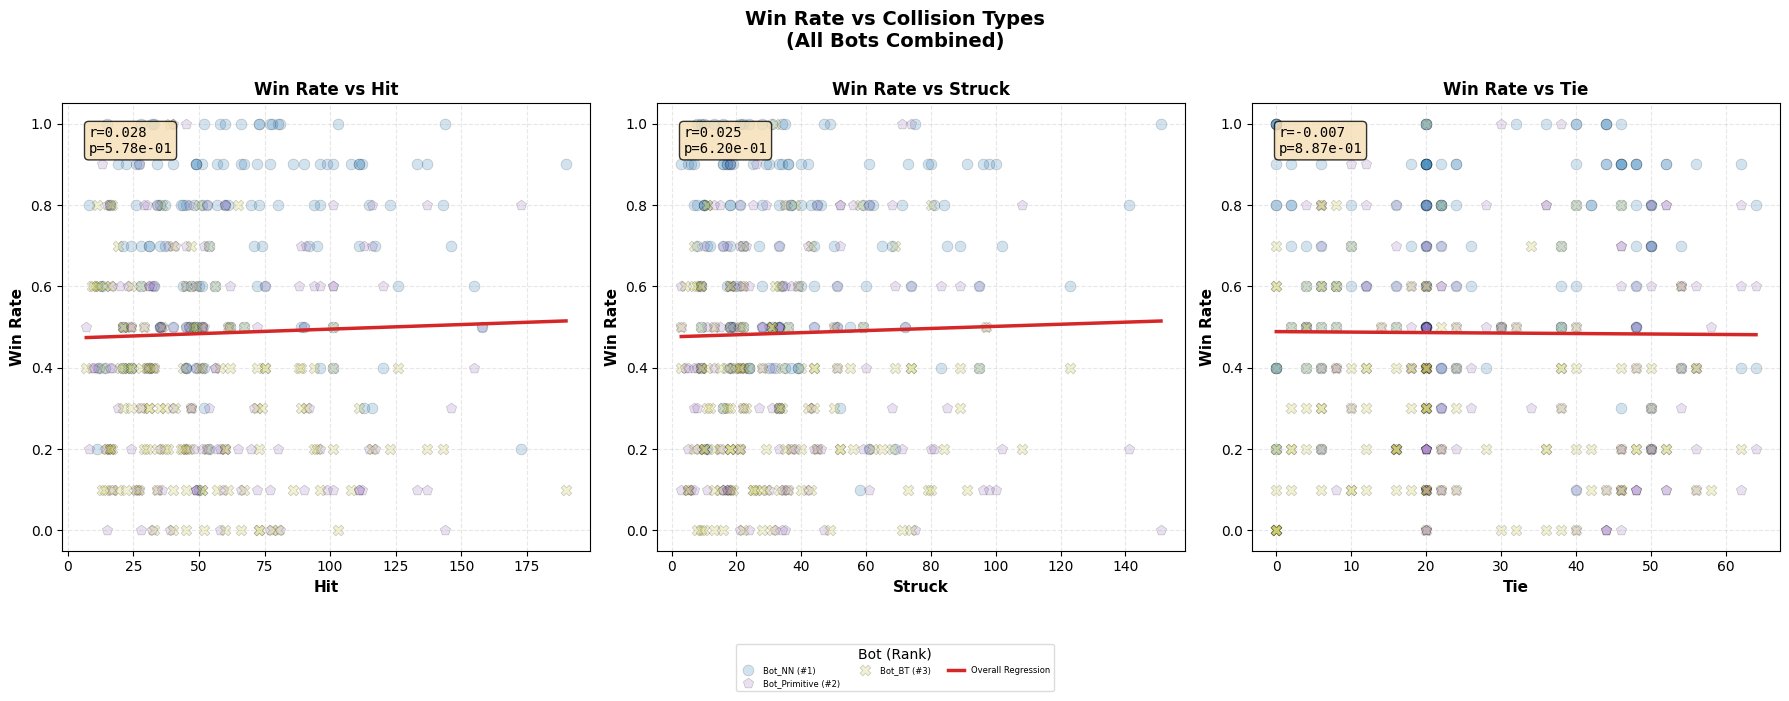

In [161]:
correlation_figs = plot_all_correlations(df, width, height)

## Individual Bot Analysis

Analyze bot agent against its different configurations.
Each of report: Win Rate; Collision; Action-Taken; Duration; is calculated with averaging data from matchup (left and right position)

### Pearson Correlation Analysis (Per Bot)

Detailed plots for individual bots, separated by configuration

Analyzing 3 bots: ['Bot_BT', 'Bot_NN', 'Bot_Primitive']

Analyzing correlations for Bot_BT

--- Win Rate vs Action Interval Configuration ---


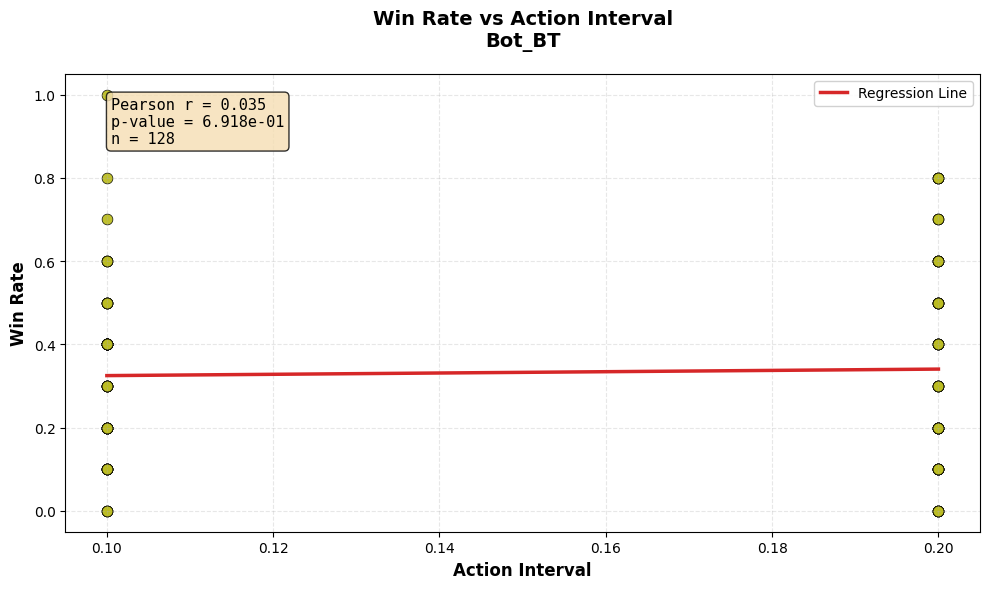

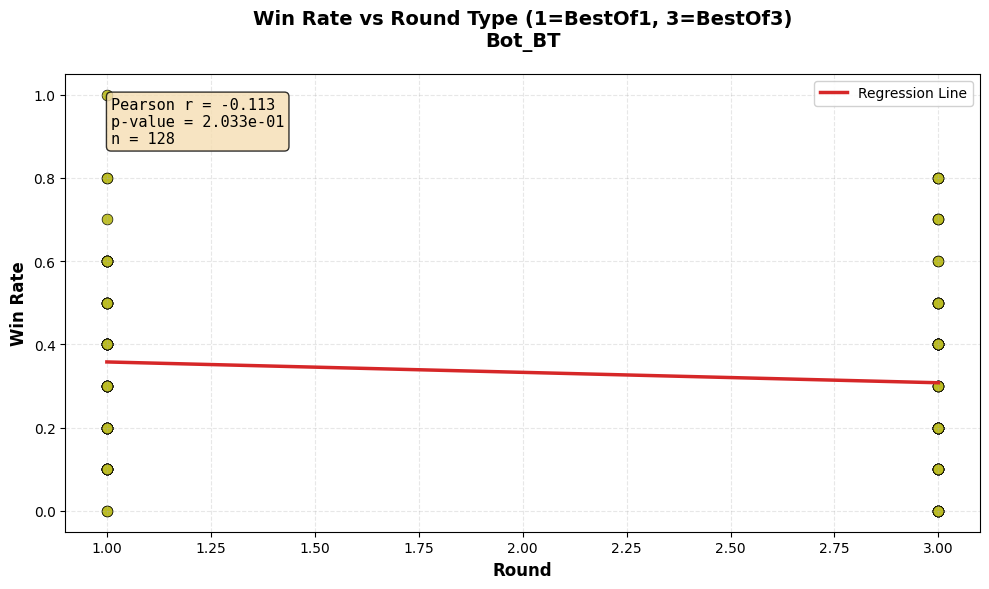

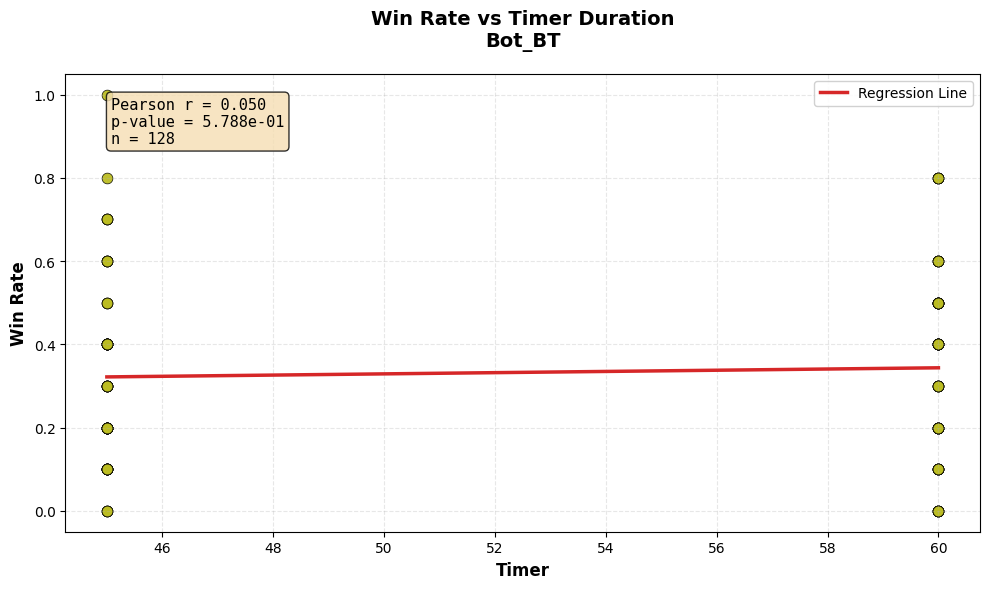

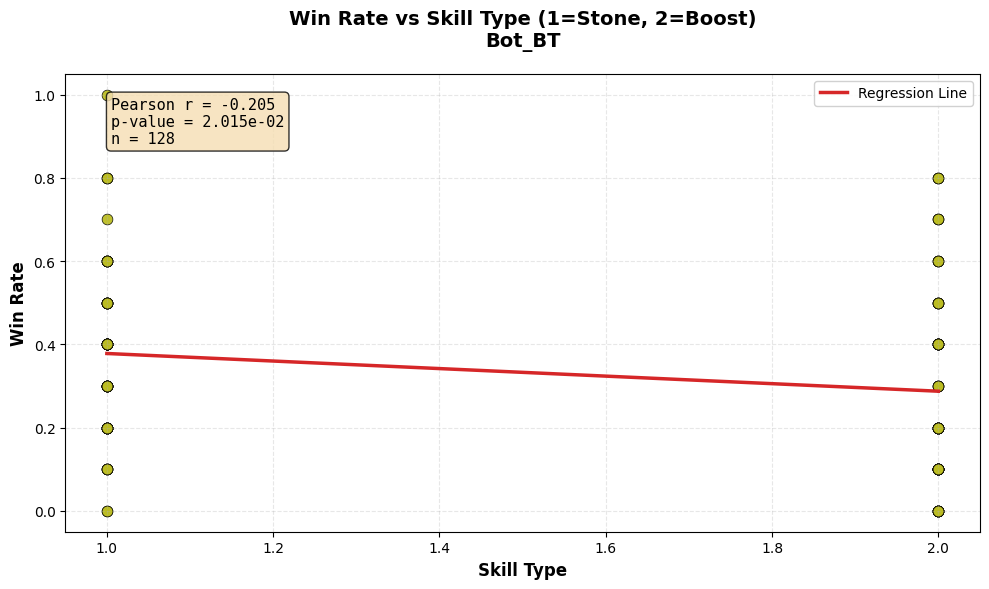

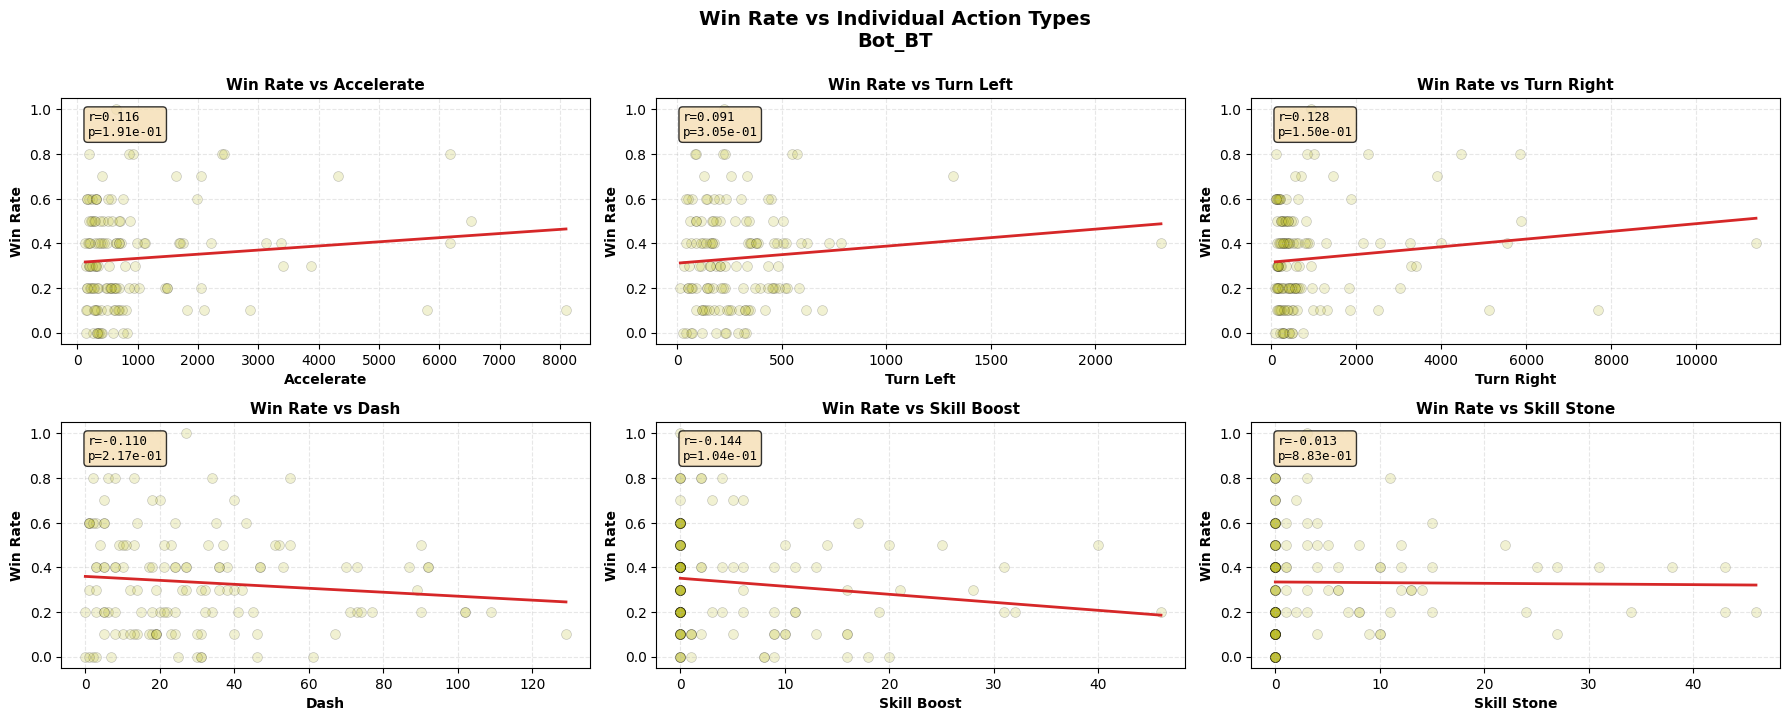

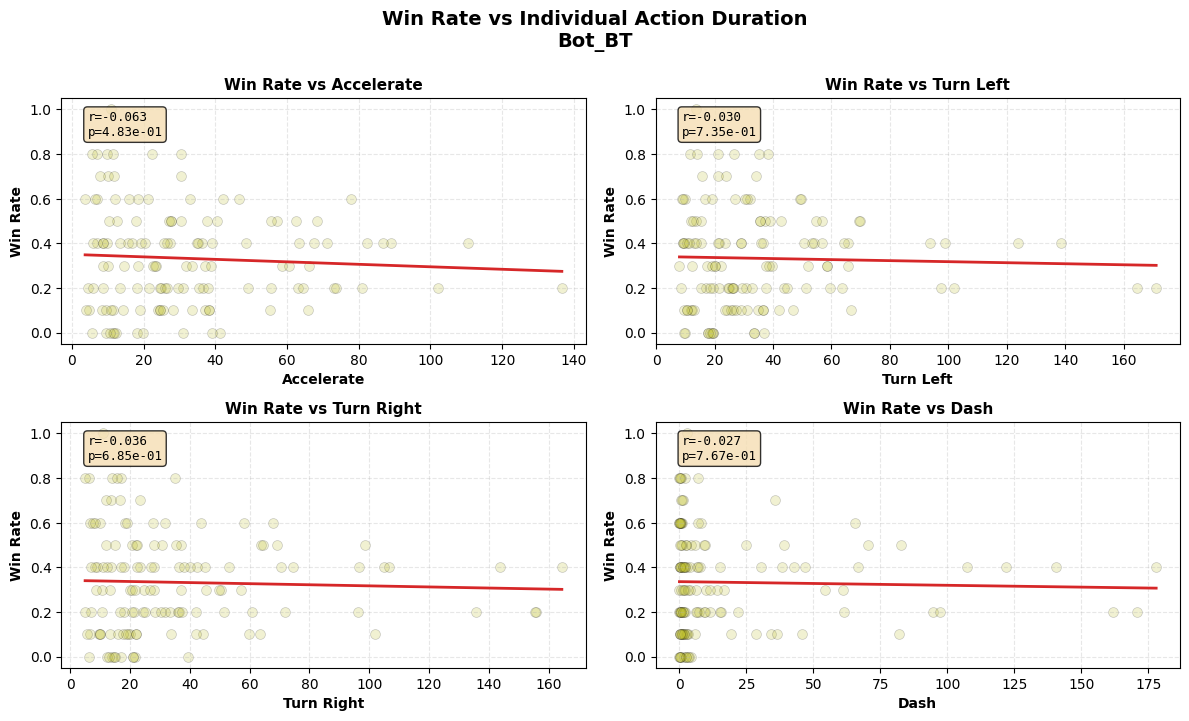

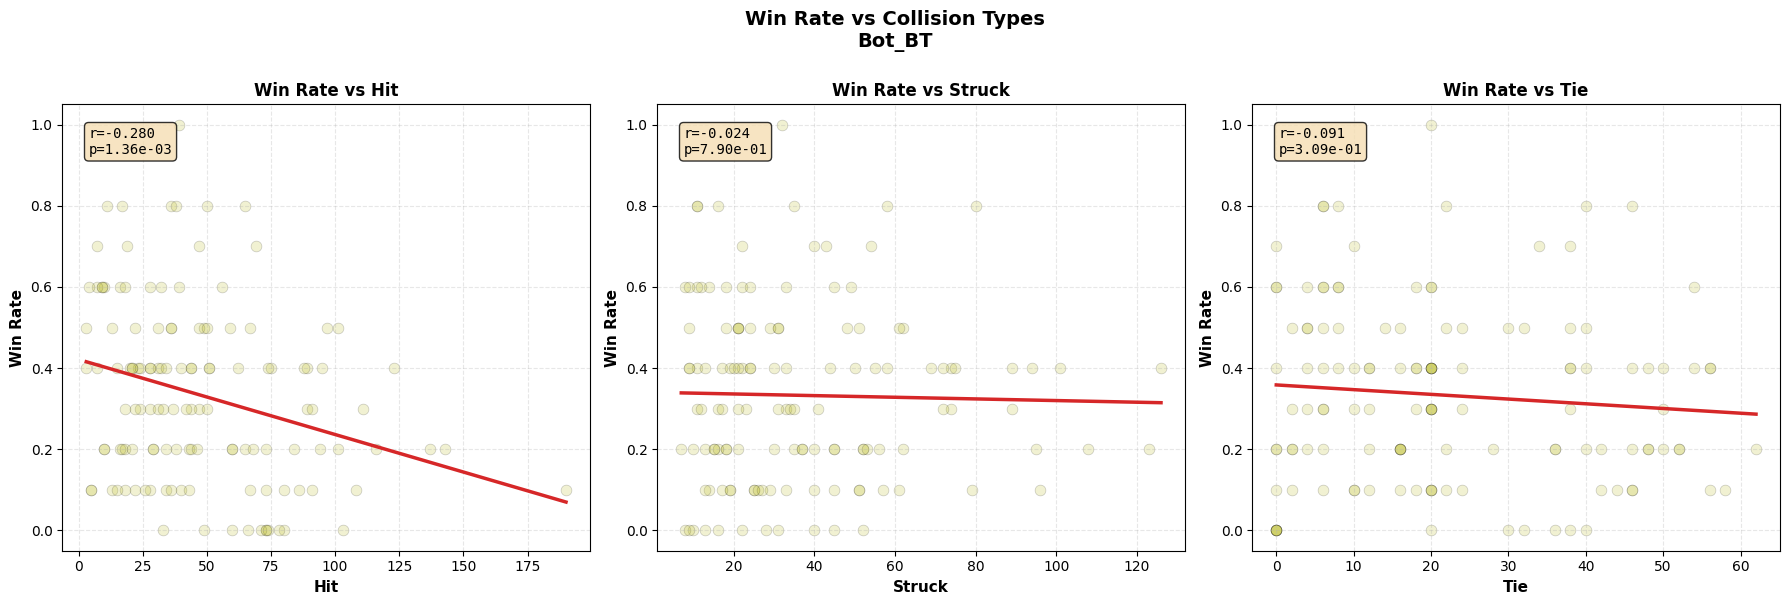


--- Win Rate vs Round Type Configuration ---

--- Win Rate vs Timer Configuration ---

--- Win Rate vs Skill Type Configuration ---

--- Win Rate vs Individual Action Types ---

--- Win Rate vs Individual Action Duration ---

--- Win Rate vs Collision Types (Hit, Struck, Tie) ---

Analyzing correlations for Bot_NN

--- Win Rate vs Action Interval Configuration ---


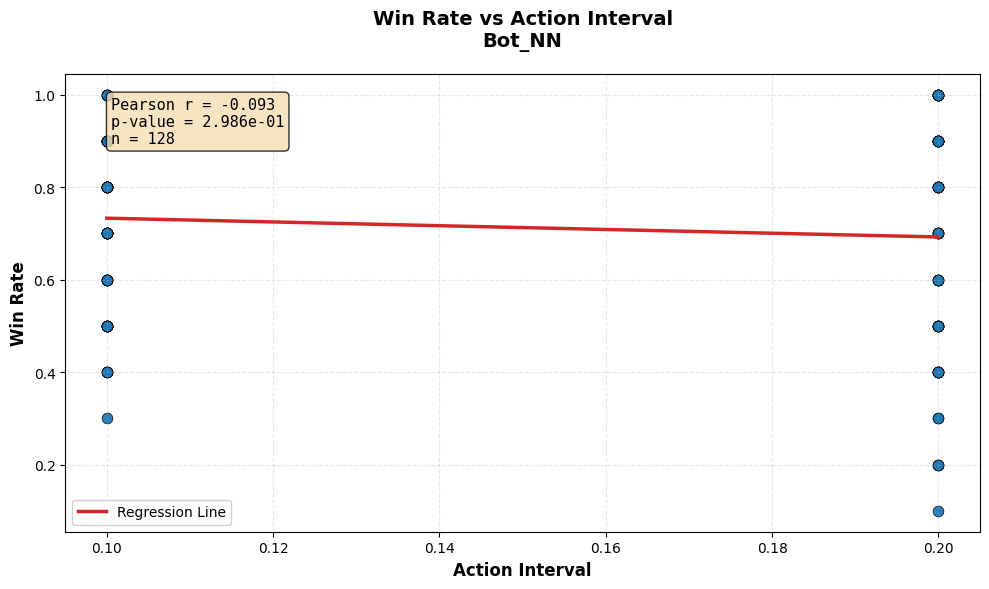

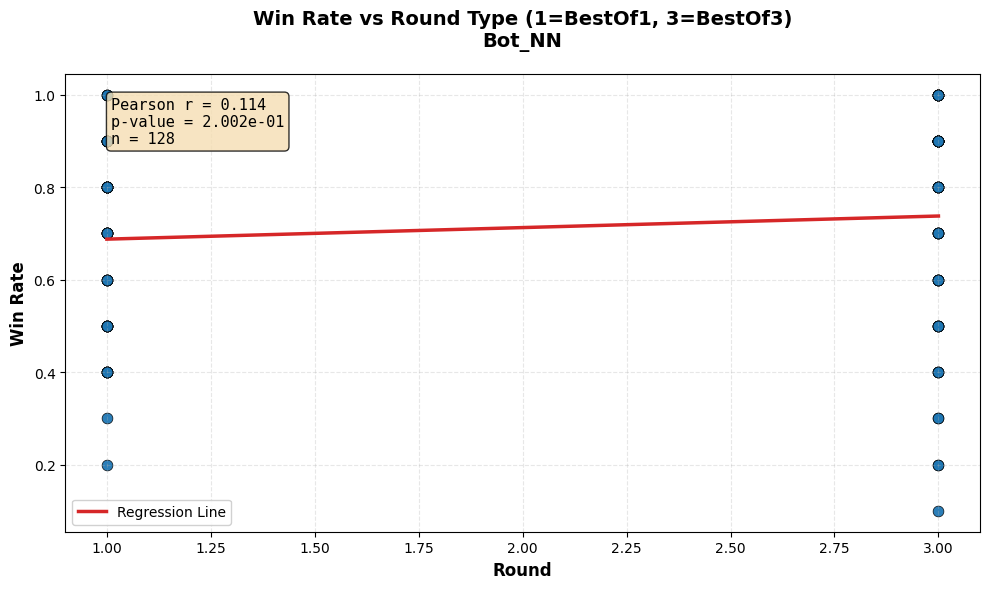

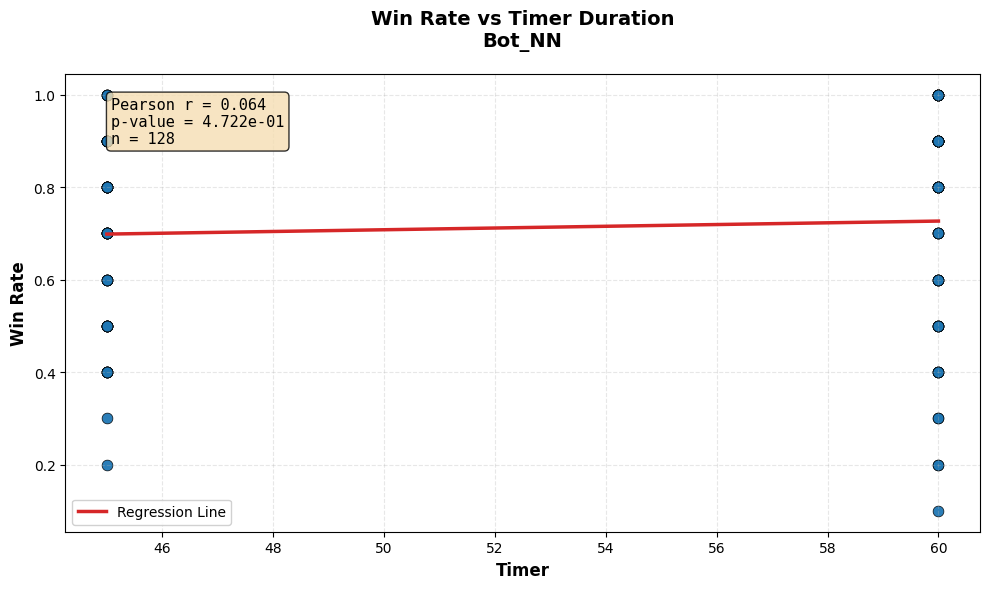

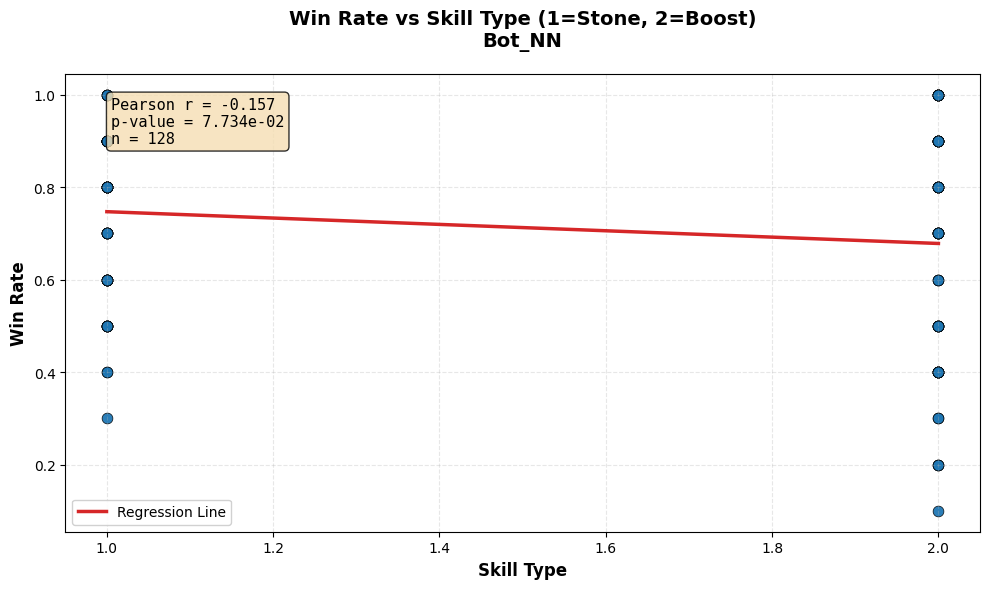

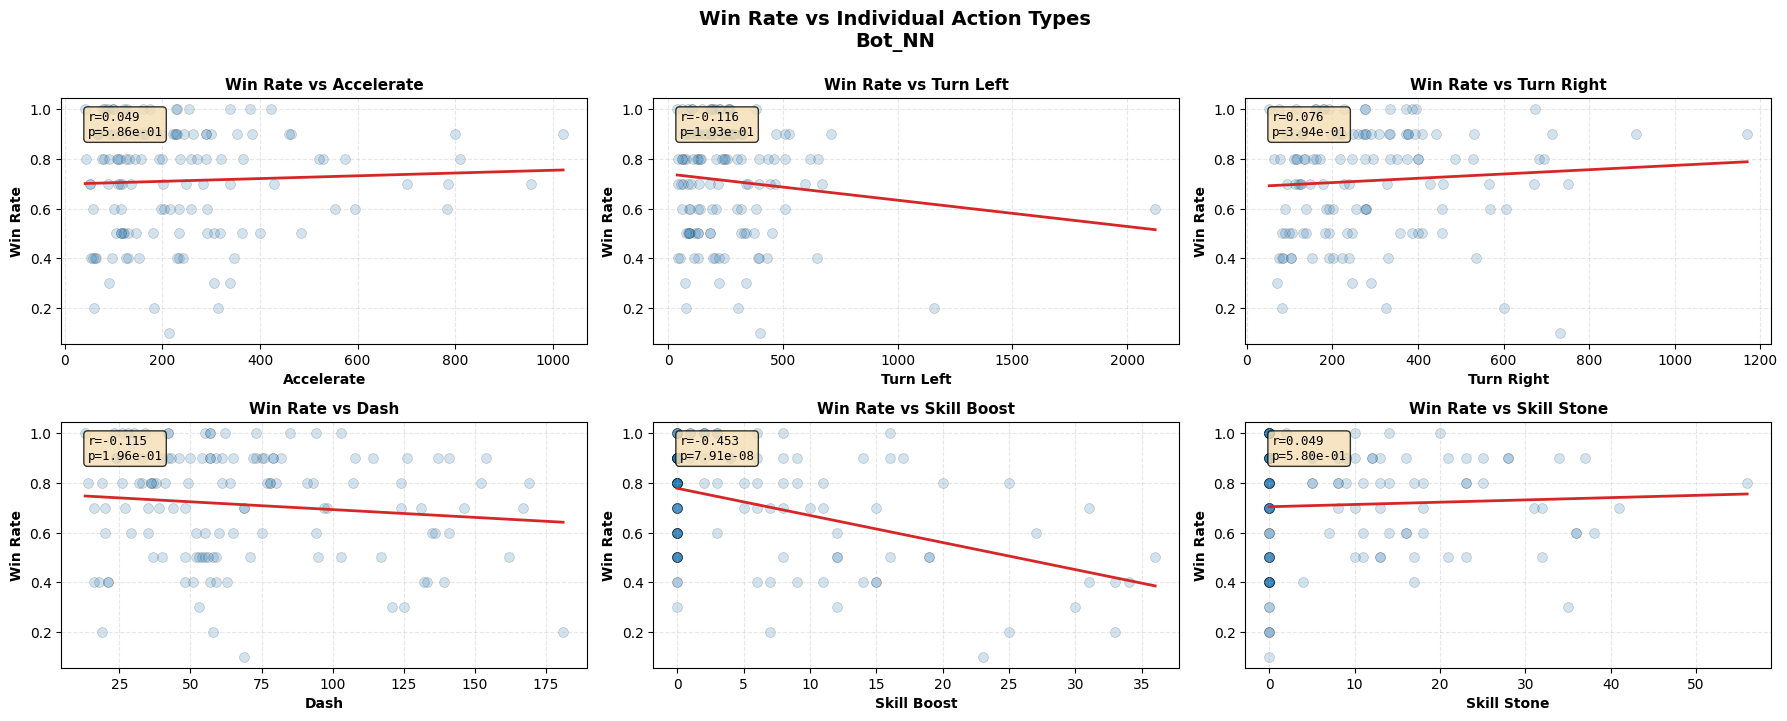

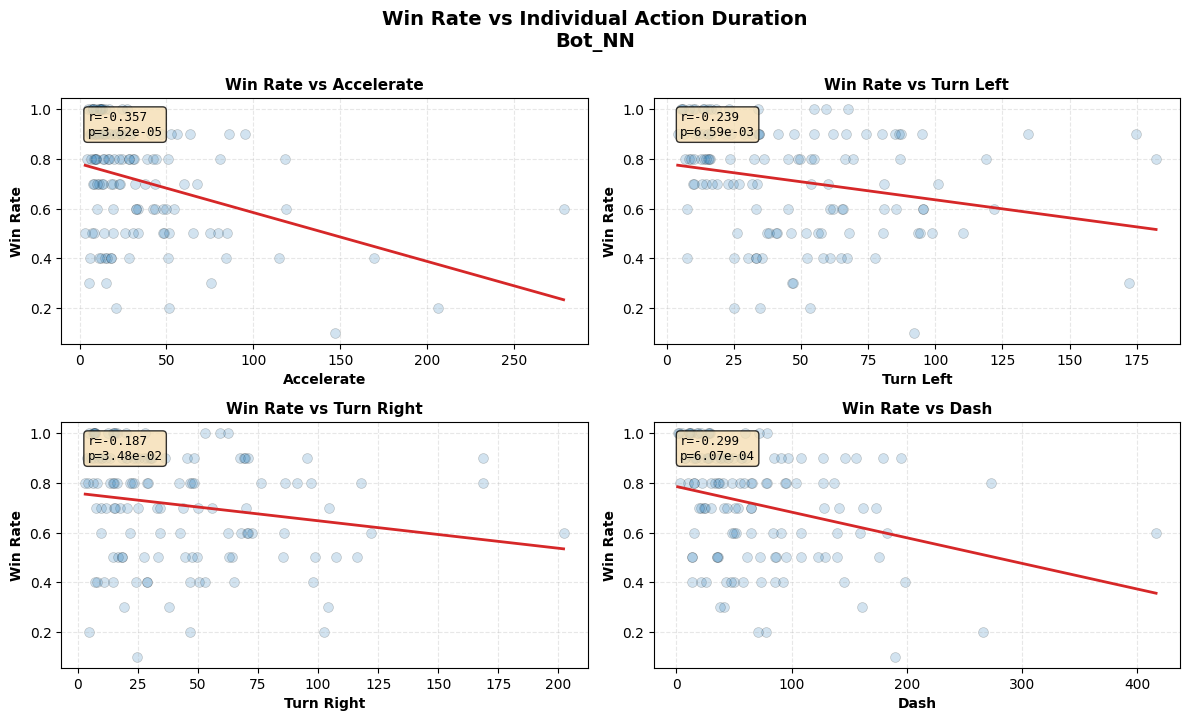

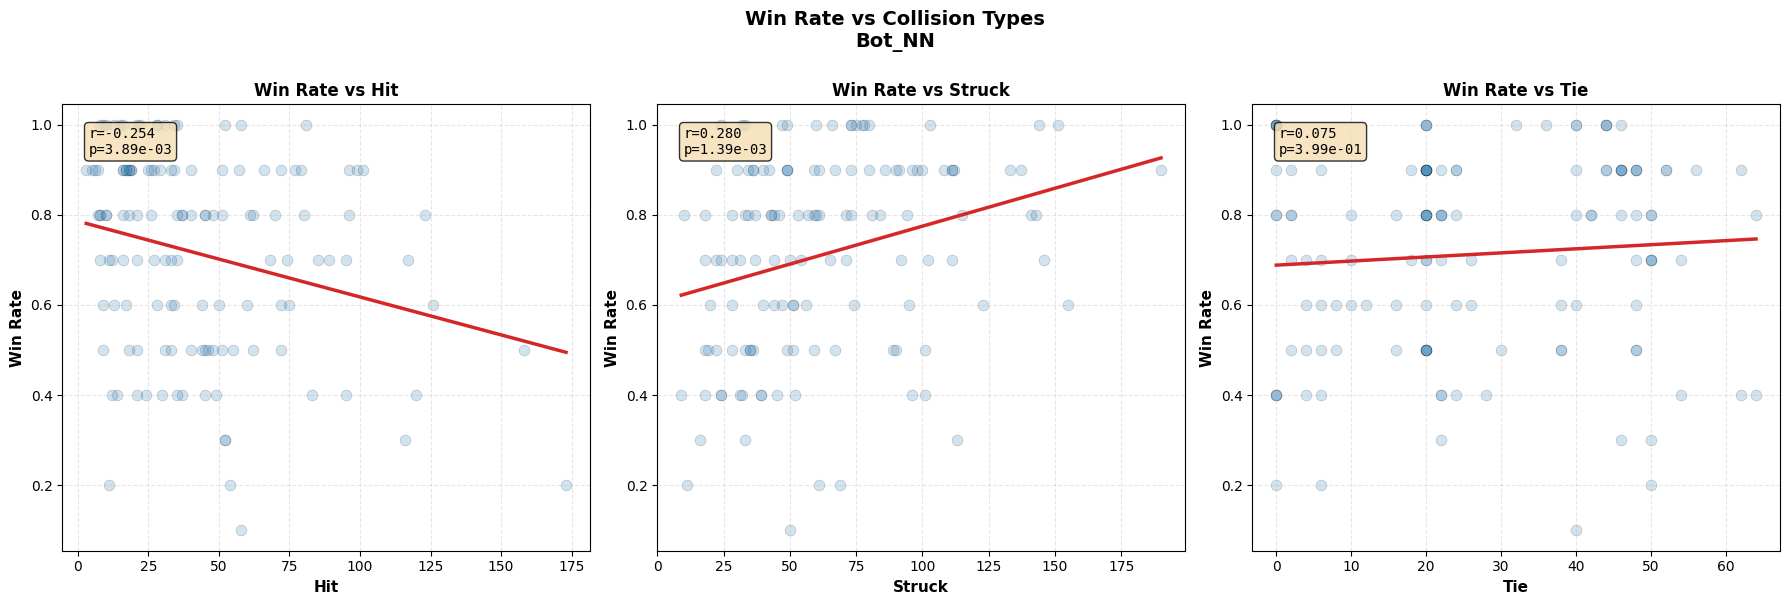


--- Win Rate vs Round Type Configuration ---

--- Win Rate vs Timer Configuration ---

--- Win Rate vs Skill Type Configuration ---

--- Win Rate vs Individual Action Types ---

--- Win Rate vs Individual Action Duration ---

--- Win Rate vs Collision Types (Hit, Struck, Tie) ---

Analyzing correlations for Bot_Primitive

--- Win Rate vs Action Interval Configuration ---


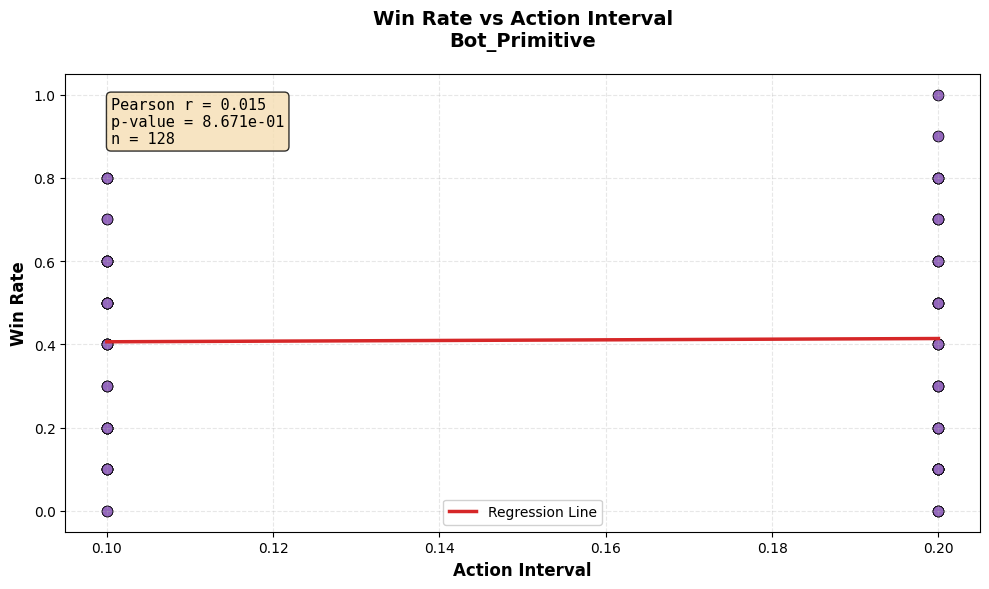

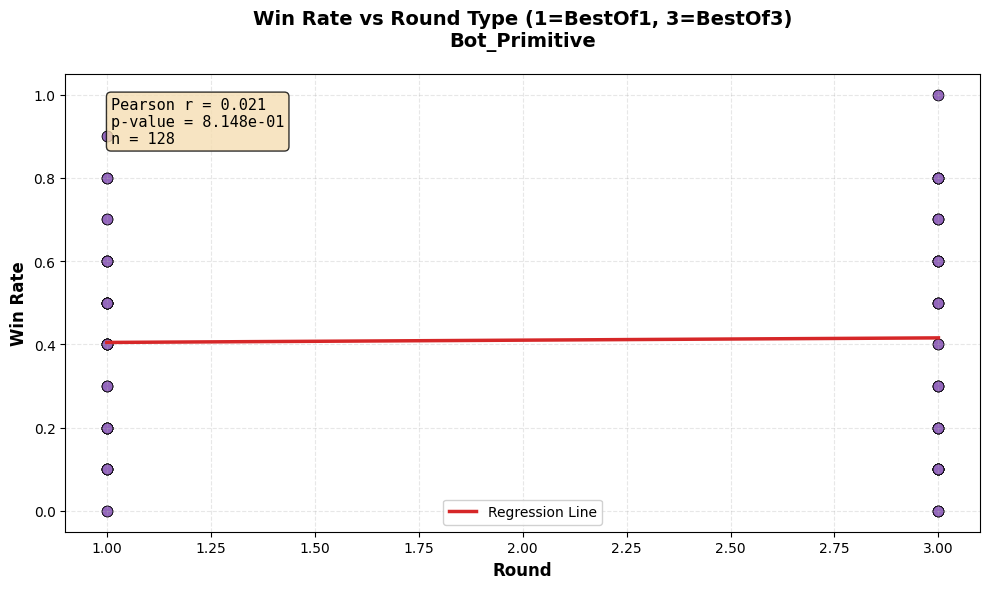

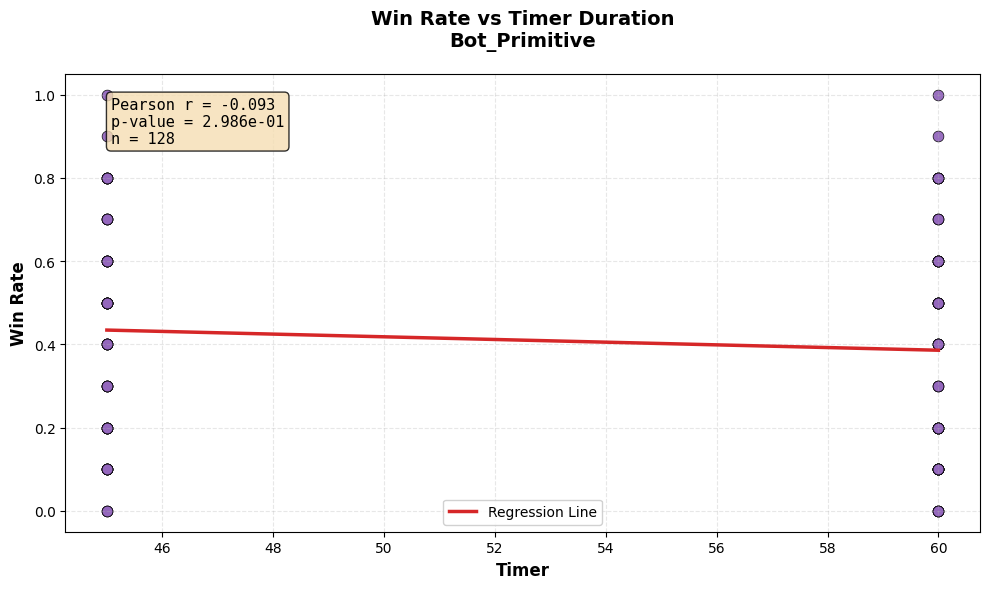

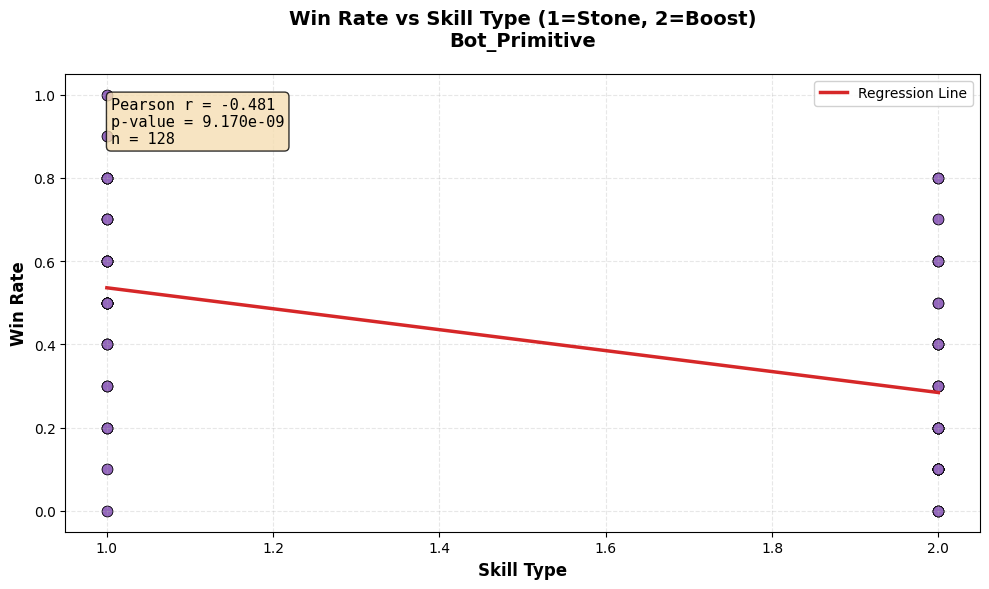

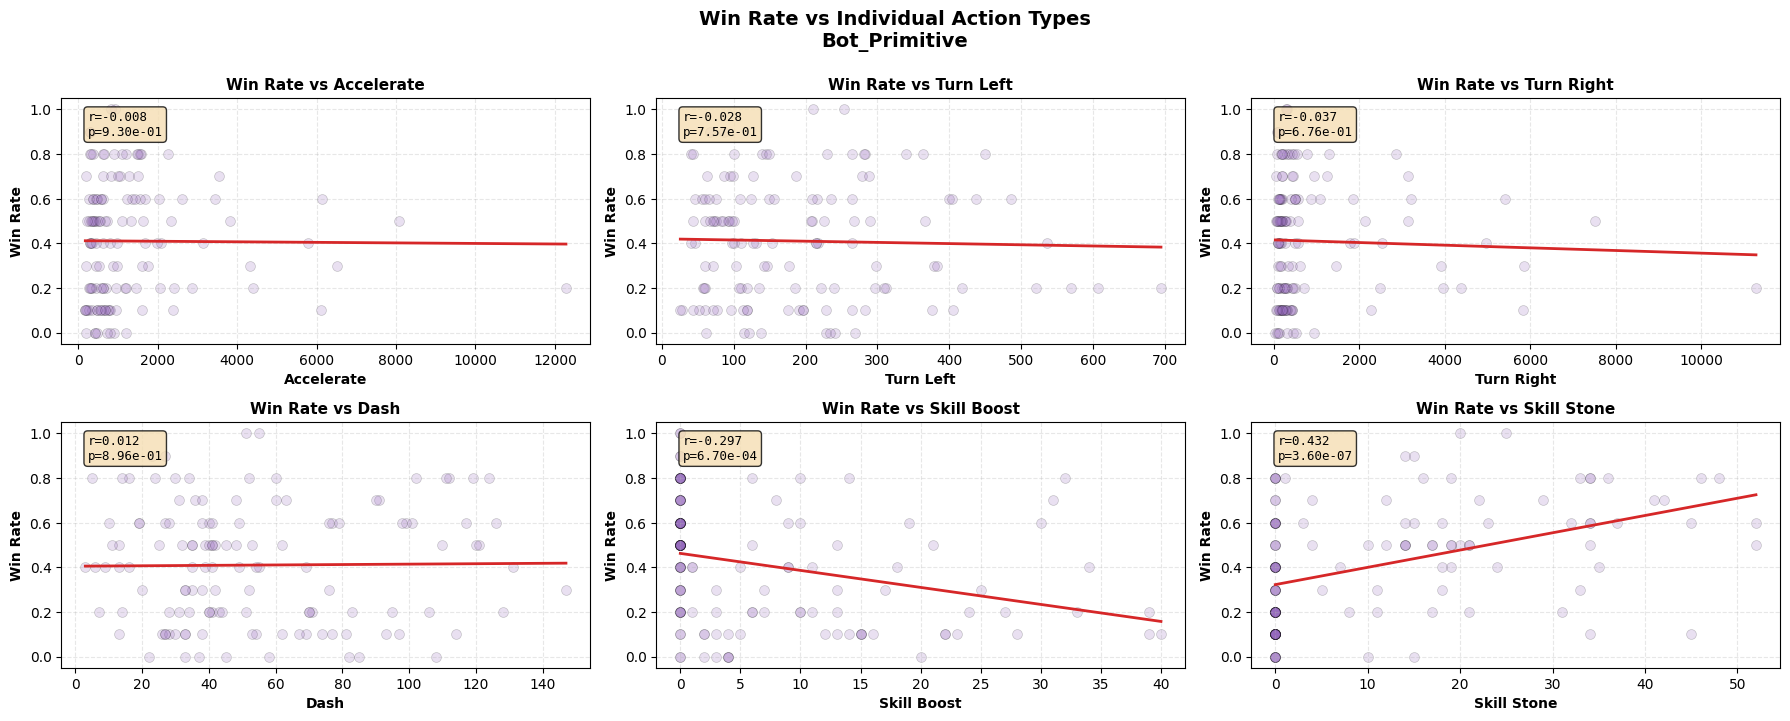

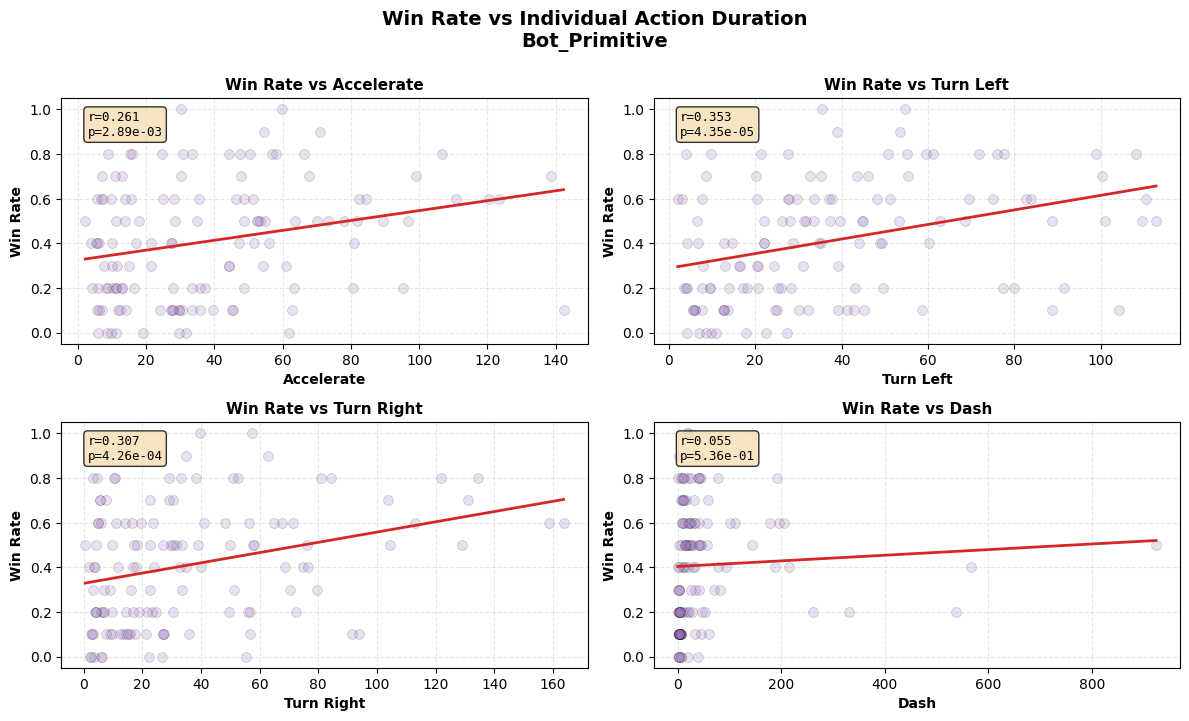

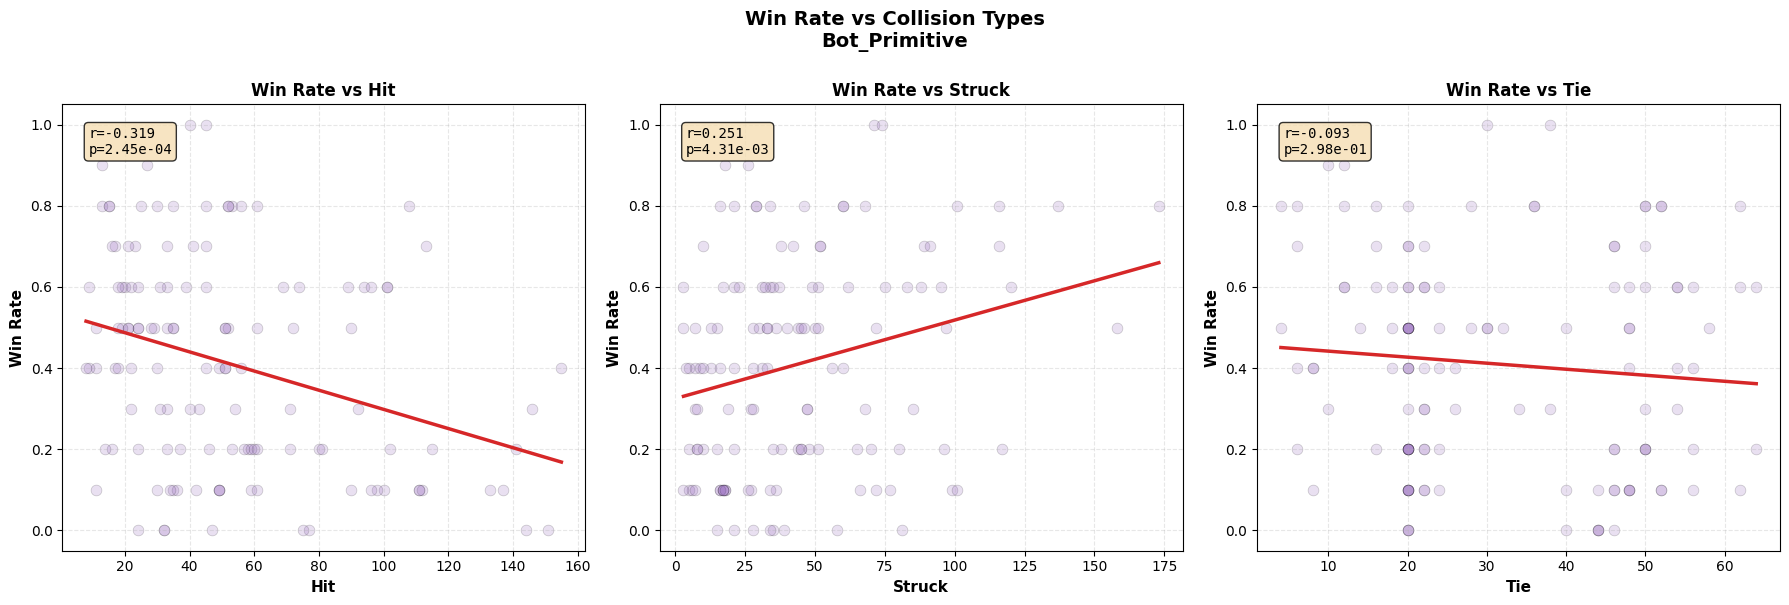


--- Win Rate vs Round Type Configuration ---

--- Win Rate vs Timer Configuration ---

--- Win Rate vs Skill Type Configuration ---

--- Win Rate vs Individual Action Types ---

--- Win Rate vs Individual Action Duration ---

--- Win Rate vs Collision Types (Hit, Struck, Tie) ---


In [162]:
# Get unique bots
bots_list = sorted(df['Bot_L'].unique())
print(f"Analyzing {len(bots_list)} bots: {bots_list}")

# Individual bot correlation analysis
for bot in bots_list:
    print(f"\n{'='*60}")
    print(f"Analyzing correlations for {bot}")
    print(f"{'='*60}")
    
    correlation_figs = plot_individual_bot_correlations(df, bot, width, height)
    
    if not correlation_figs:
        print(f"No data available for {bot}")
        continue
    
    # Win Rate vs ActInterval
    if 'actinterval' in correlation_figs:
        print("\n--- Win Rate vs Action Interval Configuration ---")
        plt.show()
    
    # Win Rate vs Round Type
    if 'roundtype' in correlation_figs:
        print("\n--- Win Rate vs Round Type Configuration ---")
        plt.show()
    
    # Win Rate vs Timer
    if 'timer' in correlation_figs:
        print("\n--- Win Rate vs Timer Configuration ---")
        plt.show()
    
    # Win Rate vs Skill Type
    if 'skilltype' in correlation_figs:
        print("\n--- Win Rate vs Skill Type Configuration ---")
        plt.show()
    
    # Win Rate vs Action Types
    if 'actions' in correlation_figs:
        print("\n--- Win Rate vs Individual Action Types ---")
        plt.show()
    
    # Win Rate vs Action Duration
    if 'actions_dur' in correlation_figs:
        print("\n--- Win Rate vs Individual Action Duration ---")
        plt.show()
    
    # Win Rate vs Collisions
    if 'collisions' in correlation_figs:
        print("\n--- Win Rate vs Collision Types (Hit, Struck, Tie) ---")
        plt.show()

### Arena Heatmaps - Bot Movement Analysis

Visualize bot movement patterns across different game phases (Early, Mid, Late)


Bot_NN (#1)


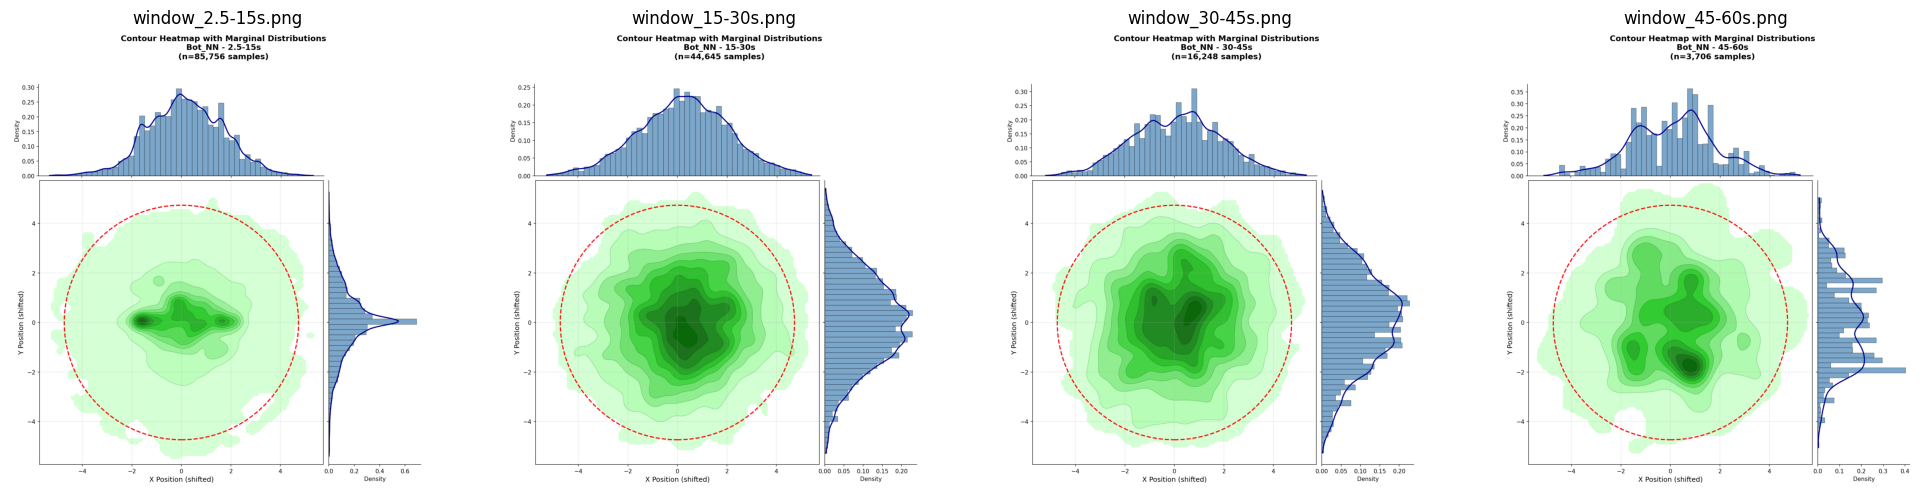


Position Distribution (X & Y Overlayed)


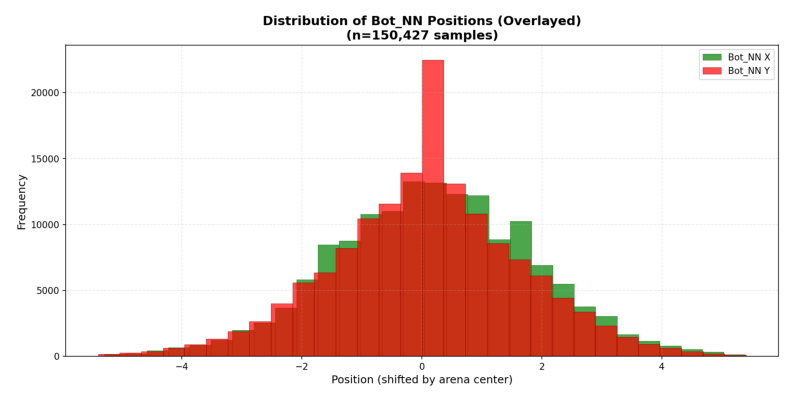


Distance Distribution


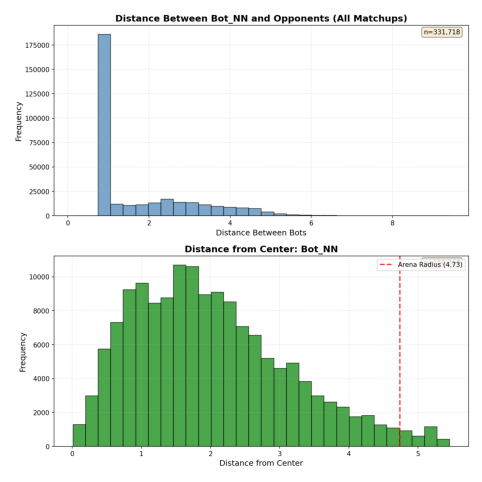


Full Configuration Analysis


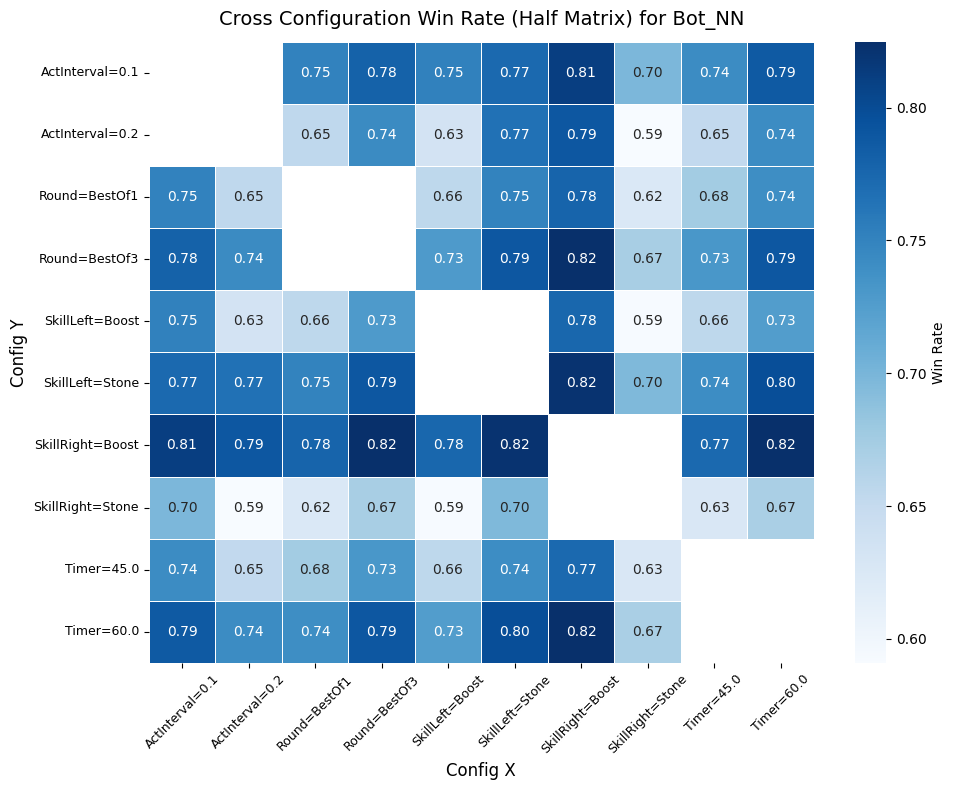


Bot_Primitive (#2)


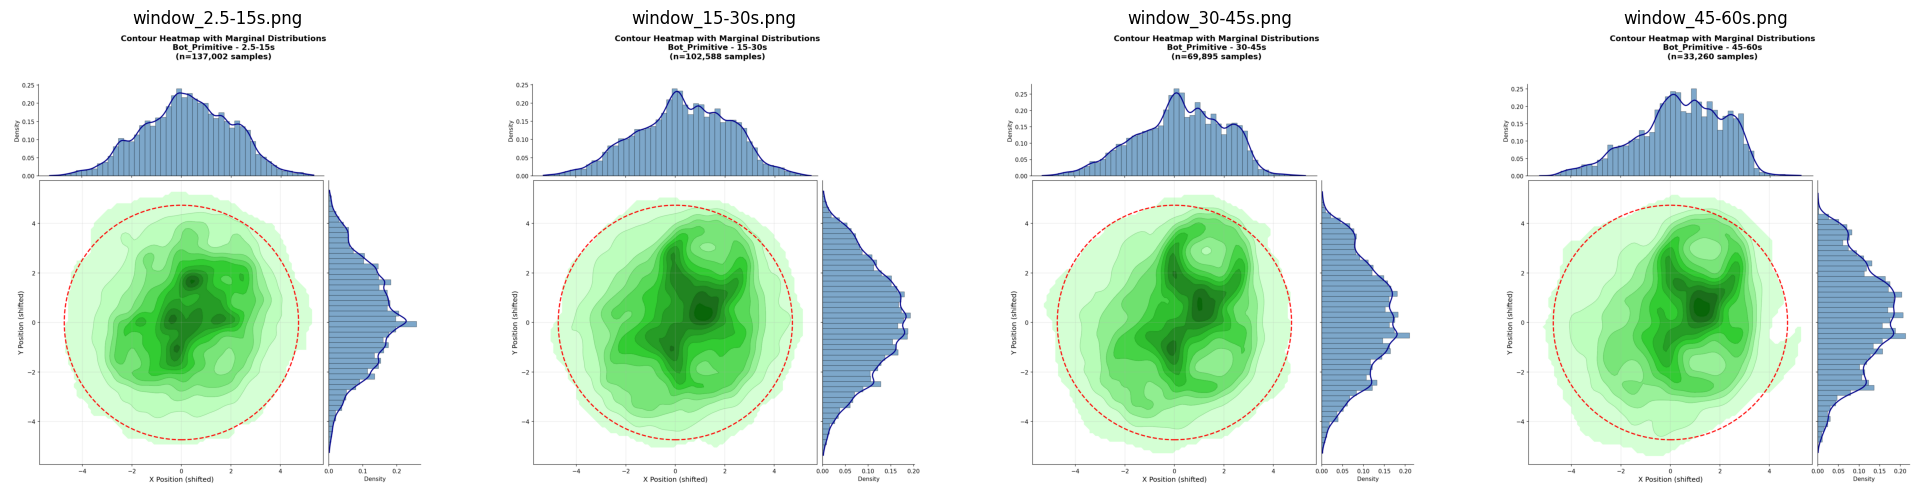


Position Distribution (X & Y Overlayed)


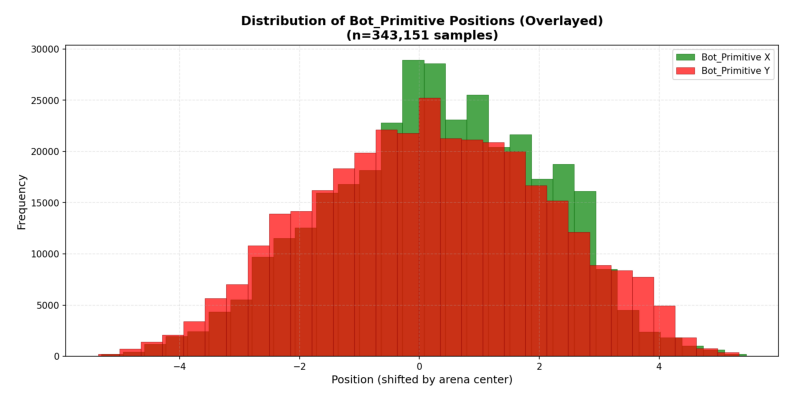


Distance Distribution


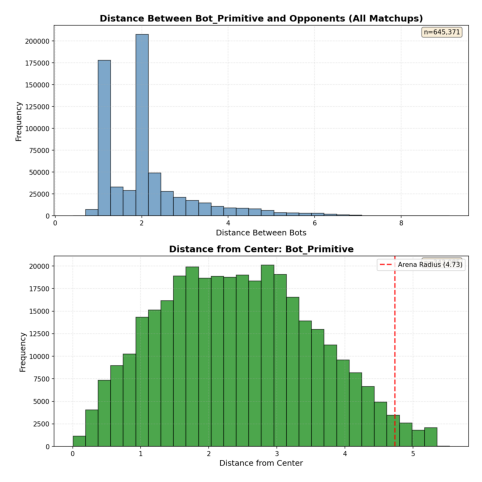


Full Configuration Analysis


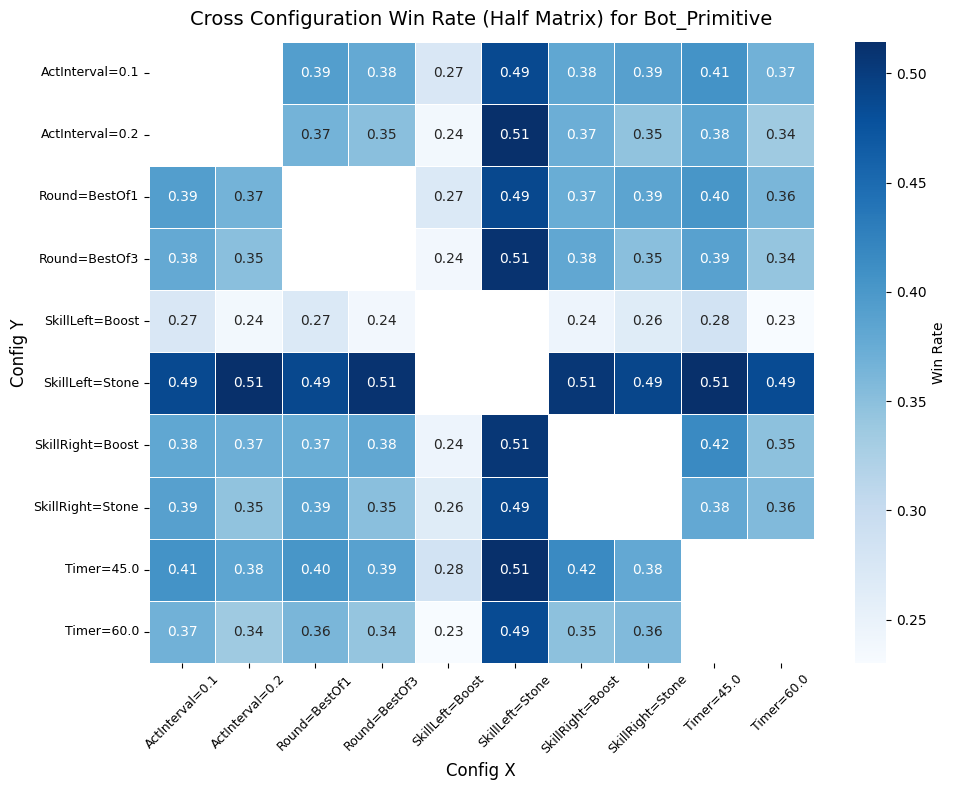


Bot_BT (#3)


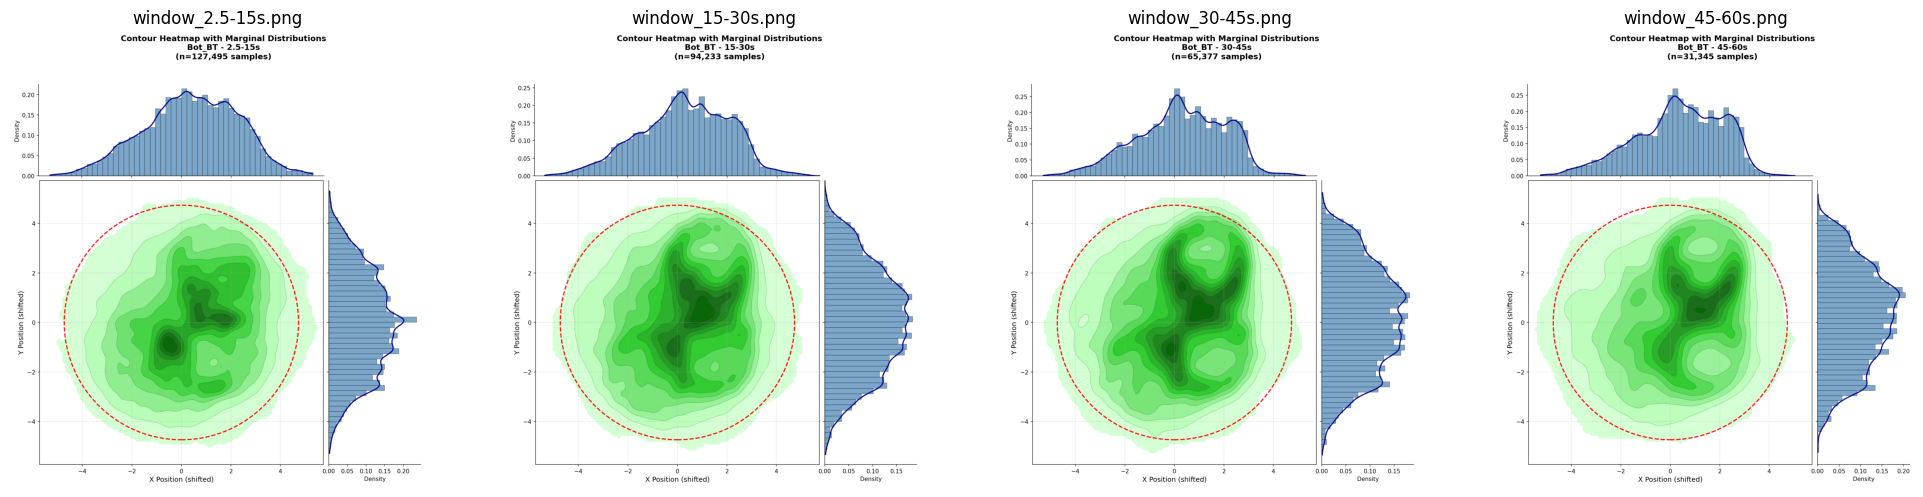


Position Distribution (X & Y Overlayed)


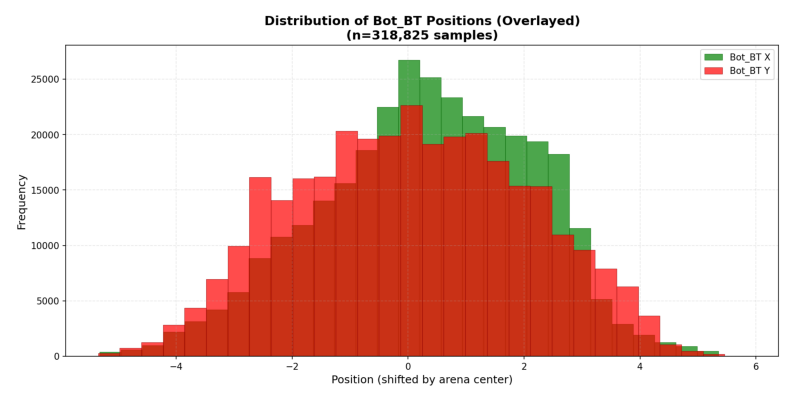


Distance Distribution


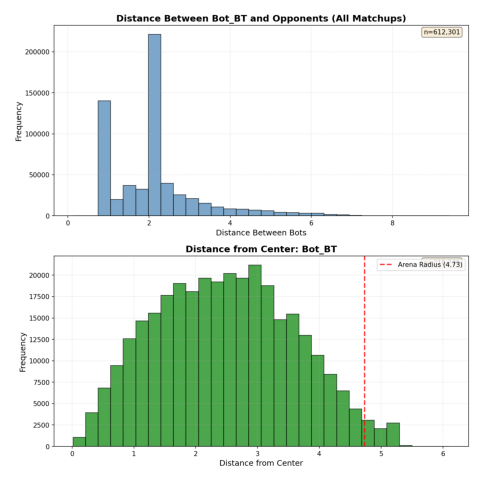


Full Configuration Analysis


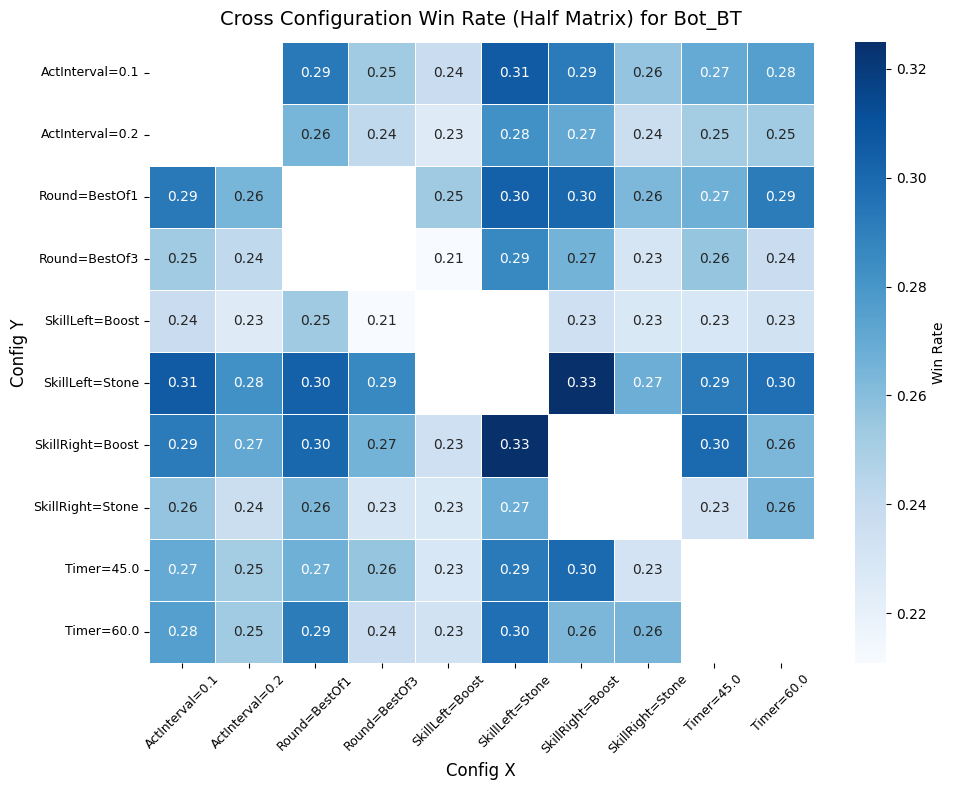

In [163]:
# Check if arena_heatmap directory exists
heatmap_dir = "arena_heatmaps"

if os.path.exists(heatmap_dir):
    # Get all bot directories
    bot_dirs = [d for d in os.listdir(heatmap_dir)
               if os.path.isdir(os.path.join(heatmap_dir, d))]
    
    # Sort bot directories by rank from df_sum
    if "Rank" in df_sum.columns and "Bot" in df_sum.columns:
        rank_map = df_sum.groupby("Bot")["Rank"].first().to_dict()
        bot_dirs = sorted(bot_dirs, key=lambda b: rank_map.get(b, 9999))
    else:
        bot_dirs = sorted(bot_dirs)
    
    if bot_dirs:
        phase_names = ["window_2.5-15s.png", "window_15-30s.png", "window_30-45s.png", "window_45-60s.png"]
        
        # Display heatmaps for each bot
        for bot_name in bot_dirs:
            print(f"\n{'='*60}")
            print(f"{bot_name} (#{bot_dirs.index(bot_name)+1})")
            print(f"{'='*60}")
            bot_dir = os.path.join(heatmap_dir, bot_name)
            
            # Display phase heatmaps
            fig, axes = plt.subplots(1, len(phase_names), figsize=(20, 5))
            for idx, phase_name in enumerate(phase_names):
                image_path = os.path.join(bot_dir, phase_name)
                if os.path.exists(image_path):
                    image = Image.open(image_path)
                    axes[idx].imshow(image)
                    axes[idx].set_title(phase_name)
                    axes[idx].axis('off')
                else:
                    axes[idx].text(0.5, 0.5, f"Image not found:\n{phase_name}",
                                  ha='center', va='center')
                    axes[idx].axis('off')
            plt.tight_layout()
            plt.show()
            
            # Display position distribution
            dist_path = os.path.join(bot_dir, "position_distribution.png")
            if os.path.exists(dist_path):
                print("\nPosition Distribution (X & Y Overlayed)")
                dist_image = Image.open(dist_path)
                plt.figure(figsize=(10, 6))
                plt.imshow(dist_image)
                plt.axis('off')
                plt.show()
            
            # Display distance distribution
            dist_path = os.path.join(bot_dir, "distance_distribution.png")
            if os.path.exists(dist_path):
                print("\nDistance Distribution")
                dist_image = Image.open(dist_path)
                plt.figure(figsize=(10, 6))
                plt.imshow(dist_image)
                plt.axis('off')
                plt.show()

            print("\nFull Configuration Analysis")
            fig = plot_full_cross_heatmap_half(df, bot_name=bot_name)
            plt.show()
    else:
        print("No bot heatmaps found in directory")
        print("Run: `python detailed_analyzer.py all` to generate heatmaps")
else:
    print(f"Heatmap directory not found: {heatmap_dir}")
    print("Run: `python detailed_analyzer.py all` to generate heatmaps for all bots")